# Authenticating Raspberry Pi Devices

#### By Benjamin Frost, with guidance from Dr Nikos Komninos

This notebook accompanies the paper of the same name.

#### Libraries

Matplotlib was chosen as the graphics library for this project.

Numpy is used to format arrays and data formatting.

Pandas is used for importing and formatting the datasets.

SkLearn, also known as SciKit-Learn, provides the machine learning algorithms used in the project.

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model, utils, cluster
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

#### The Data class is used to store the formatted dataset. It is also used to calculate coefficients for the dataset to the specified degree.

In [112]:
class Data:
    
    def __init__(self, df):
        self.df = formatDF(df)
        self.combinedDF = combineDF(self.df)
        self.weightedDF = weightedDF(self.combinedDF)
    
    def getCoefs(self, degree):
        return calculateModel(self.weightedDF, degree).steps[1][1].coef_[1:degree+1]


#### This method formats the raw dataframe by removing duplicate rows and any unnamed columns.

In [113]:
def formatDF(df):
    
    df = df.drop_duplicates()
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    return df

#### This method takes a dataset with a large number of columns and pairs up the columns into their X and Y points.

#### It then creates a dataset with two columns representing X and Y for all of the data. This new combined dataset uses '0' for X and '1' for Y.

In [114]:
def combineDF(df):
    
    dfCombined = pd.DataFrame()
    
    for i in range(int(df.shape[1]/2)):
        
        col1 = df.iloc[:,i*2]
        col2 = df.iloc[:,(i*2)+1]
                
        dfCombined = dfCombined.append(pd.DataFrame.from_dict({'0':col1, '1':col2}), ignore_index=True)
        
    dfCombined.dropna(inplace=True)
    
    return dfCombined

#### This method weights the values depending on their uniqueness in the dataset using the SkLearn weighting system.

In [115]:
def weightedDF(df):
    
    dfWeighted = pd.DataFrame()
    
    dfWeighted['0'] = uniqueModelX = utils.class_weight.compute_class_weight('balanced', df['0'], df['0'])

    dfWeighted['1'] = uniqueModelY = utils.class_weight.compute_class_weight('balanced', df['1'], df['1'])
    
    dfWeighted.drop_duplicates(inplace=True)
    
    dfWeighted.reset_index(inplace=True, drop=True)

    return dfWeighted

#### This method calculates a model to a given degree for a given dataset.

In [116]:
def calculateModel(df, degree):
    
    model = make_pipeline(PolynomialFeatures(degree=degree), Ridge())
    model.fit(df['0'].values.reshape(-1,1), df['1'])
    
    return model

#### This method loads csv files, storing the data in the above class.

#### Each Data object is stored in a dictionary with the Key representing the name of the dataset.

In [117]:
def loadData(fileName, num):
    
    global dataList
    
    for i in range(num):
        key = (fileName + str(i+1) + '.csv')

        df = pd.read_csv(key)

        data = Data(df)
        
        dataList[fileName + str(i+1)] = data
    
    print('Loaded %s %s' % (str(num), fileName))


#### A sample dataset is loaded in to view the contents.

In [118]:
dataList = {}

loadData('Home50', 1)

Loaded 1 Home50


#### Below are the first 5 rows of the first HomePi dataset, giving you and idea of how each dataset is structured when it is loaded in.

#### We can see that there are a large number of columns containing many duplicate values. This dataset has been formatted to remove any repeated rows and unnamed columns.

In [119]:
data = dataList.get('Home501')
data.df.head()

,memorySize_arm,memorySize_gpu,cpuSerial,cpuSerial.1,cpuSerial.2,cpuSerial.3,firmwareVersion,firmwareVersion.1,firmwareVersion.2,firmwareVersion.3,...,clock_v3d,clock_uart,clock_pwm,clock_emmc,clock_pixel,clock_vec,clock_hdmi,clock_dpi,processCpuLoad,systemCpuLoad
0,768,256,4096,0,62061,28397,59544283,2.101192,2.018018,2.433268,...,4.999878,48001464.0,0.0,1.999951,3.000059,0.0,0.0,0.0,2.605429e+03,6.208038e+06
1,768,256,0,0,30796,49685,59544283,2.101192,2.018018,2.433268,...,5.000010,48001464.0,0.0,1.999951,2.999927,0.0,0.0,0.0,2.485207e+07,4.674556e+07
2,768,256,4096,0,62061,28397,59544283,2.101192,2.018018,2.433268,...,5.000010,48001464.0,0.0,1.999951,3.000059,0.0,0.0,0.0,1.304348e+07,4.202899e+07
3,768,256,4096,0,62061,28397,59544283,2.101192,2.018018,2.433268,...,4.999878,48001464.0,0.0,1.999951,3.000059,0.0,0.0,0.0,1.212121e+07,4.090909e+07
4,768,256,4096,0,62061,28397,59544283,2.101192,2.018018,2.433268,...,5.000010,48001464.0,0.0,2.000083,3.000059,0.0,0.0,0.0,9.677419e+06,3.709677e+07


#### We will be conducting calculations on this dataset by first combining all of the data into two columns. When the data was collected, it was stored as points with x and y values. This new combined dataset will have the first point stored at the top, and the next point stored beneath etc.

In [120]:
data.combinedDF.head()

,0,1
0,768.0,256.0
1,768.0,256.0
2,768.0,256.0
3,768.0,256.0
4,768.0,256.0


#### This method prints graphs for each set of data points collected, which will help to show the variation in the data.

In [121]:
def printGraphs(df):

    colSize = df.shape[1]
    columns = df.columns

    for i in range(int(colSize/2)):

        col1 = df.iloc[:,i*2]
        col2 = df.iloc[:,(i*2)+1]

        xLabel = columns[i*2]
        yLabel = columns[(i*2)+1]

        dfTemp = pd.DataFrame(columns=['0', '1'])

        dfTemp['0'] = col1
        dfTemp['1'] = col2

        plt.plot(dfTemp['0'], dfTemp['1'], marker='o', linestyle='none')
        plt.title(xLabel + " vs " + yLabel)
        plt.xlabel(xLabel)
        plt.ylabel(yLabel)
        plt.show()


#### Below are all of the data points plotted individually for the dataset we just loaded in.

#### This gives us an understanding of the range of values we are working with for each data point.

#### The most interesting graph from this cell is perhaps the SystemLoadAverage vs Temperature graph, showing a range of data.

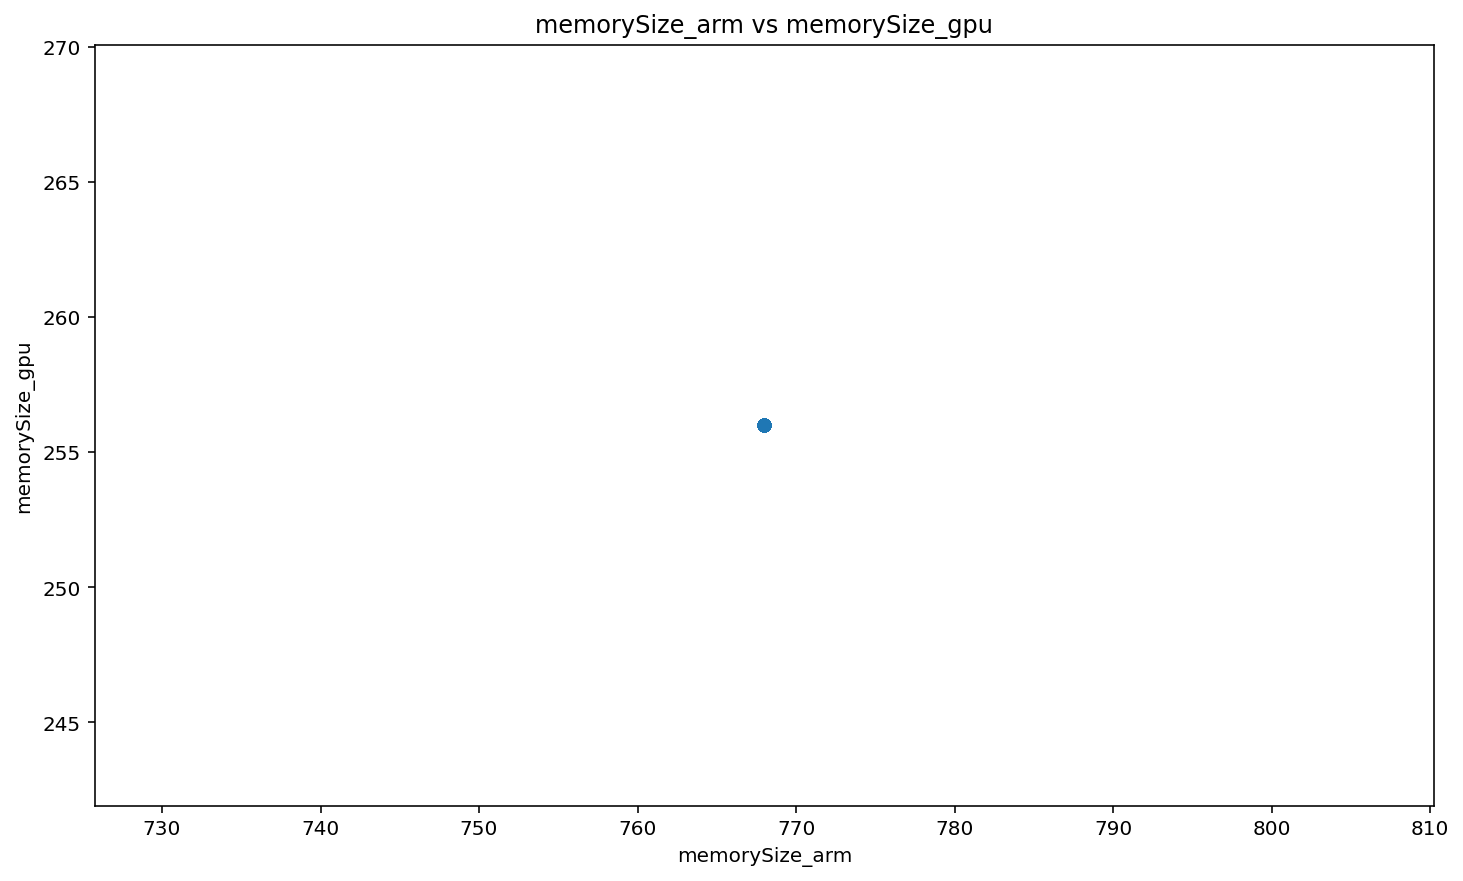

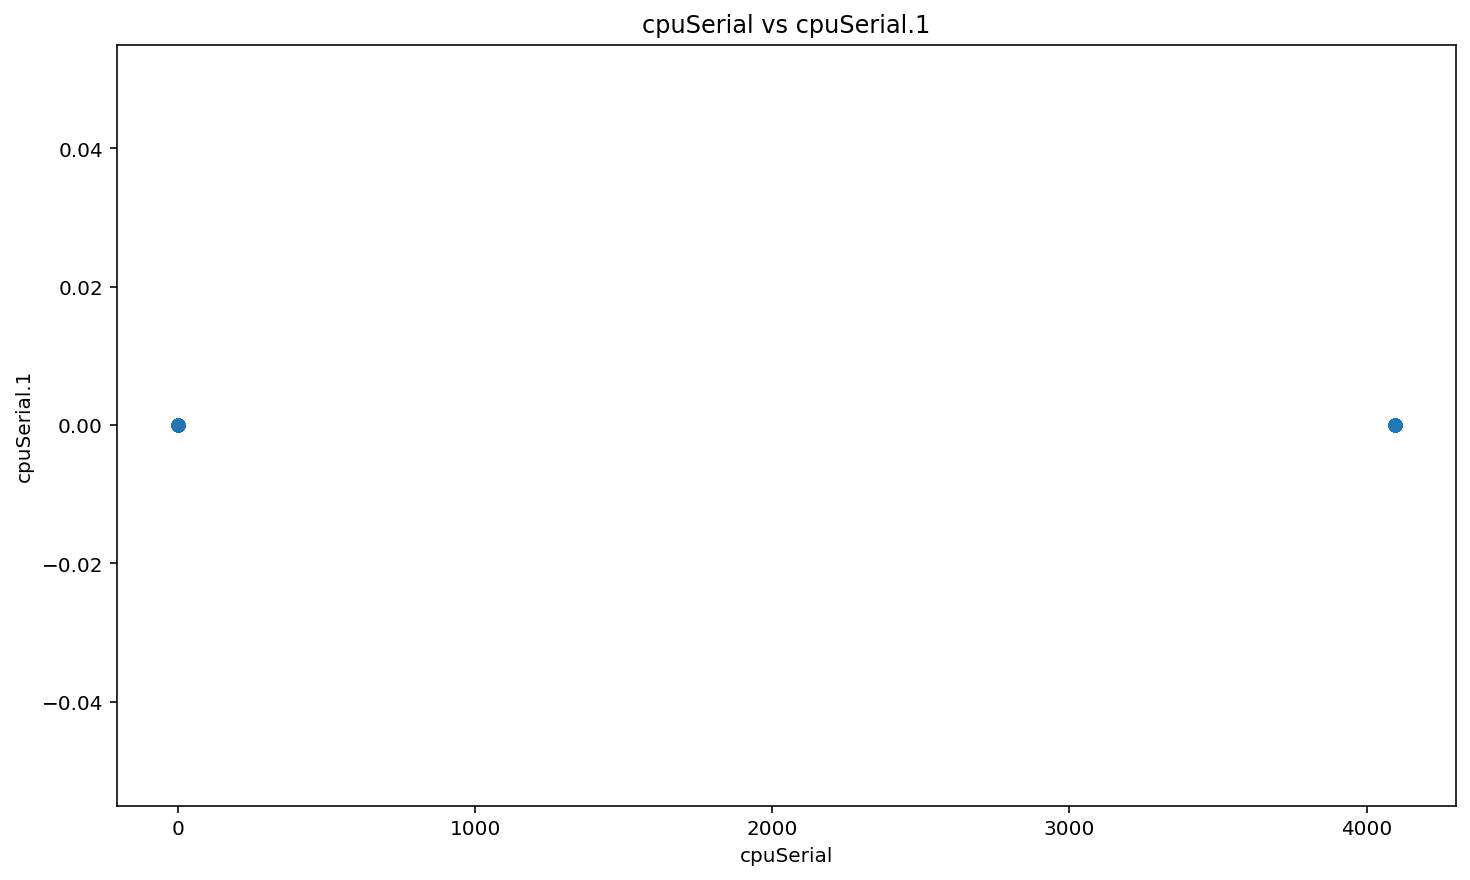

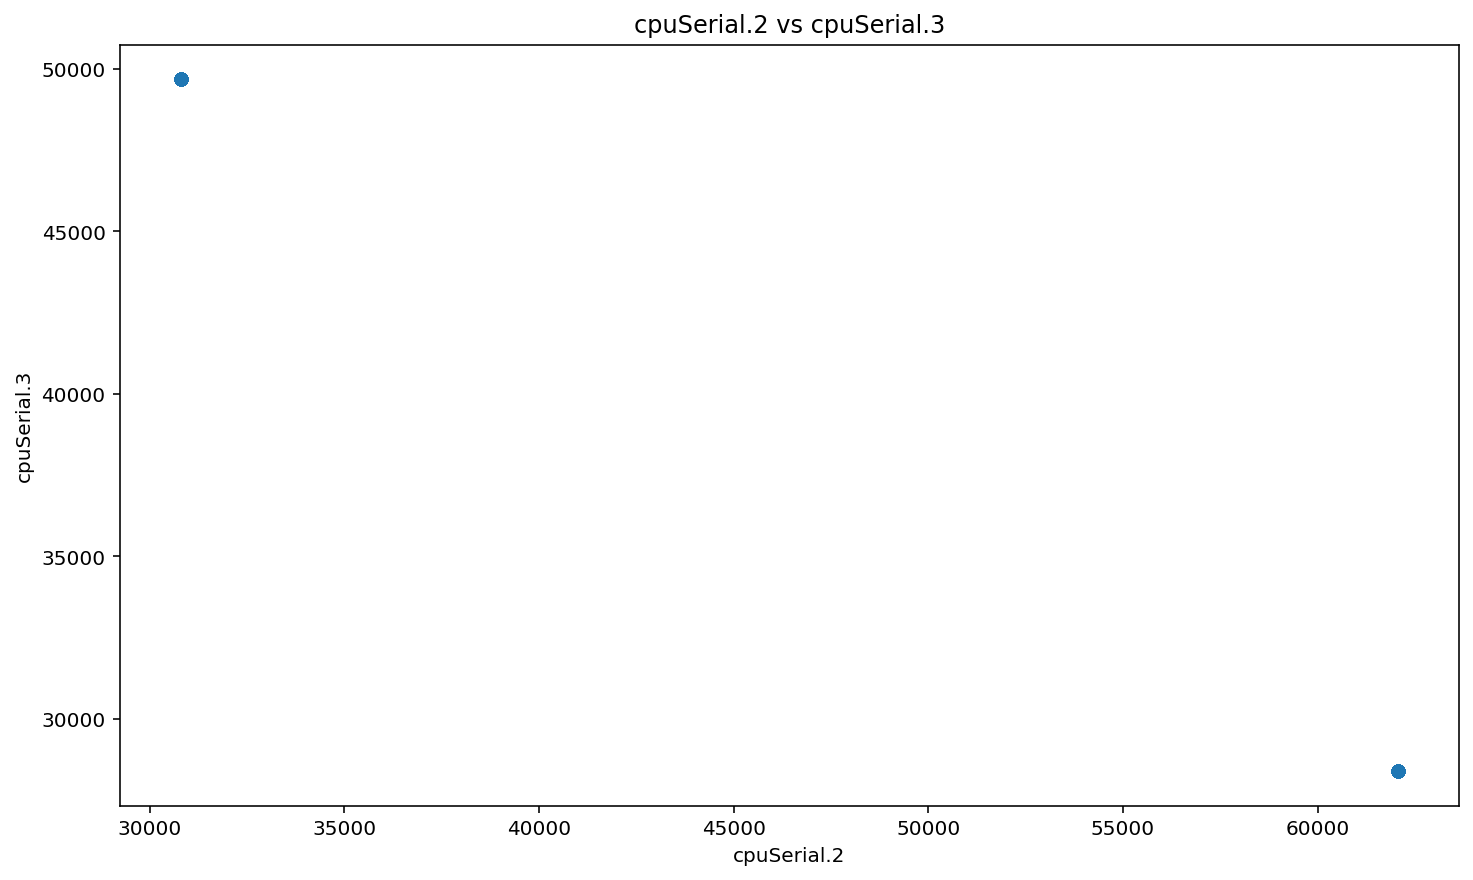

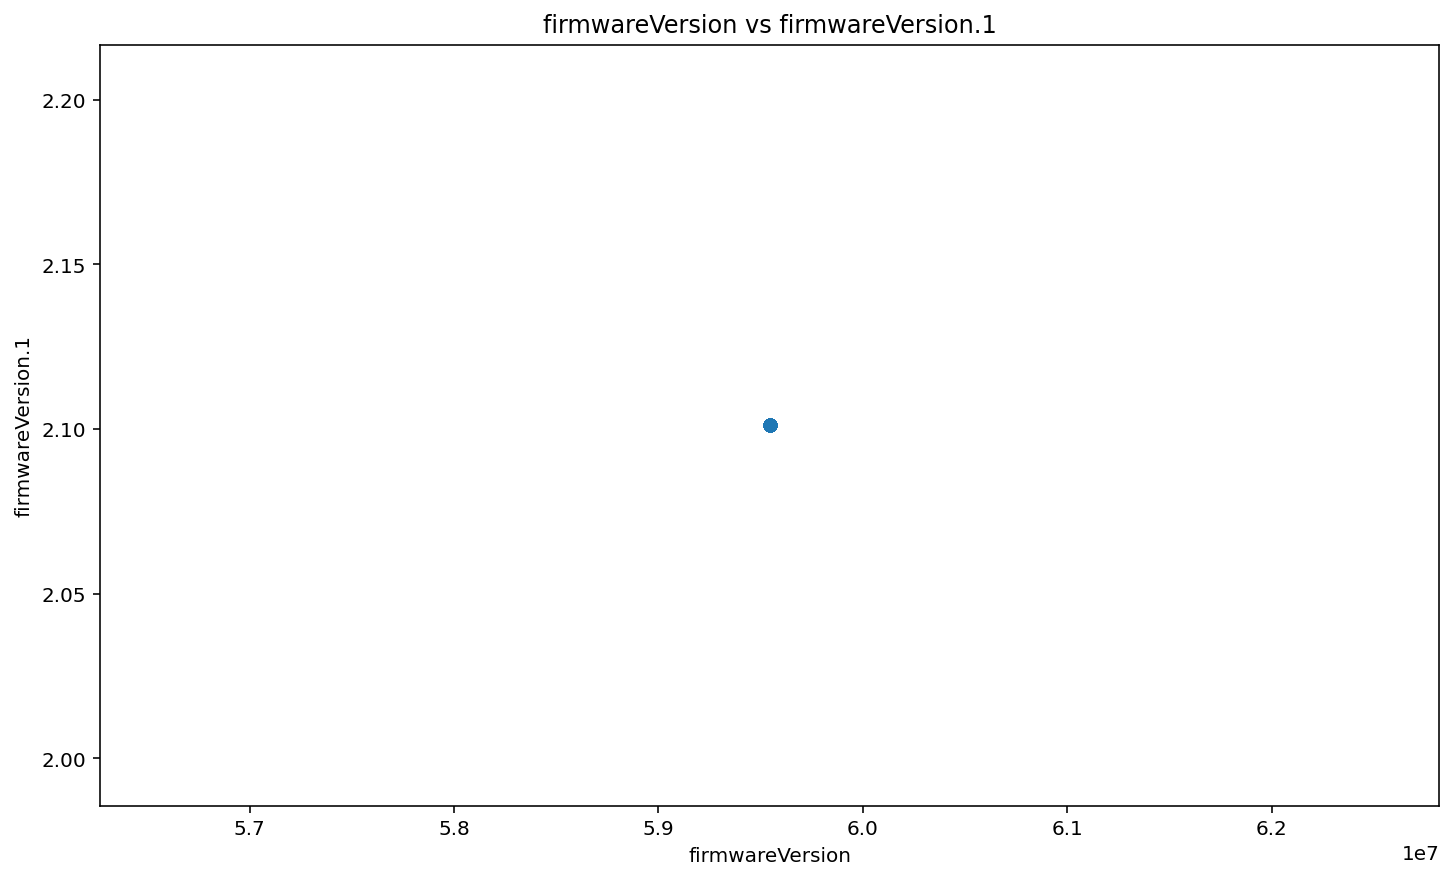

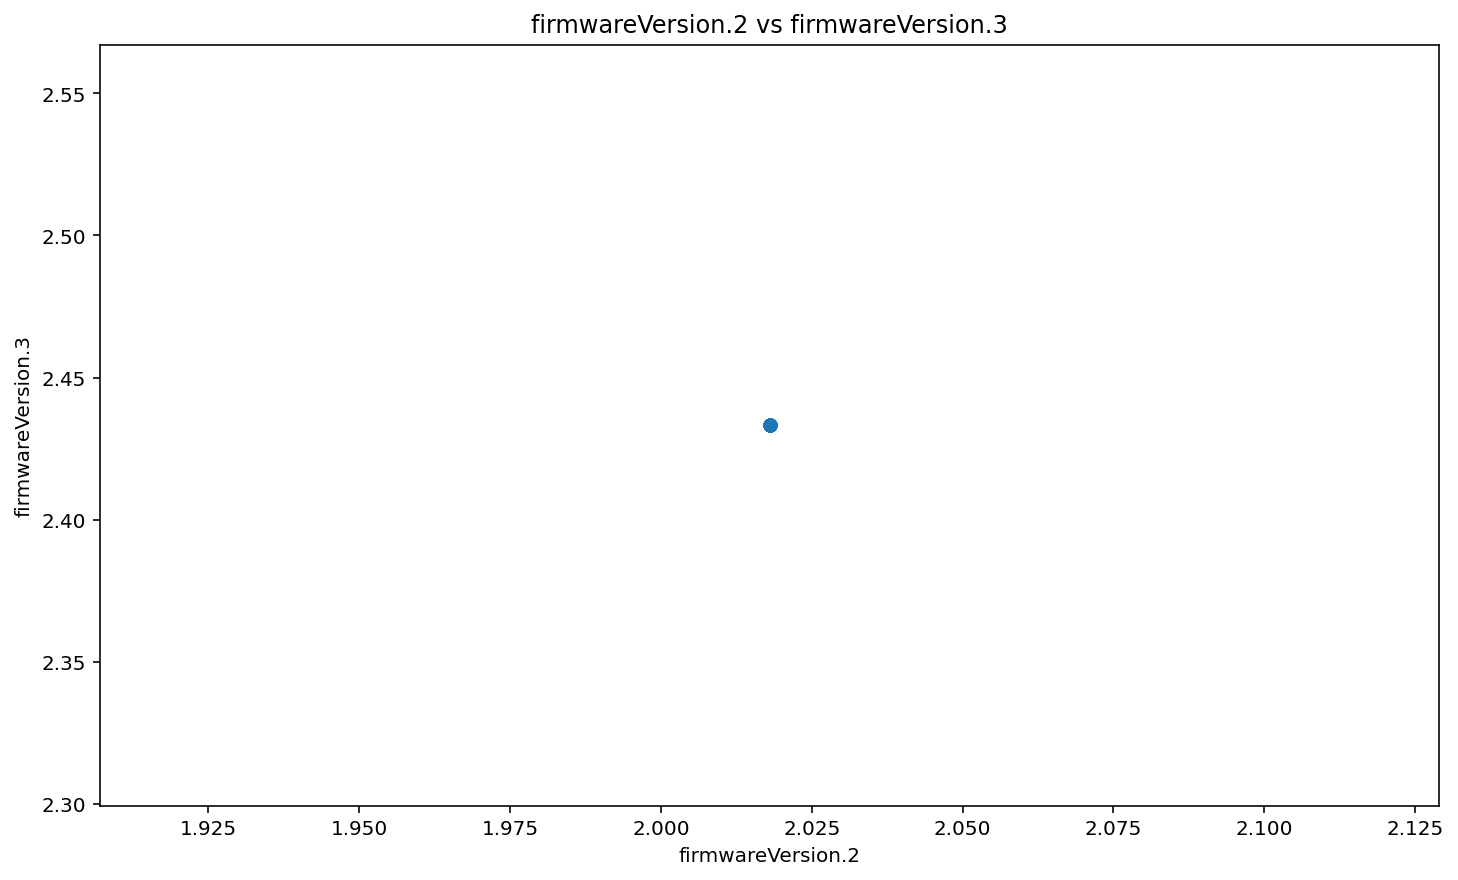

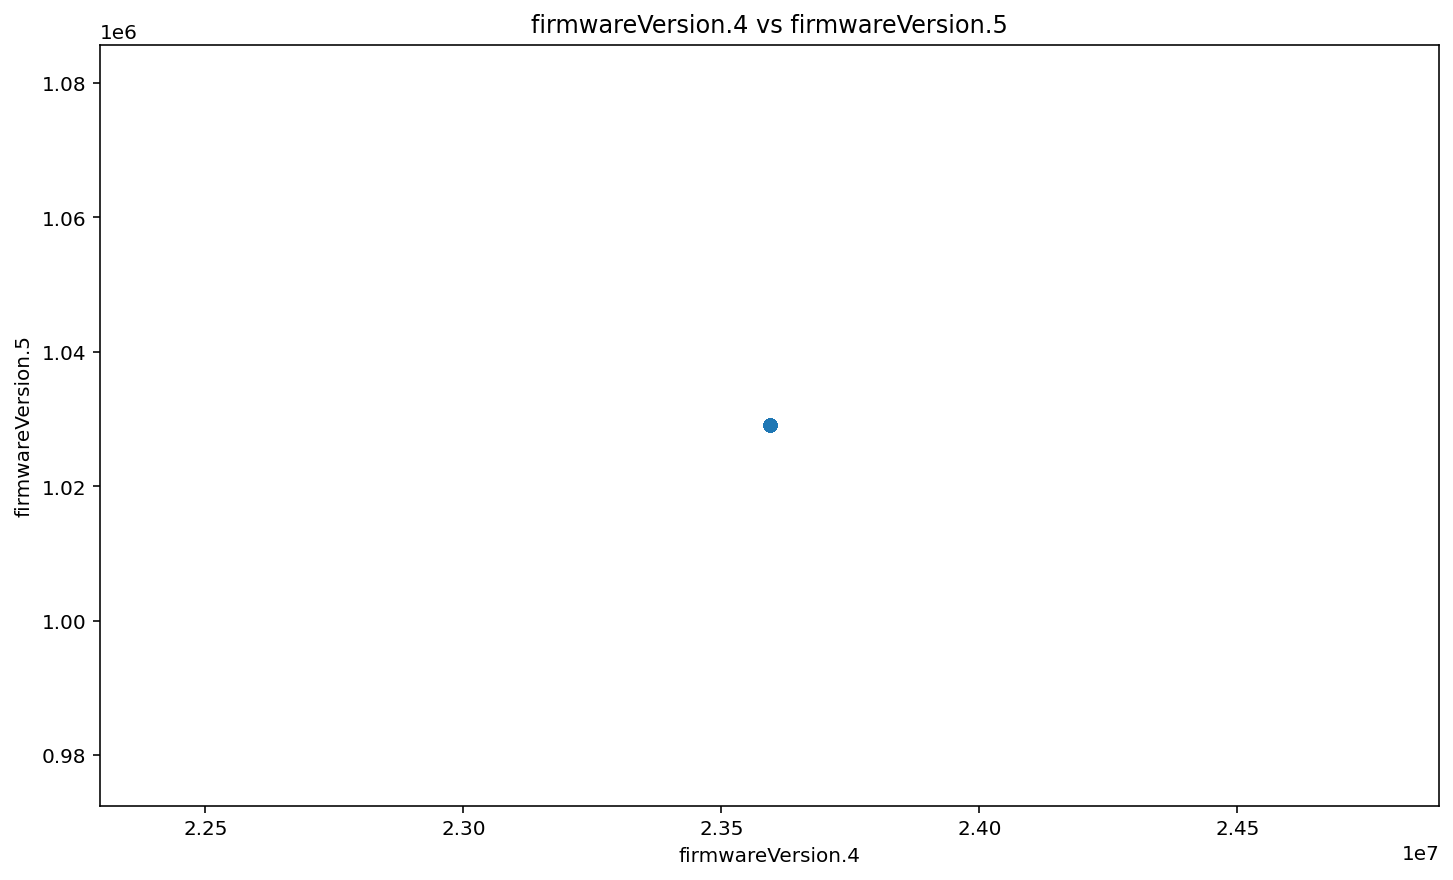

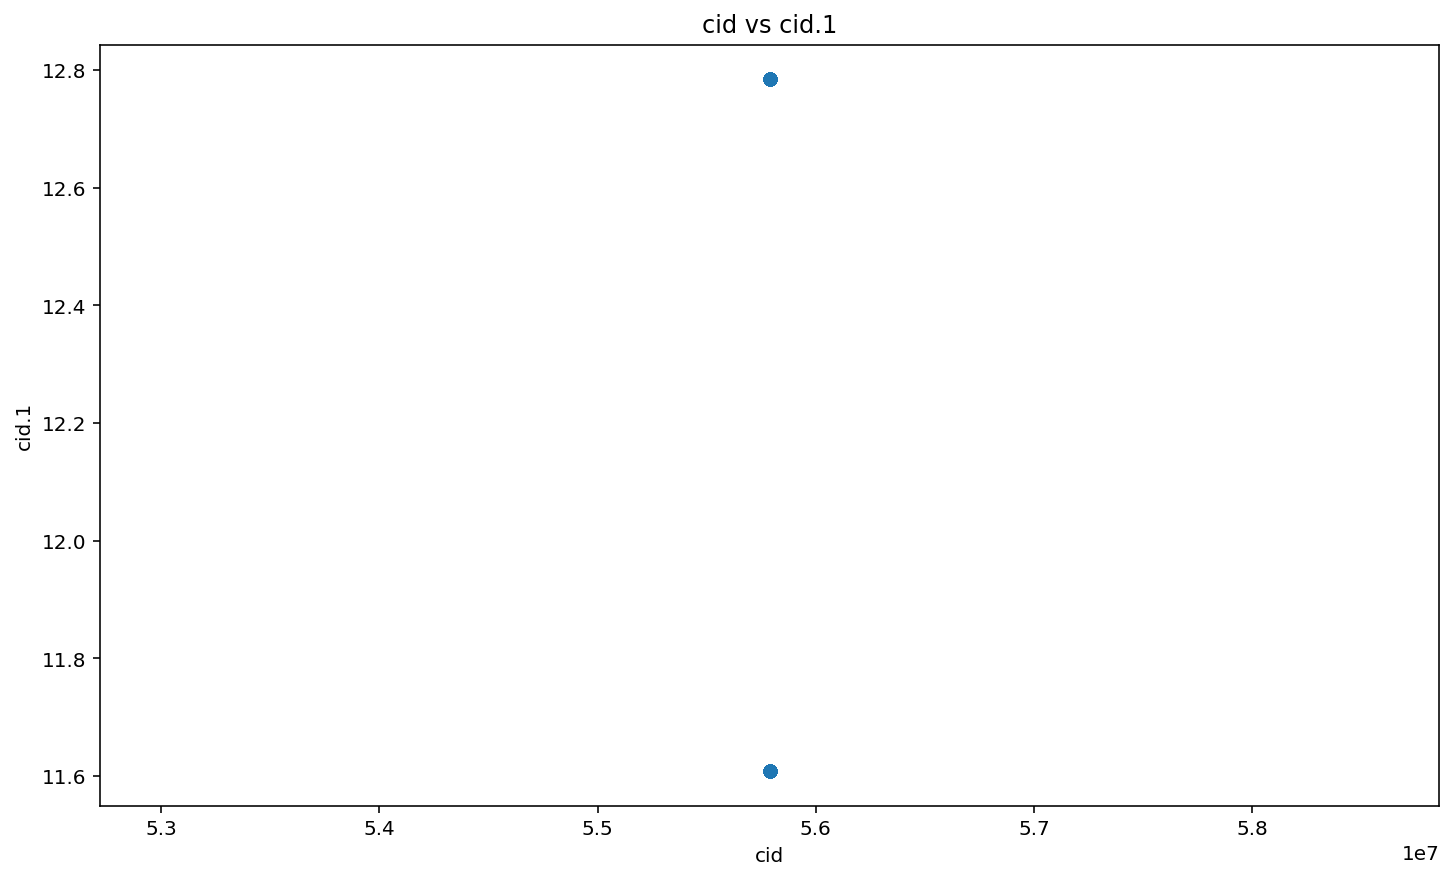

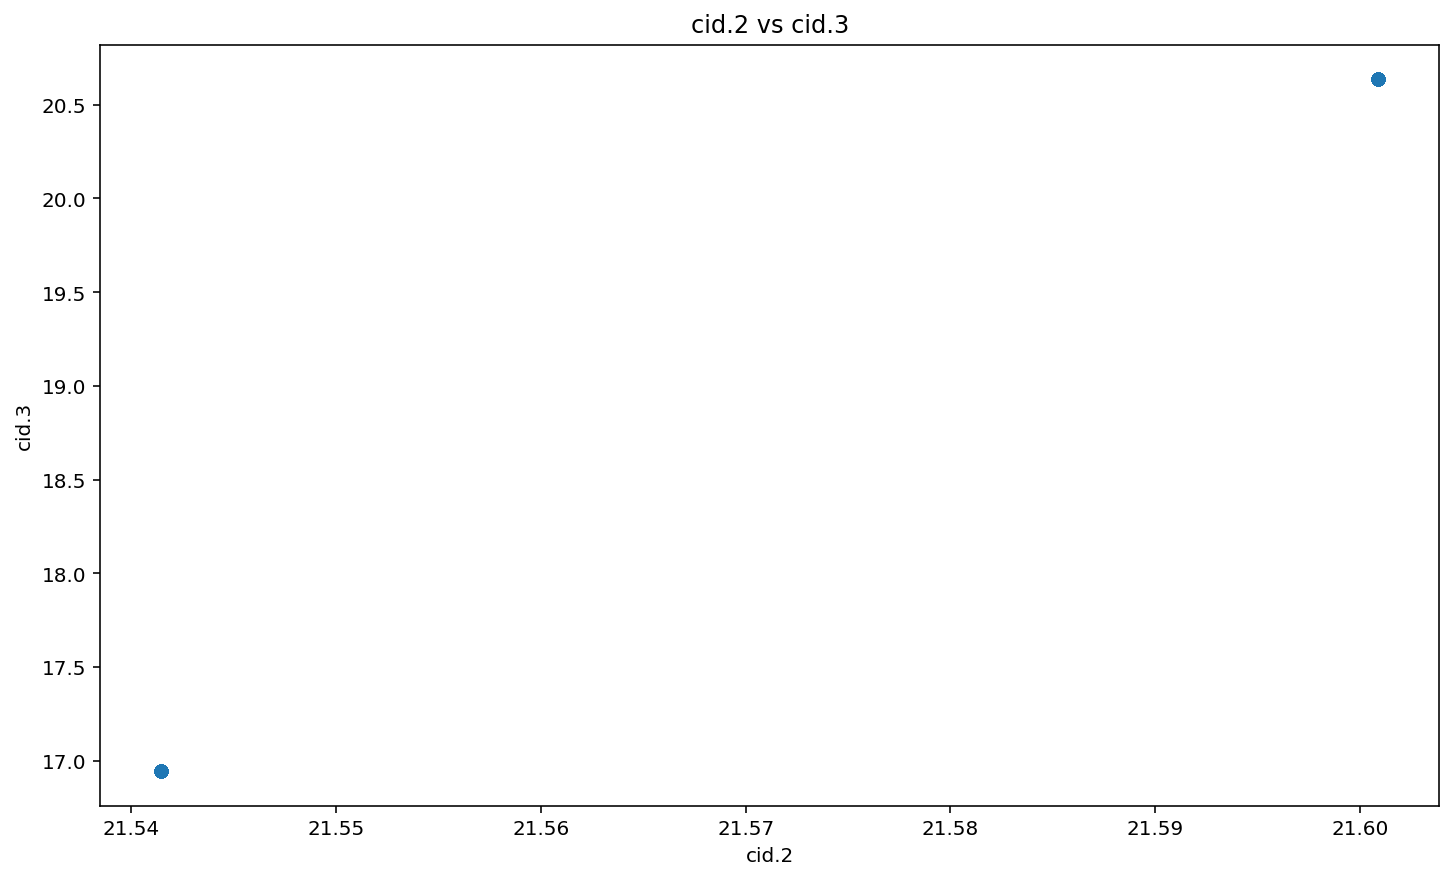

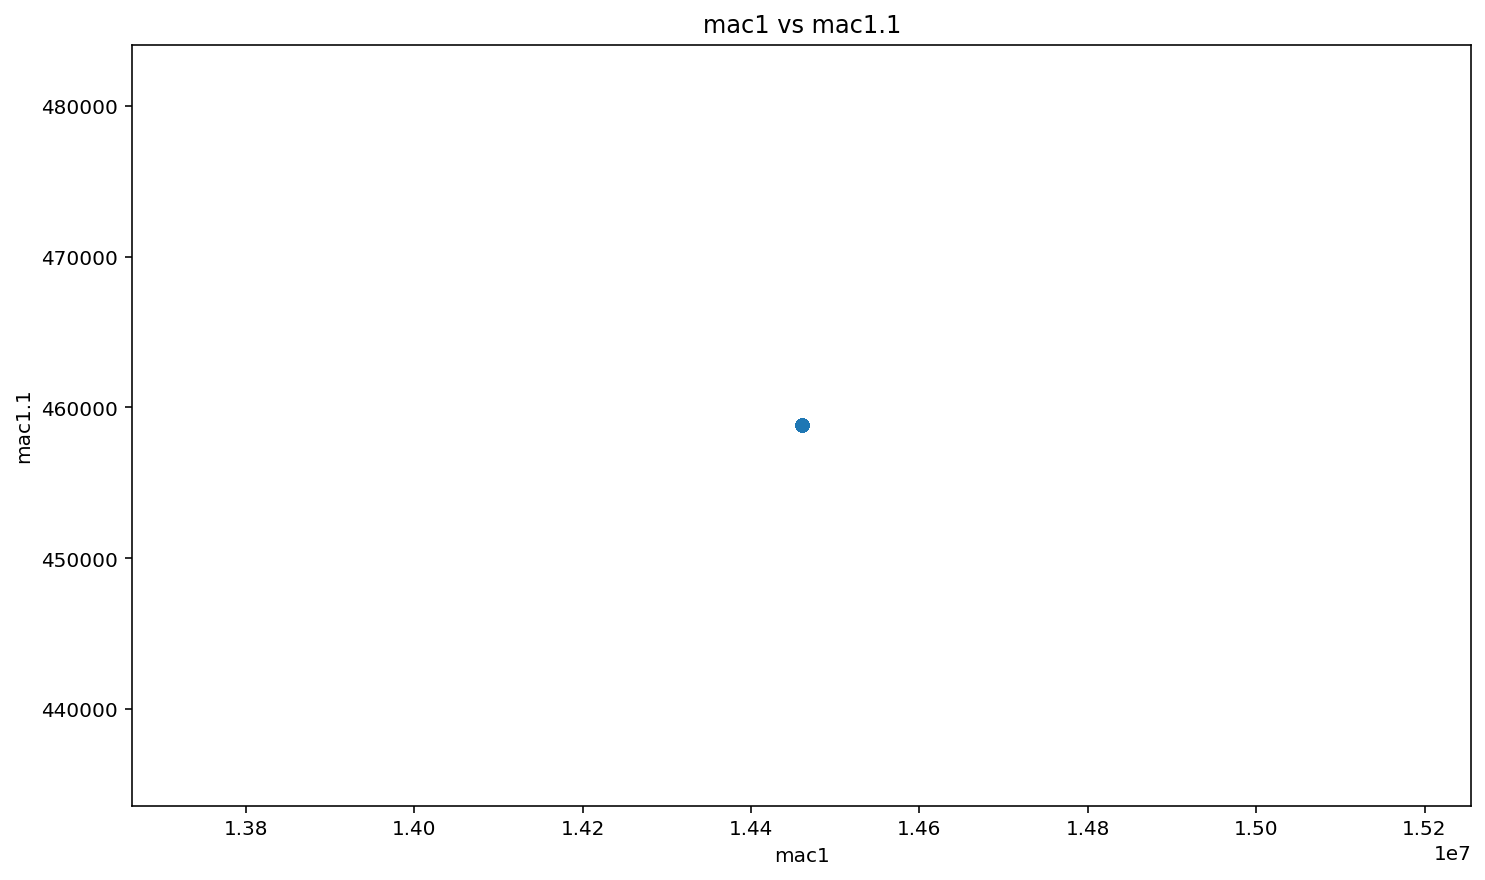

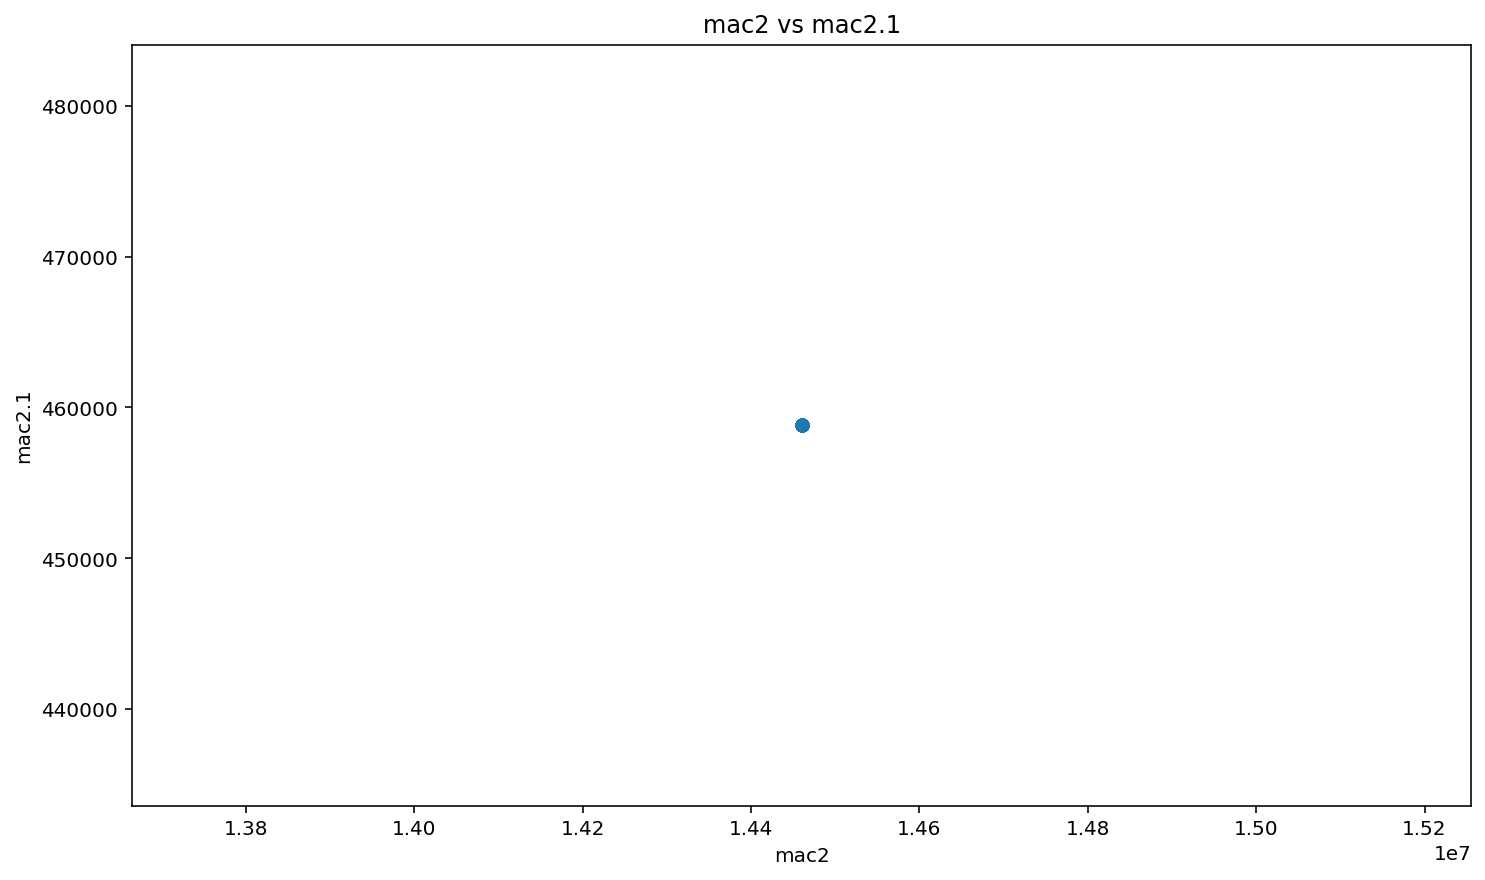

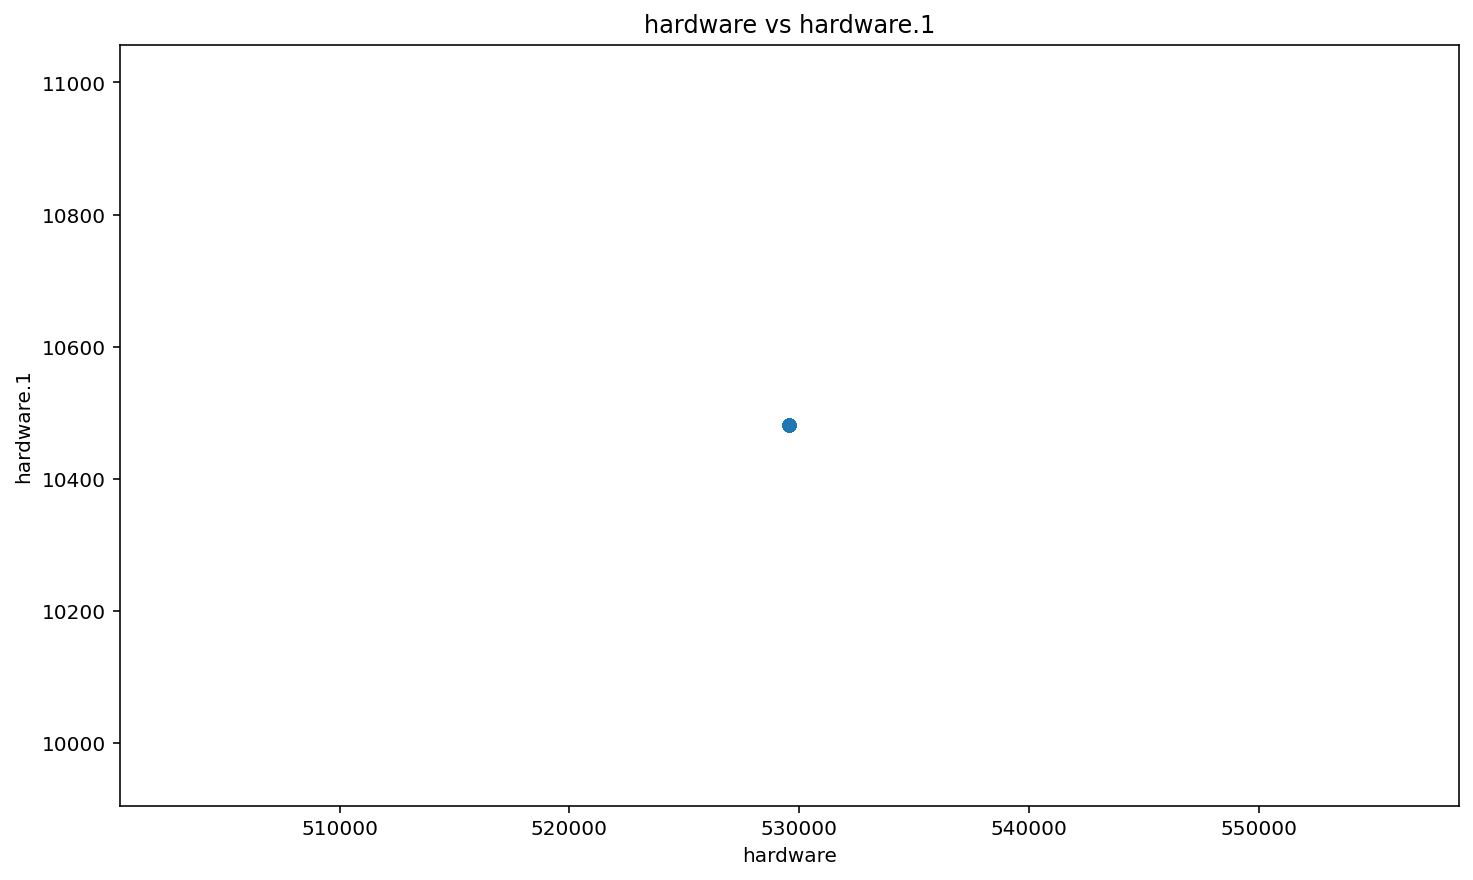

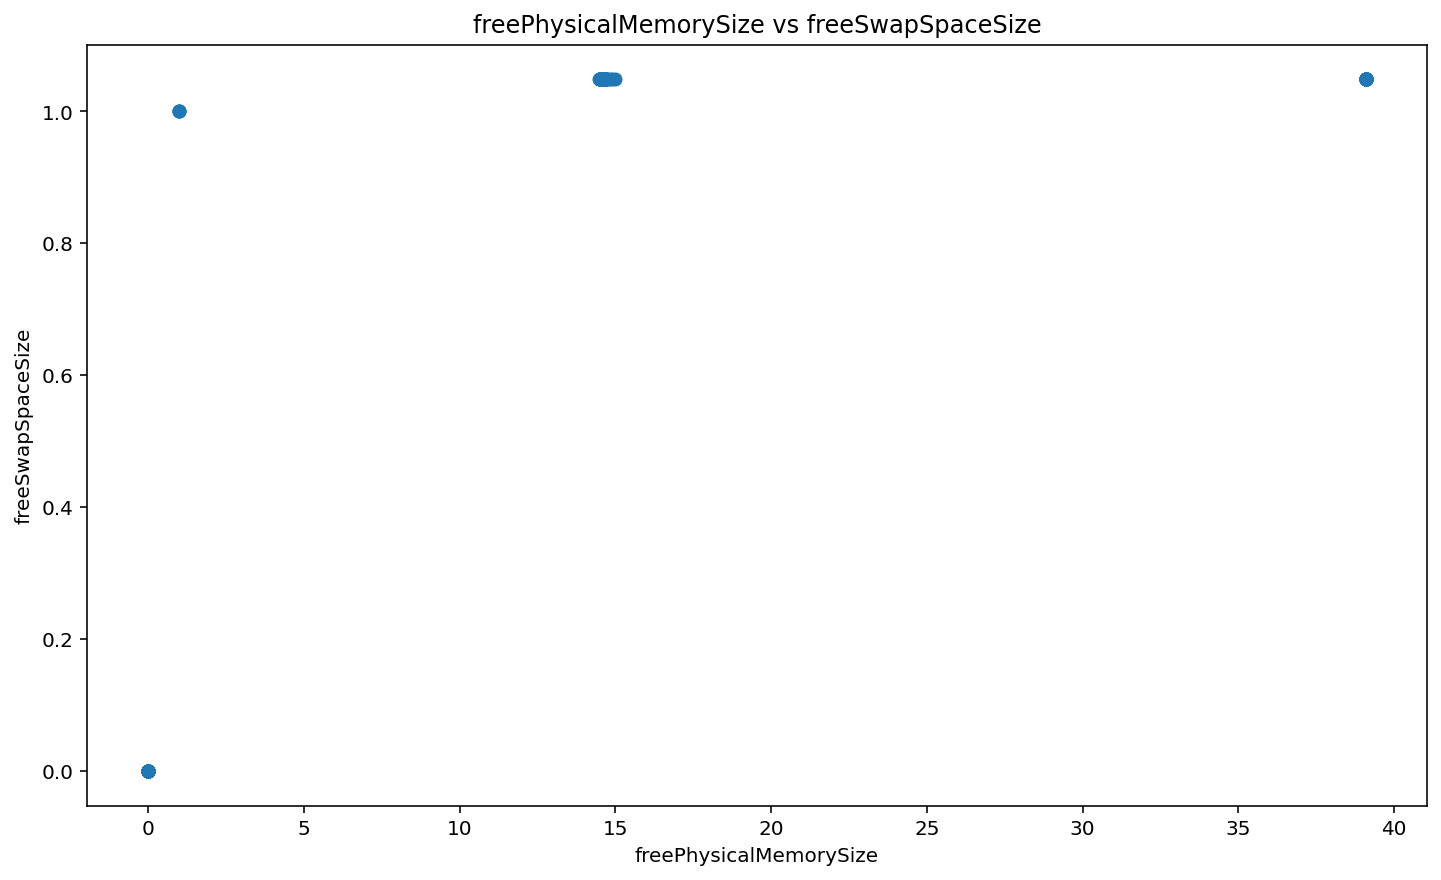

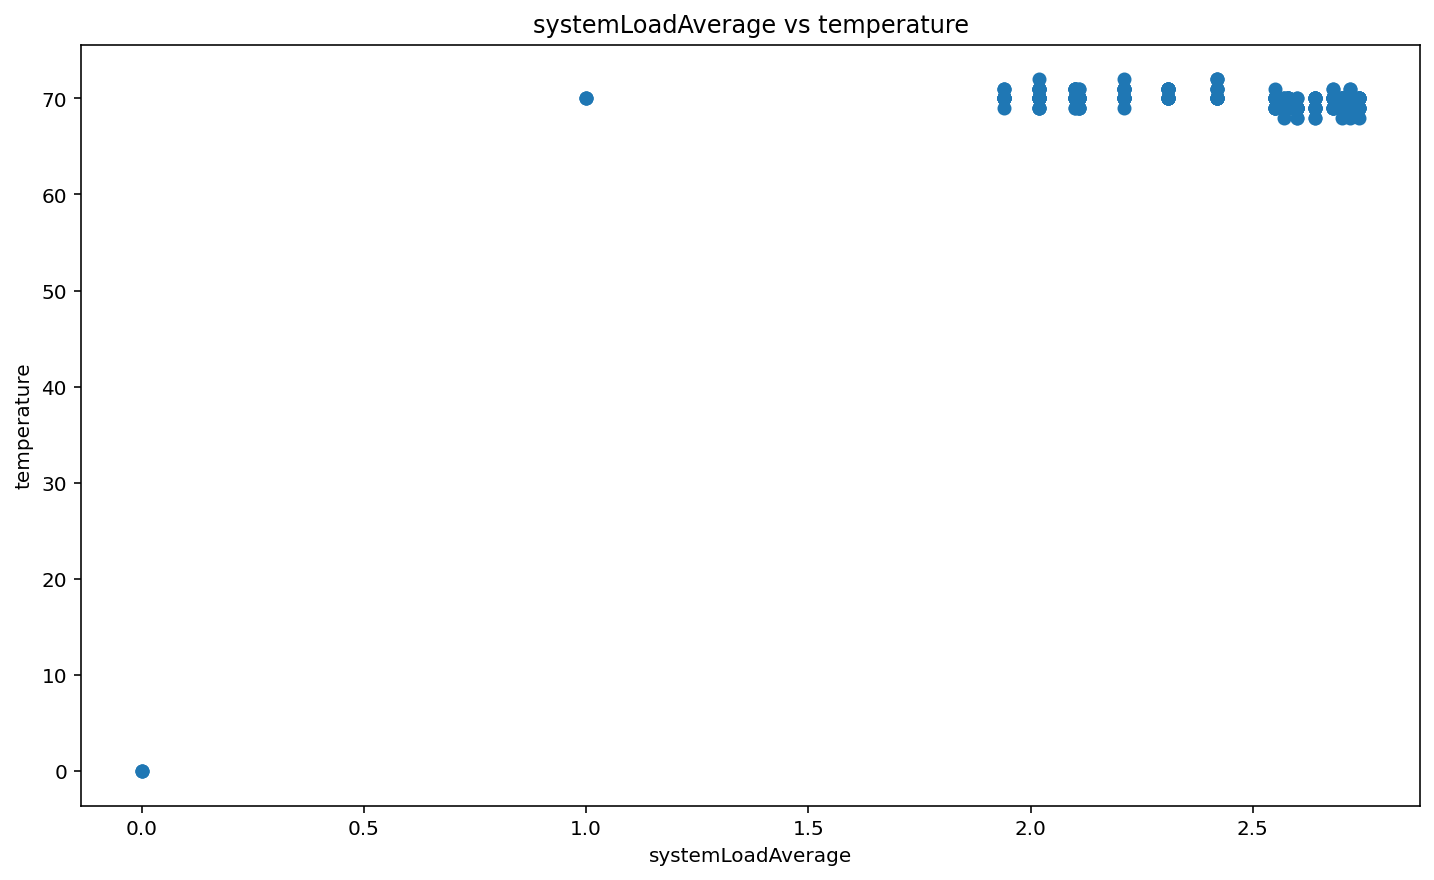

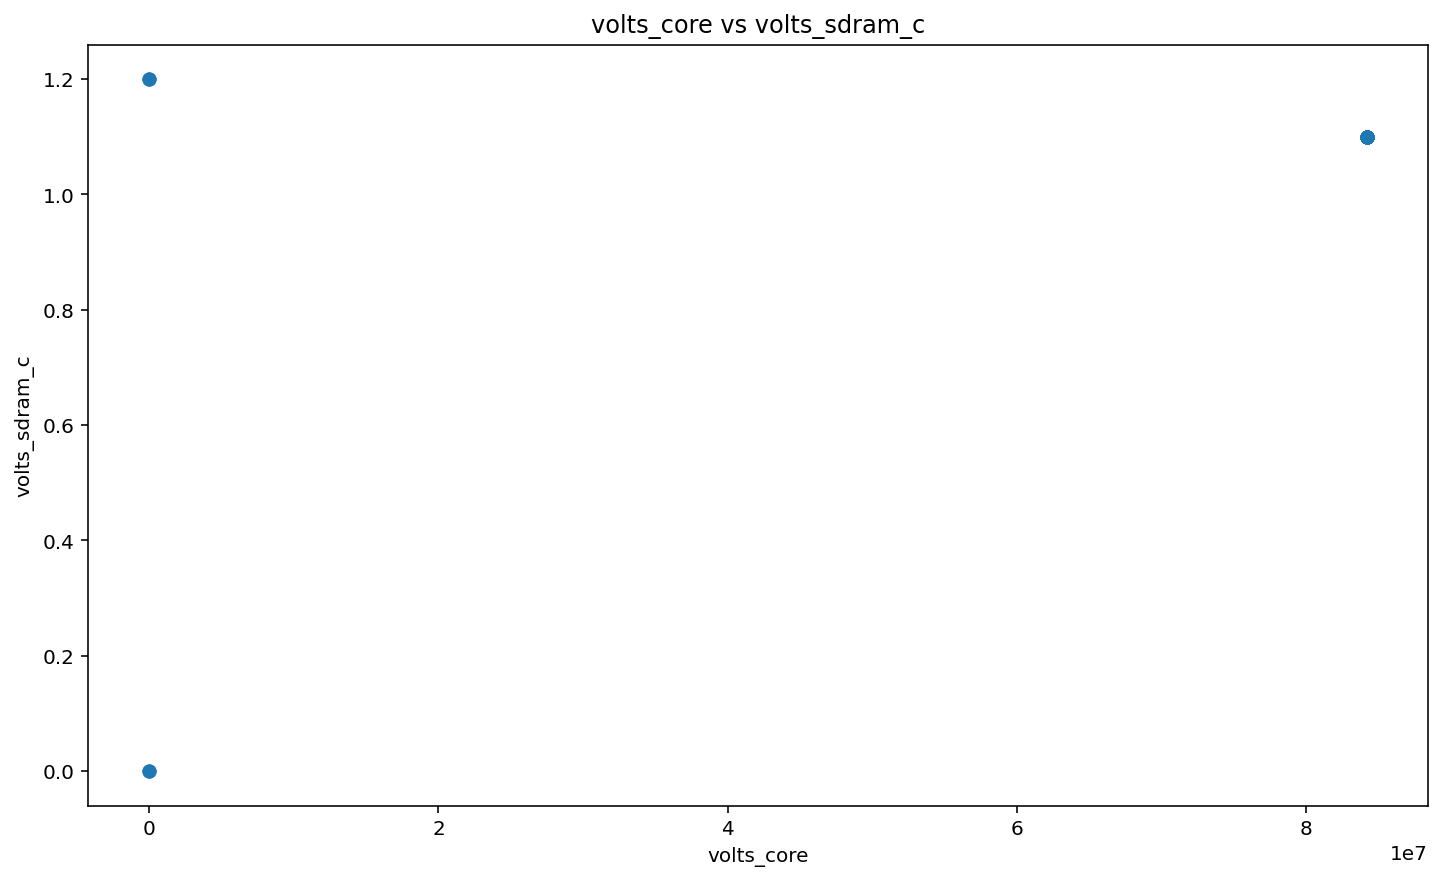

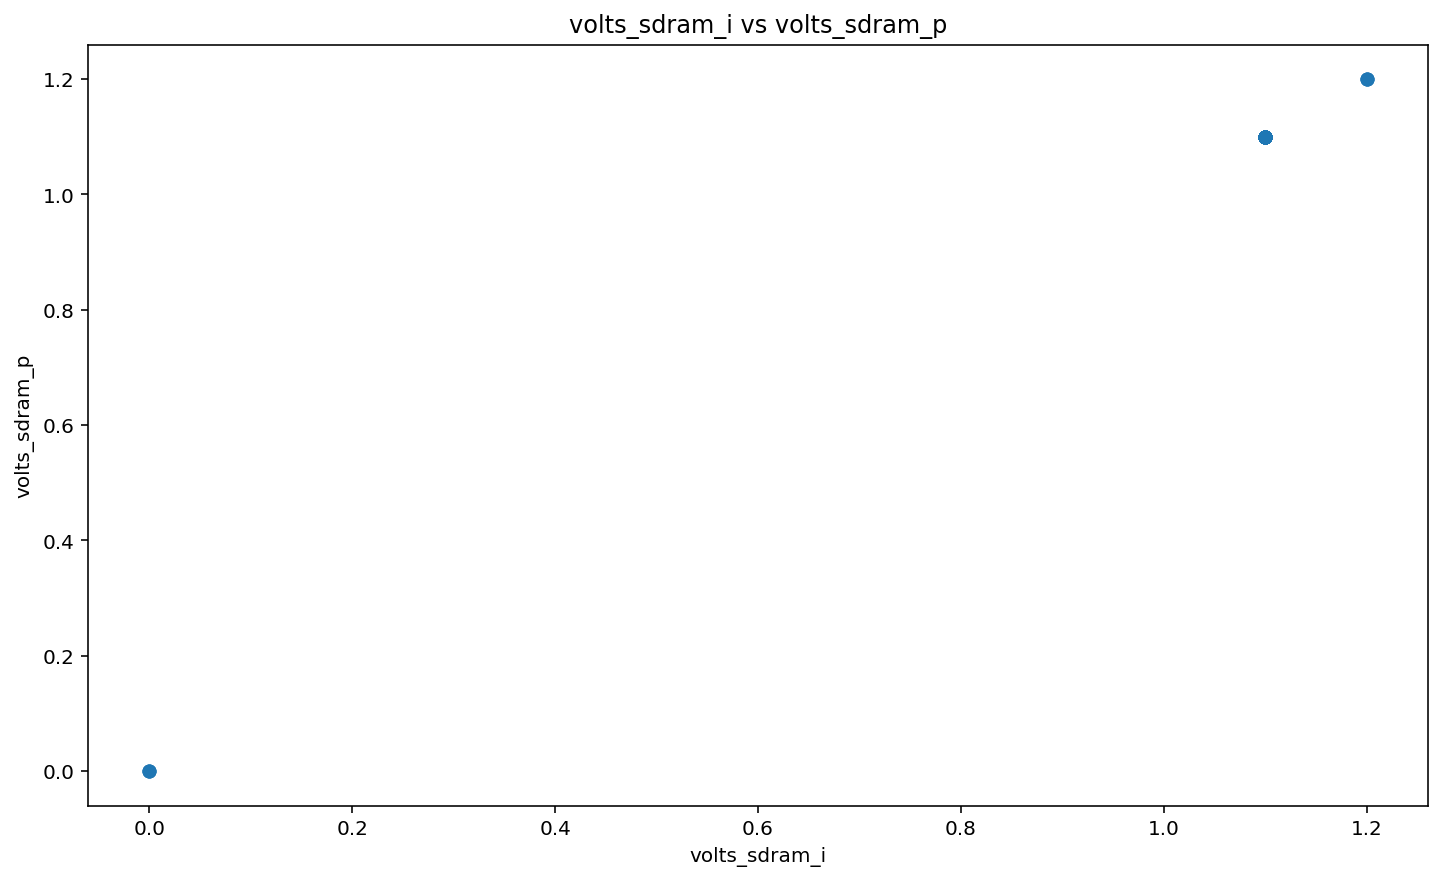

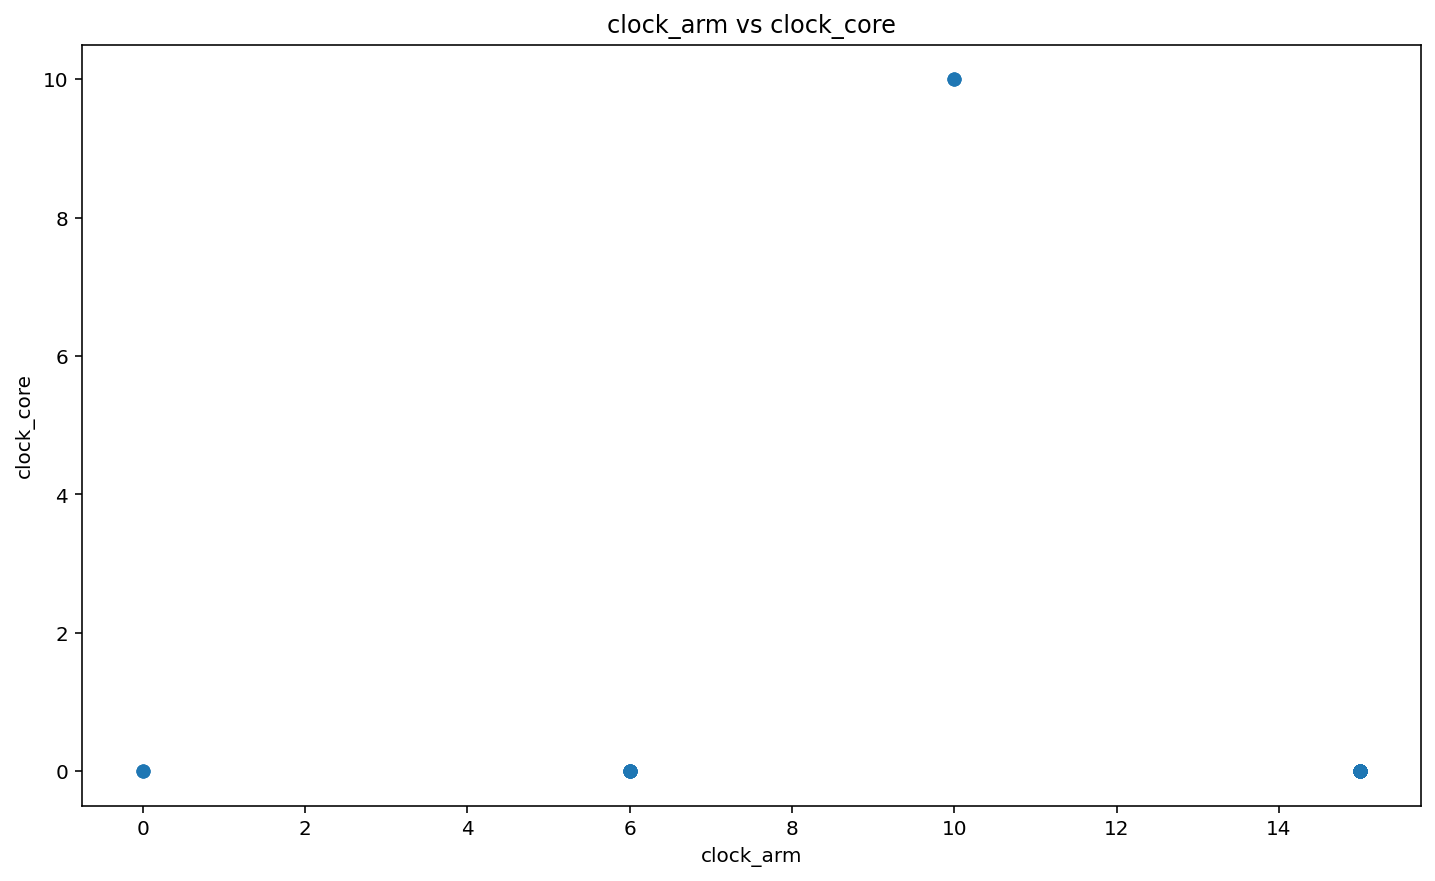

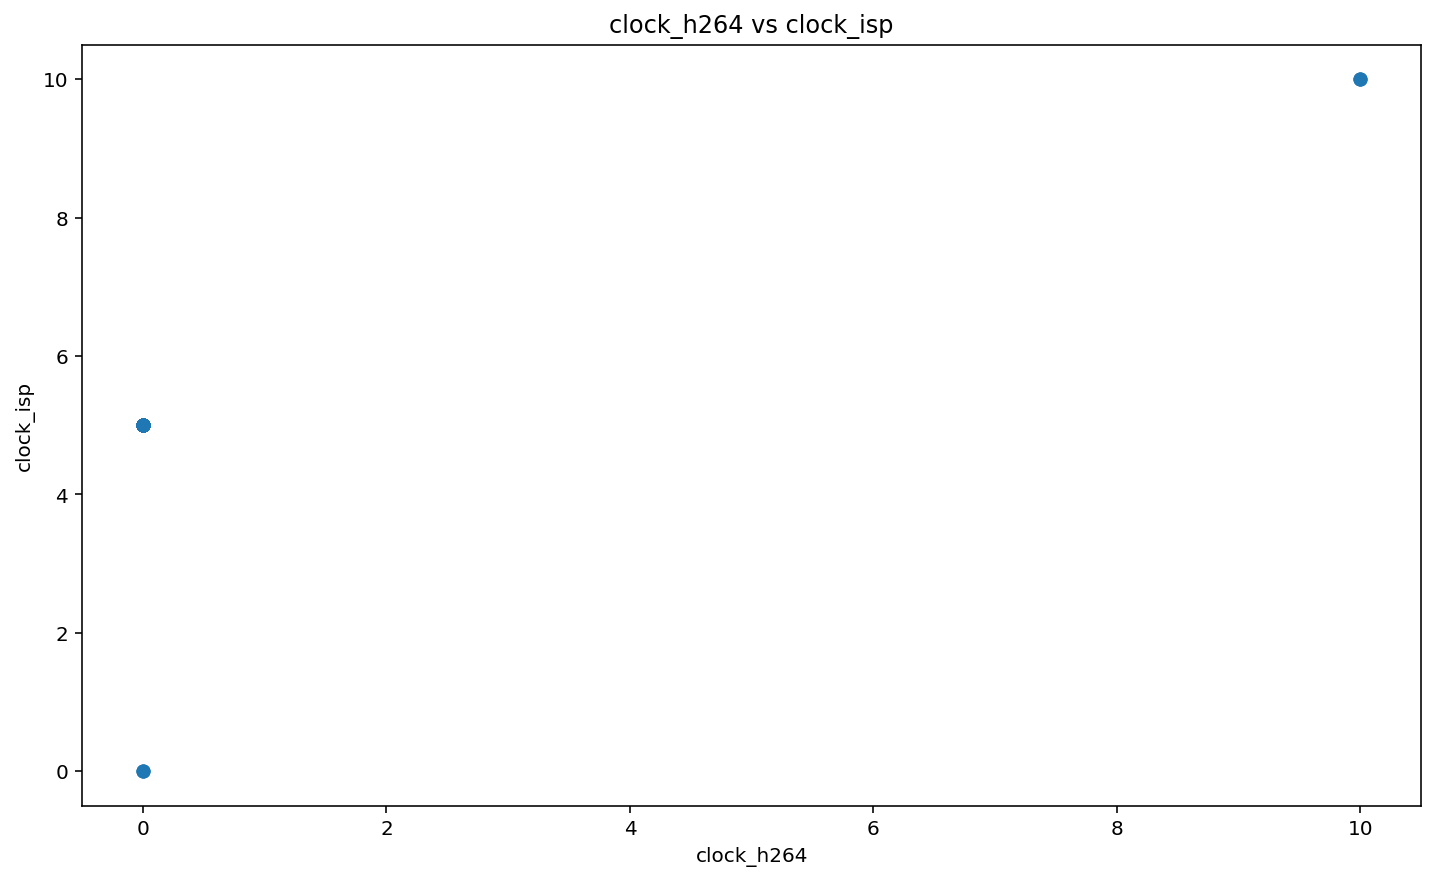

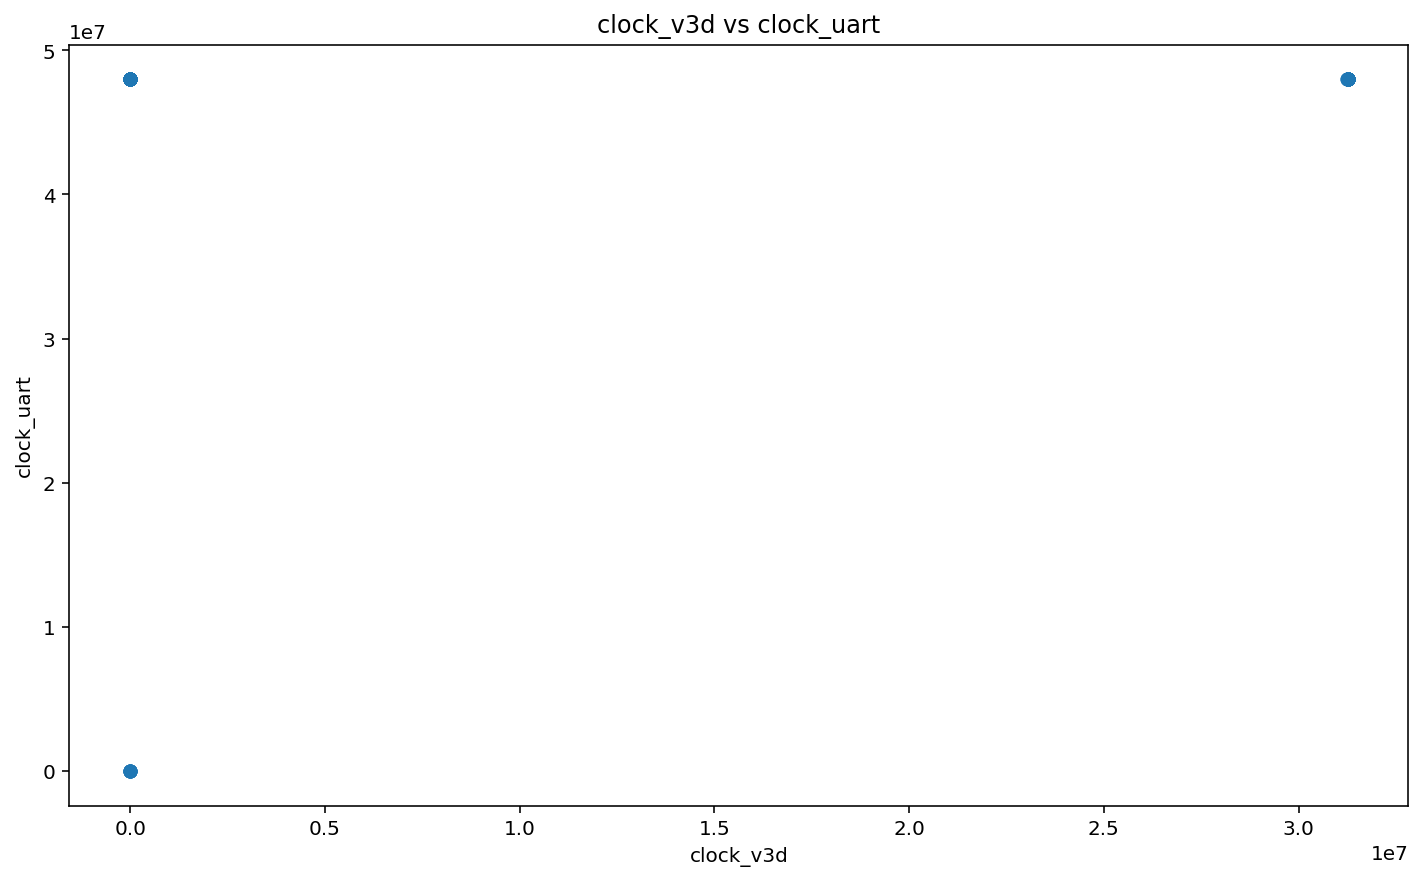

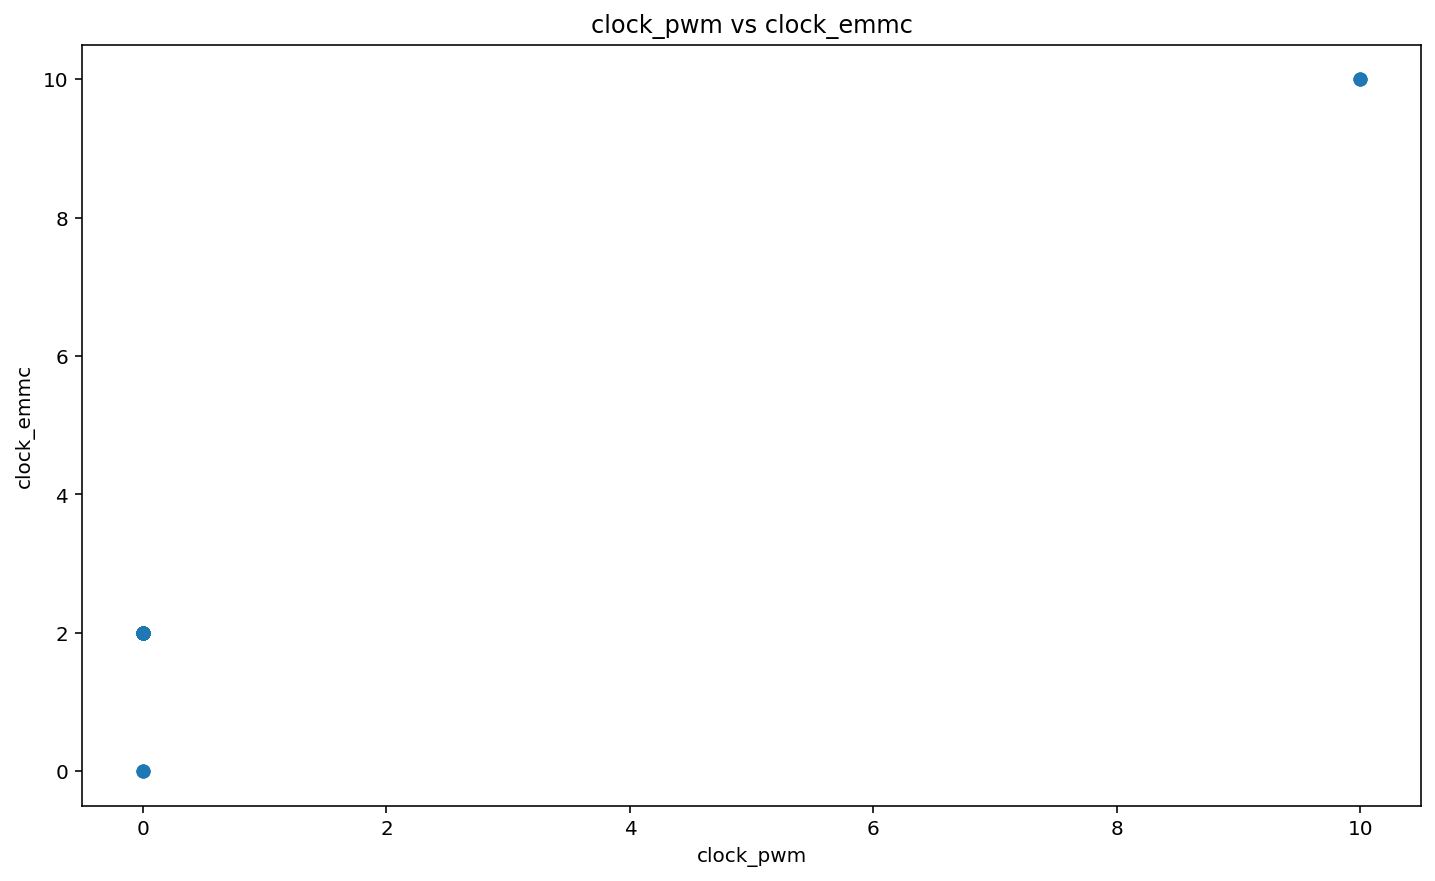

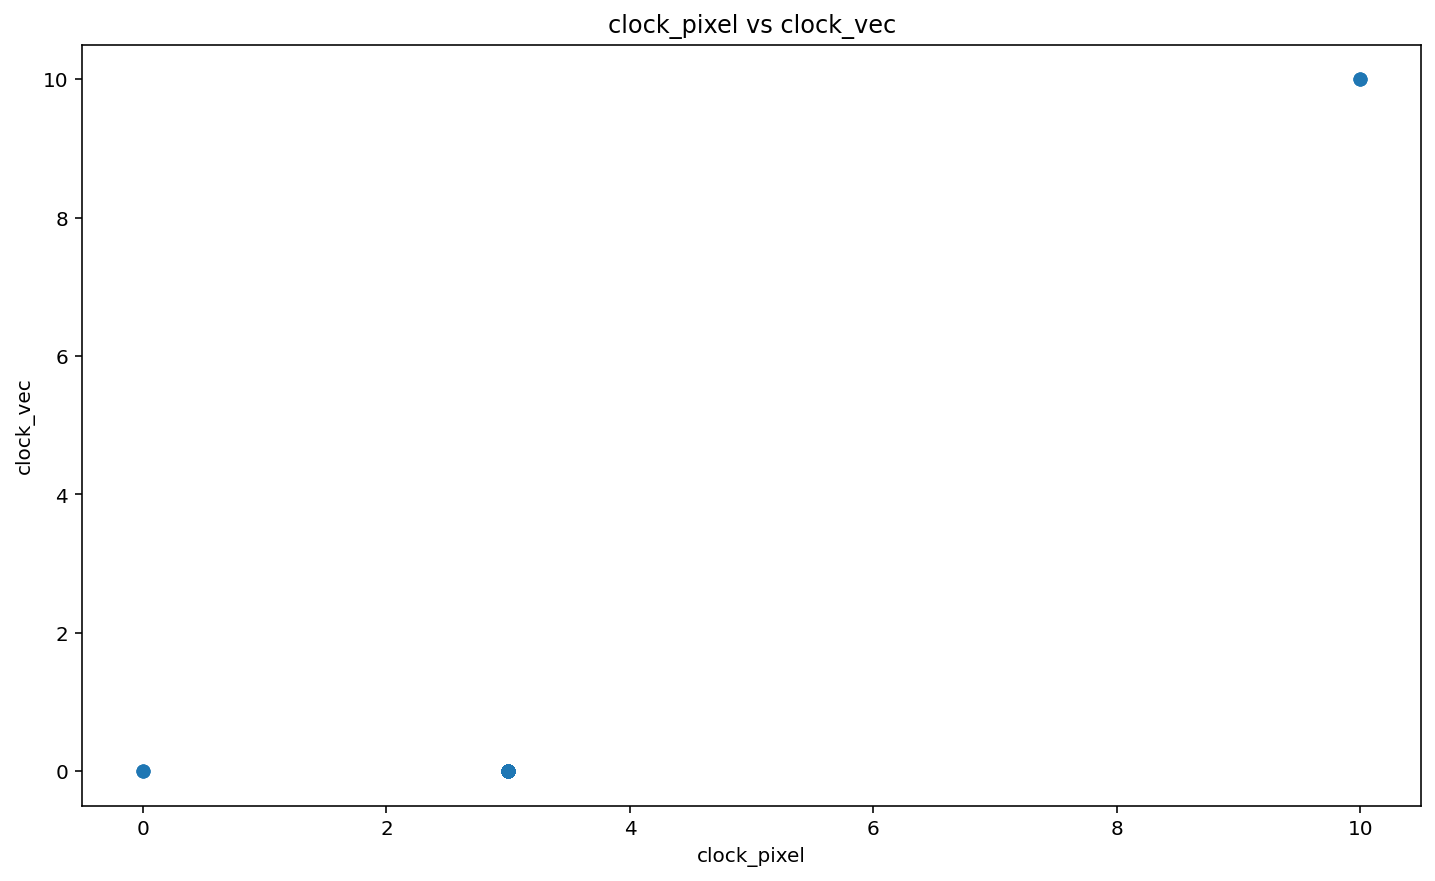

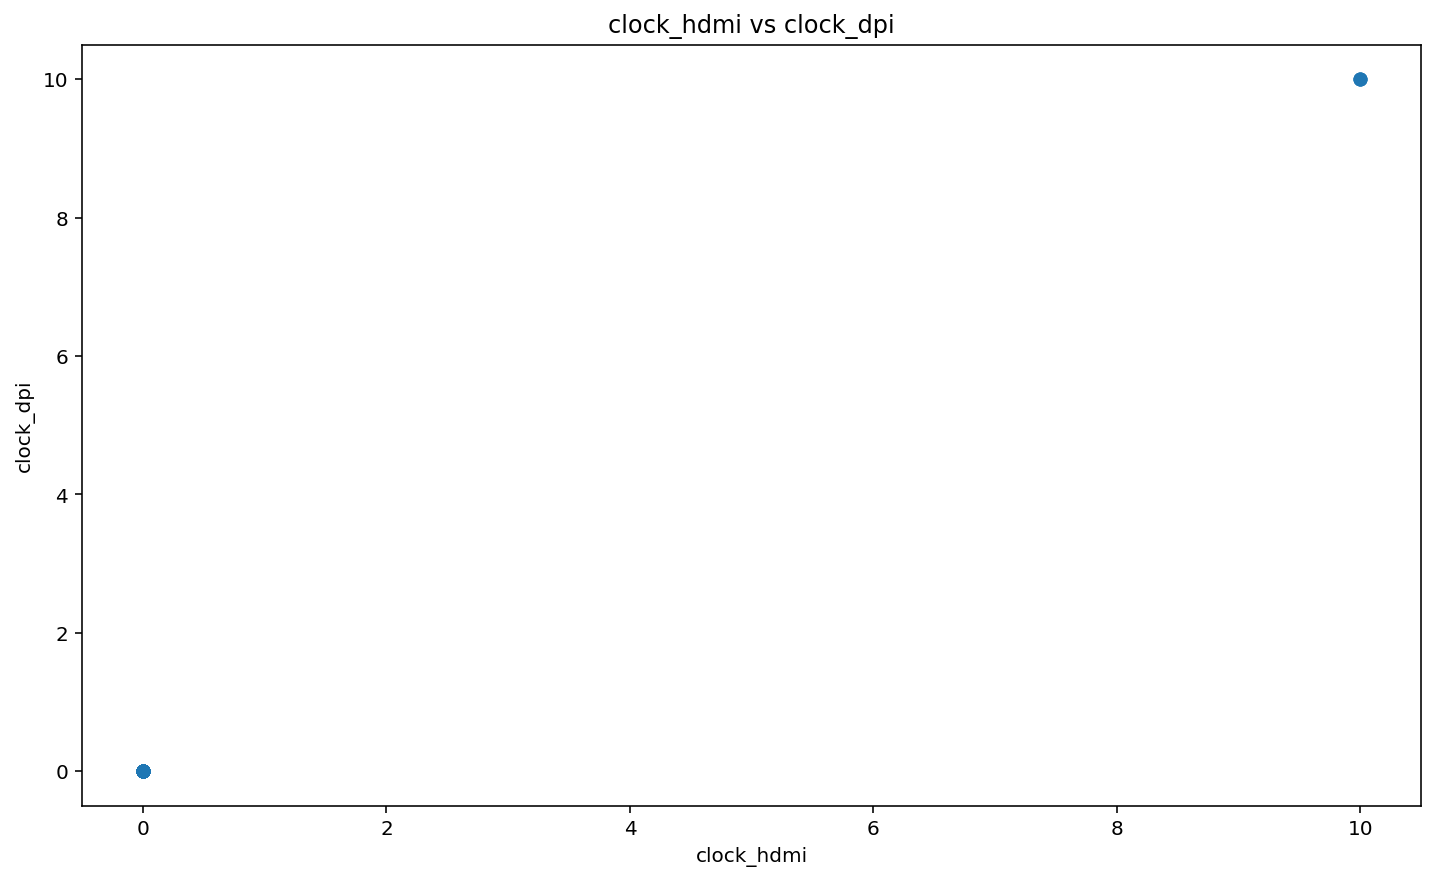

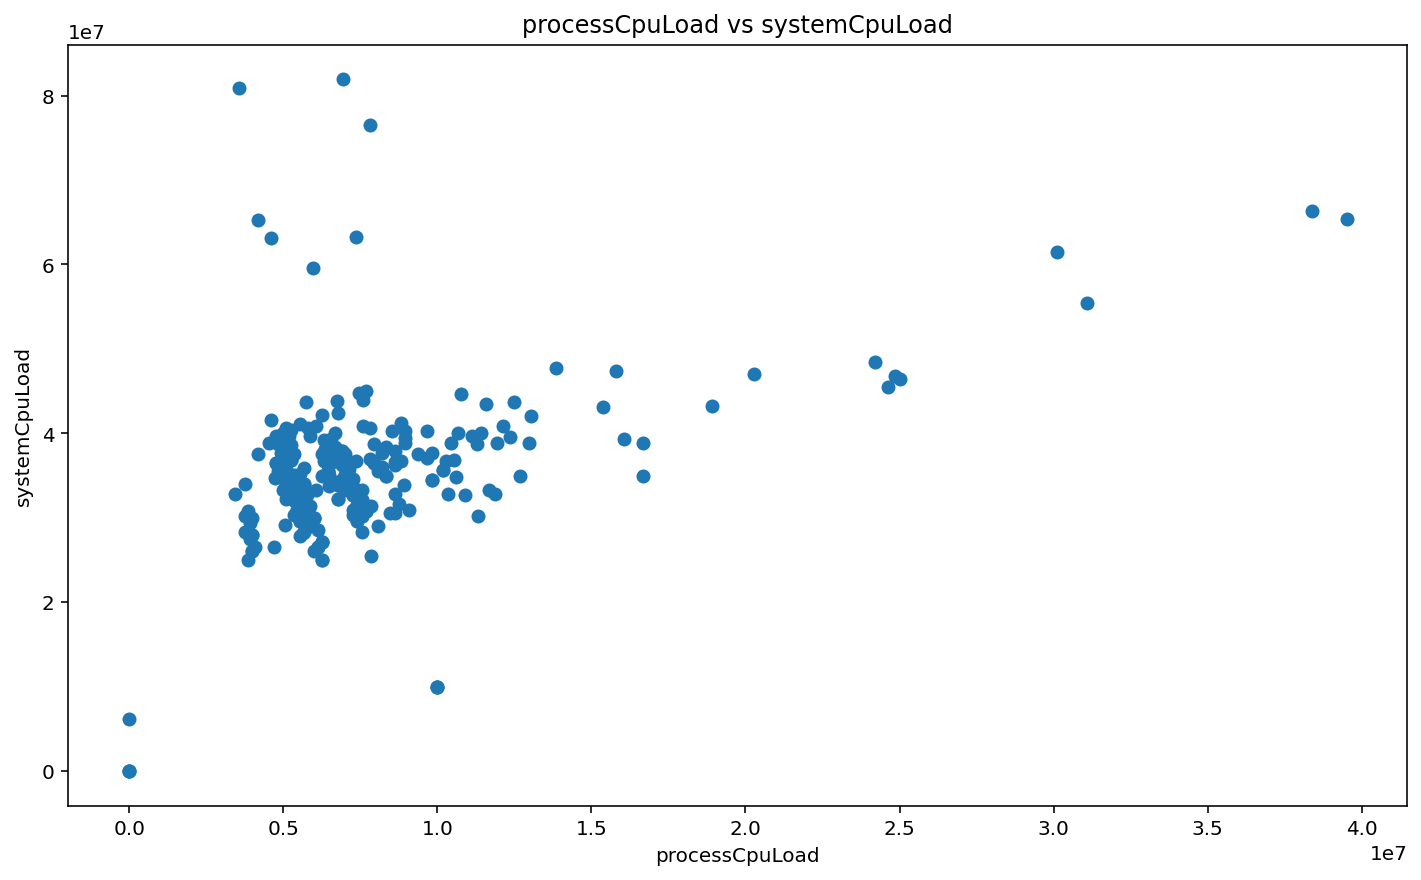

In [122]:
printGraphs(dataList.get('Home501').df)

#### This method shows all of the data points for each dataset on the same graph, along with a regression line to the specified degree.

In [123]:
def printCombinedGraph(data, degree):
    
    df = data.weightedDF
    
    linX = np.linspace(0,max(df['0'].values))
    
    model = calculateModel(df, degree)
        
    plt.plot(df['0'], df['1'], marker='o', linestyle='none', label='')
    
    y_values = model.predict(linX.reshape(-1,1))
    
    coefficient = str(model.steps[1][1].coef_[1:degree+1])
    
    plt.plot(linX, y_values, 'r', label=coefficient)
    plt.legend(loc='upper left')
    plt.title('Regression with degree ' + str(degree))
    plt.show()
    
    plural = ": "
    
    if degree > 1:
        plural = "s: "
    
    print('Coefficient' + plural + coefficient)

### We can see from the below that the dataset we have loaded in has as positive correlation.

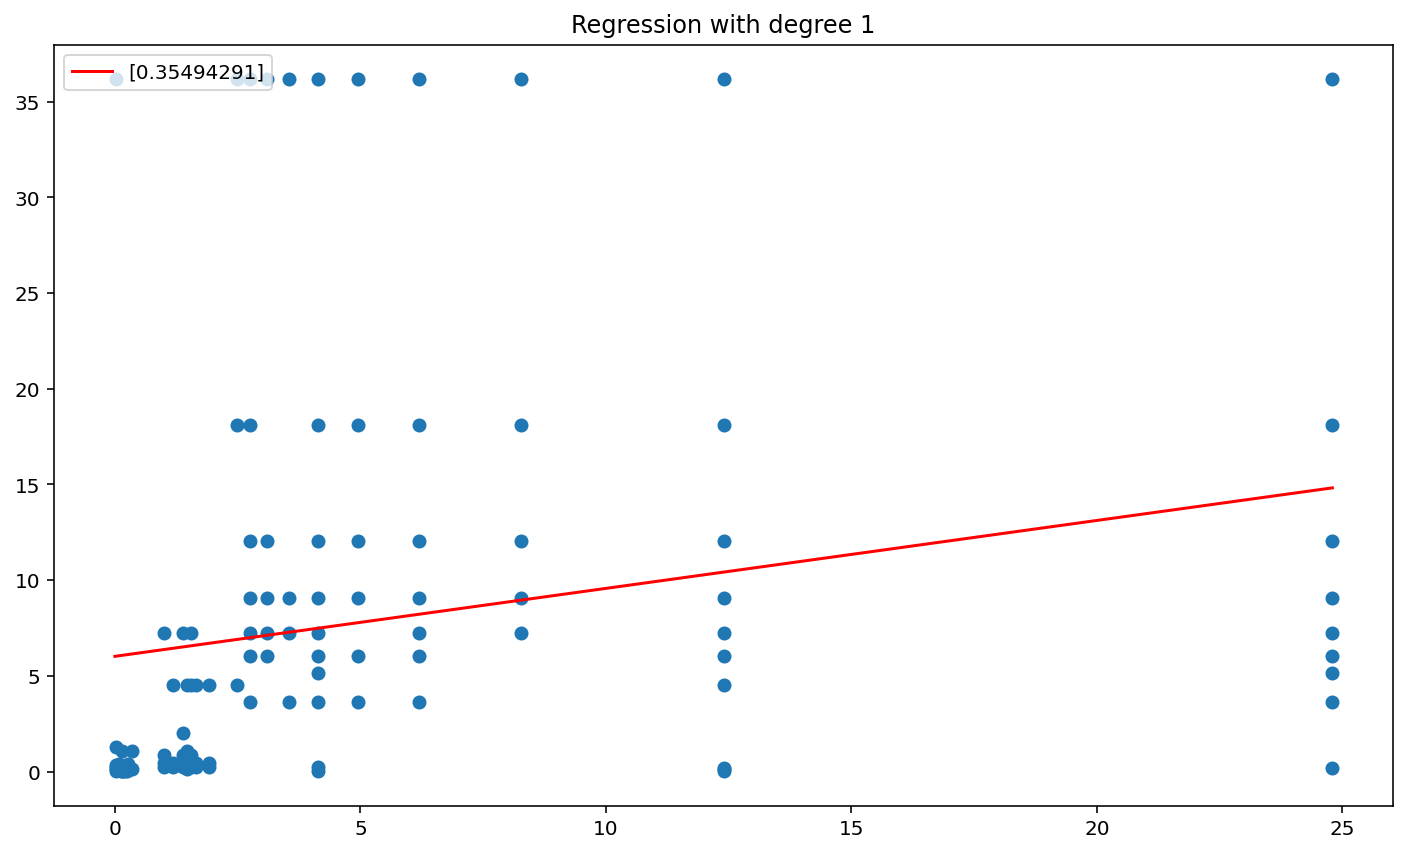

Coefficient: [0.35494291]


In [124]:
printCombinedGraph(dataList.get("Home501"), 1)

# Section 4: Clustering

#### This method clusters the data using K-Means clustering and creates a graph displaying the clusters, with colours representing the groups found.

In [125]:
def clusterPoints(degree):
    
    global dataList
    
    coefs = []
    
    markerMap = []
    
    for data in dataList:
        coefs.append(dataList.get(data).getCoefs(degree))
        if "City" in data:
            markerMap.append('v')
        else:
            markerMap.append('o')
            
    coefs = np.asanyarray(coefs)
    
    km = cluster.KMeans(2)
    km.fit(coefs)

    print(km.get_params())
    
    colourMap = {0 : 'r', 1 : 'b'}
    
    for i in range(len(dataList)):
        if (degree == 2):
            plt.scatter(coefs[i][0], coefs[i][1], c = colourMap.get(km.labels_[i]), marker = markerMap[i])
        else:
            plt.scatter(coefs[i], 1, c = colourMap.get(km.labels_[i]), marker = markerMap[i])
    
    plt.title('Clustering of Coefficients With Formatter ' + list(dataList.keys())[0][-3:-1])
    plt.show()
    
    results = pd.DataFrame()
    
    results['Name'] = list(dataList.keys())
    results['Label'] = list(km.labels_)

    print(results)
    

#### This method automates a significant proportion of the data analysis for us. It loads in the data, clusters it, and displays the results. Therefore by using this method, we are able to call load() and all of the steps to test the validity of each formatting ratio are completed for us.

In [126]:
def load(formater, number):
    
    global dataList
    
    dataList = {}
    
    formater = str(formater)
    
    loadData(('City'+formater), number)
    loadData(('Home'+formater), number)
    
    print('\n')

#### In this section I will be looking at K-Means clustering to see if the coefficients can be easily separated.

#### The data collected from the Raspberry Pi devices had four different formatting options: 50% variable data, 60%, 70%, and 80%. Below we can see data collected using all of the formatting options, and how each formatting option performs in a clustering scenario. The different shapes of the points represent the actual devices that the coefficients belong to, with the colours showing the predicted identities.

load() loads in 50% variable datasets, 3 from home, and 3 from city.

clusterpoints() clusters the data using 1 coefficient.

Loaded 3 City50


Loaded 3 Home50


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


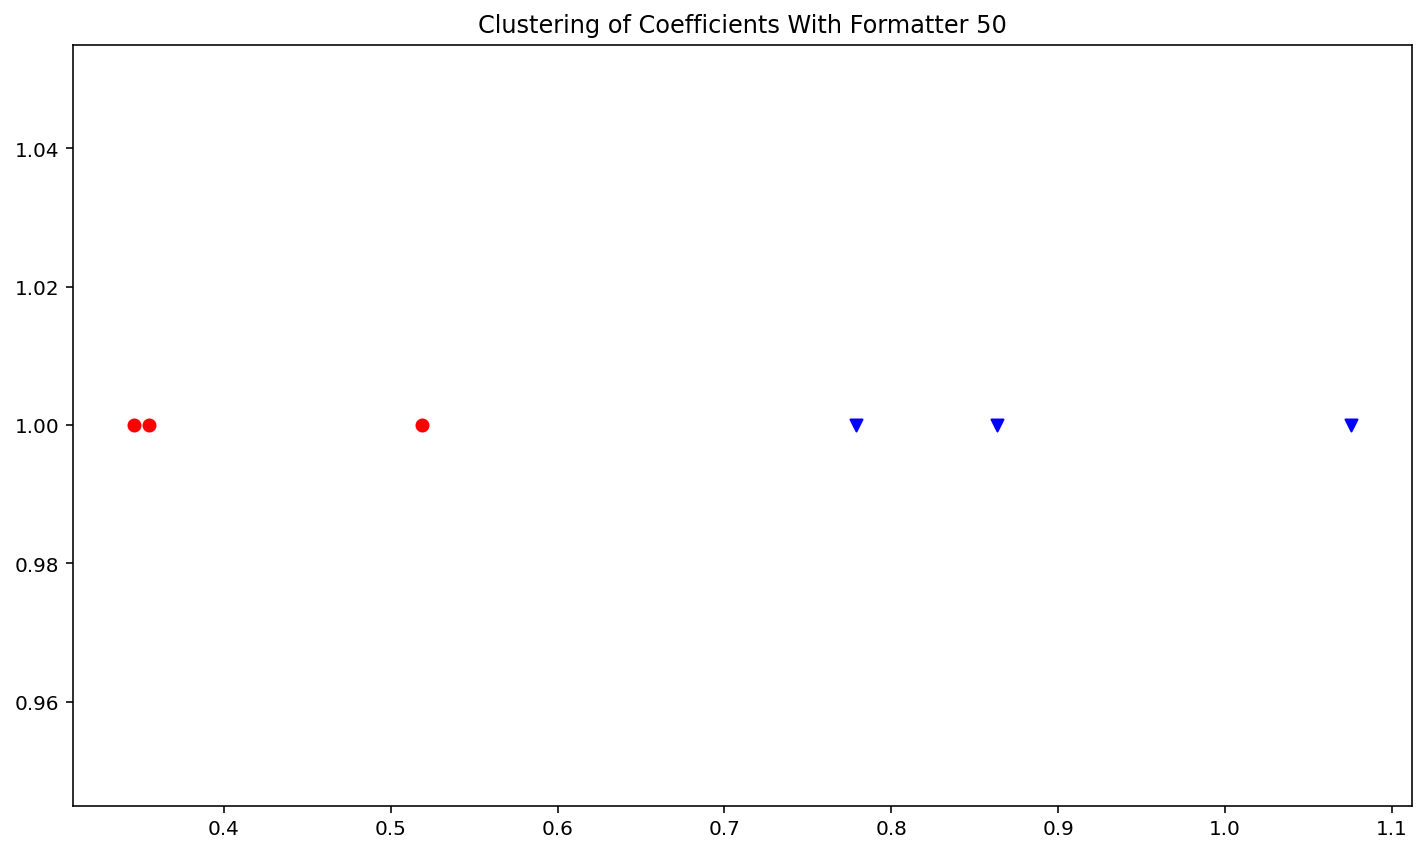

      Name  Label
0  City501      1
1  City502      1
2  City503      1
3  Home501      0
4  Home502      0
5  Home503      0


In [127]:
load(50,3)
clusterPoints(1)

### From the graph above we can see that the clustering algorithm has accurately predicted the separation between these devices. However, the coefficients generated from the 50% variable data formatter produce coefficents with a large range.

Loaded 3 City60
Loaded 3 Home60


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


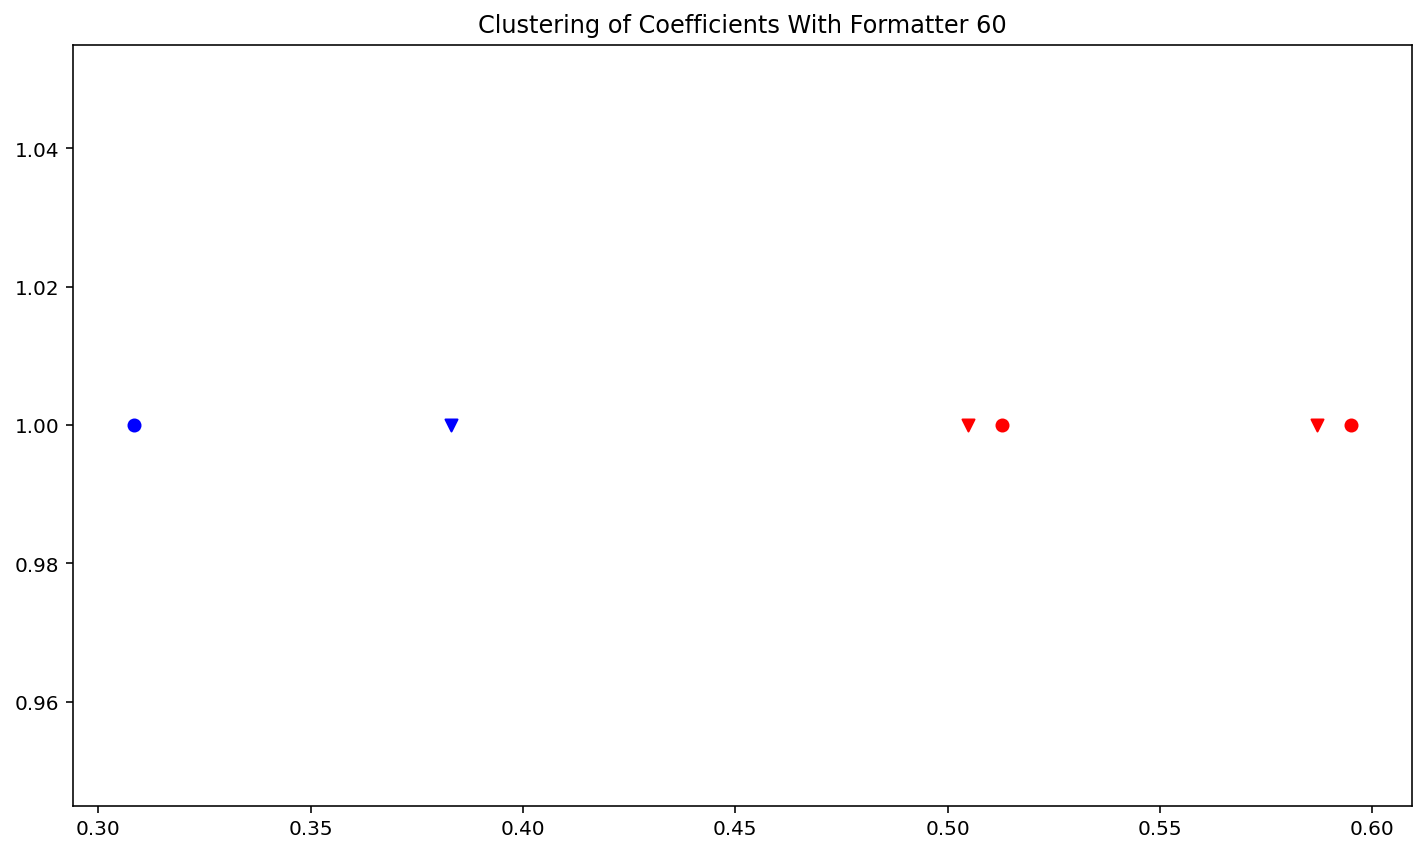

      Name  Label
0  City601      0
1  City602      0
2  City603      1
3  Home601      1
4  Home602      0
5  Home603      0


In [128]:
load(60,3)
clusterPoints(1)

Loaded 3 City70


Loaded 3 Home70




{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


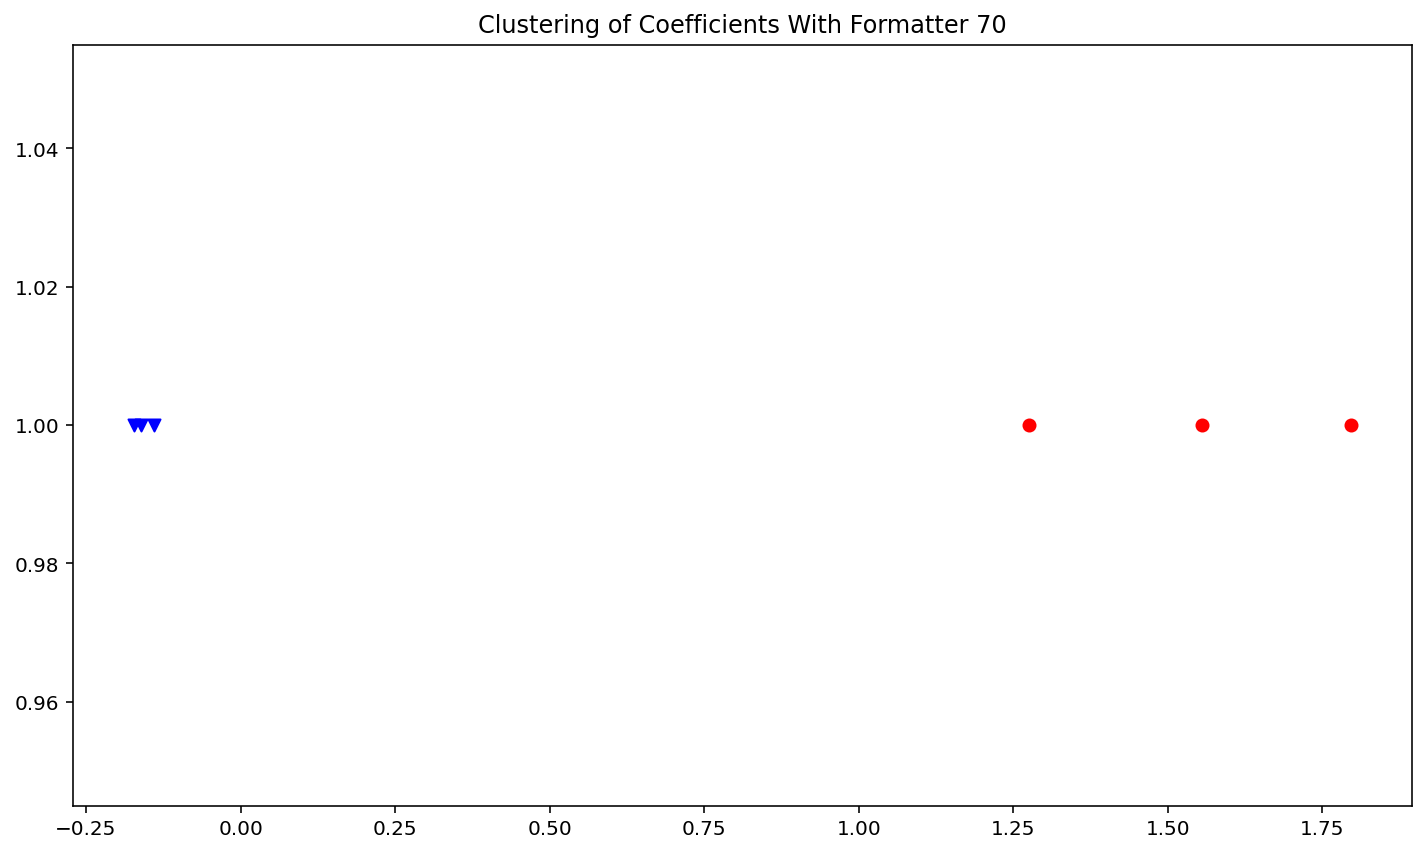

      Name  Label
0  City701      1
1  City702      1
2  City703      1
3  Home701      0
4  Home702      0
5  Home703      0


In [129]:
load(70,3)
clusterPoints(1)


### This formatter has produces coefficients which are accurately classified, and also with a small intra-sample range

Loaded 3 City80


Loaded 3 Home80




{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


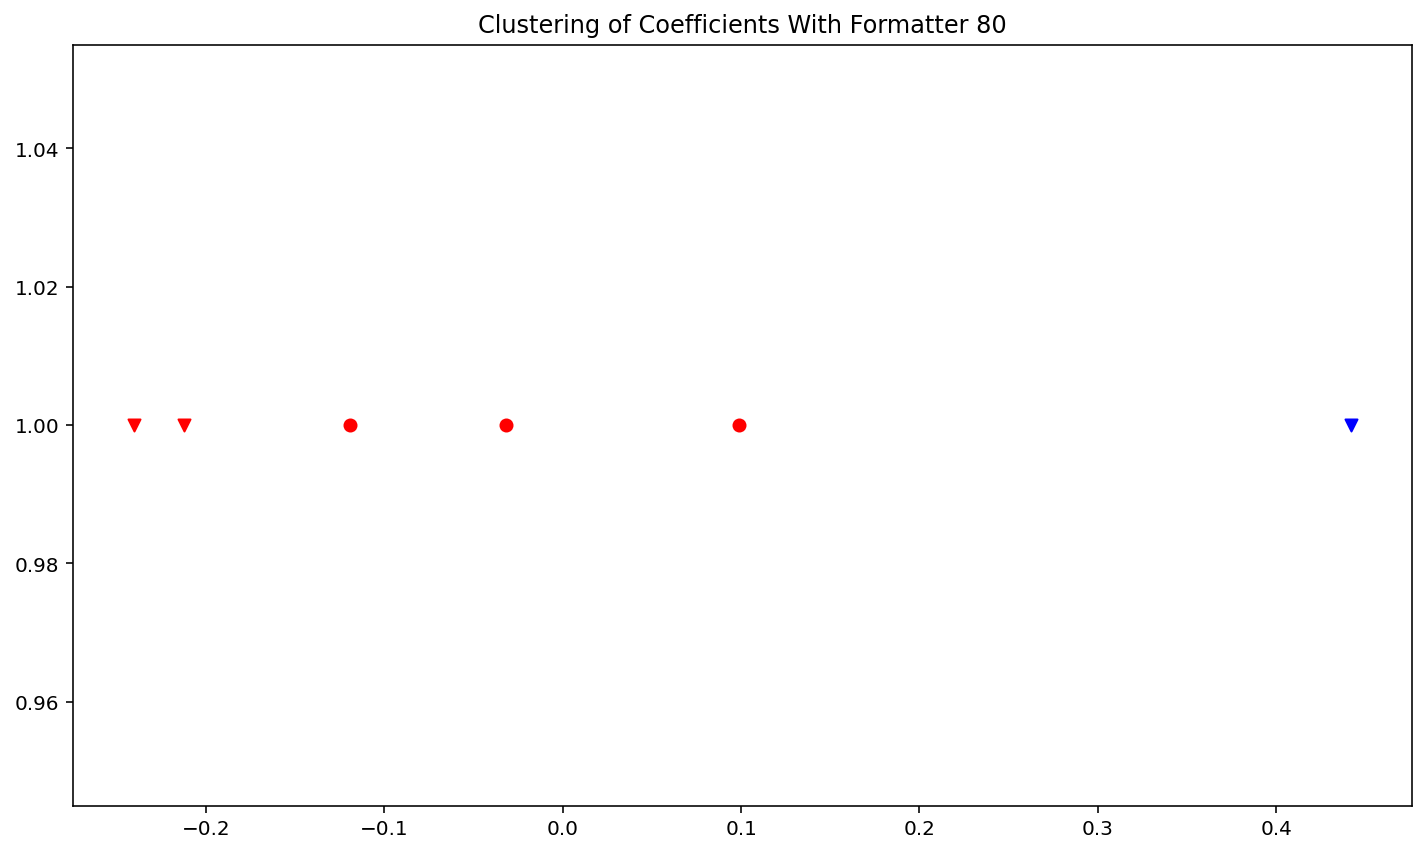

      Name  Label
0  City801      0
1  City802      0
2  City803      1
3  Home801      0
4  Home802      0
5  Home803      0


In [130]:
load(80, 3)
clusterPoints(1)

### Based on the above tests I have decided to explore the 70% variable data formatter since it produced the most reliable results.

### This may be because it does not include enough variable data to produce unwanted variance in the coefficients generated, but includes enough variable data to measure the individual characteristics of each device.

### I have therefore collected more data using the 70% variable data formatter and loaded it in below. As we can see from the K-Means clustering model, the coefficients have a large enough inter-sample range that they have been accurately identified.

Loaded 10 City70


Loaded 10 Home70


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


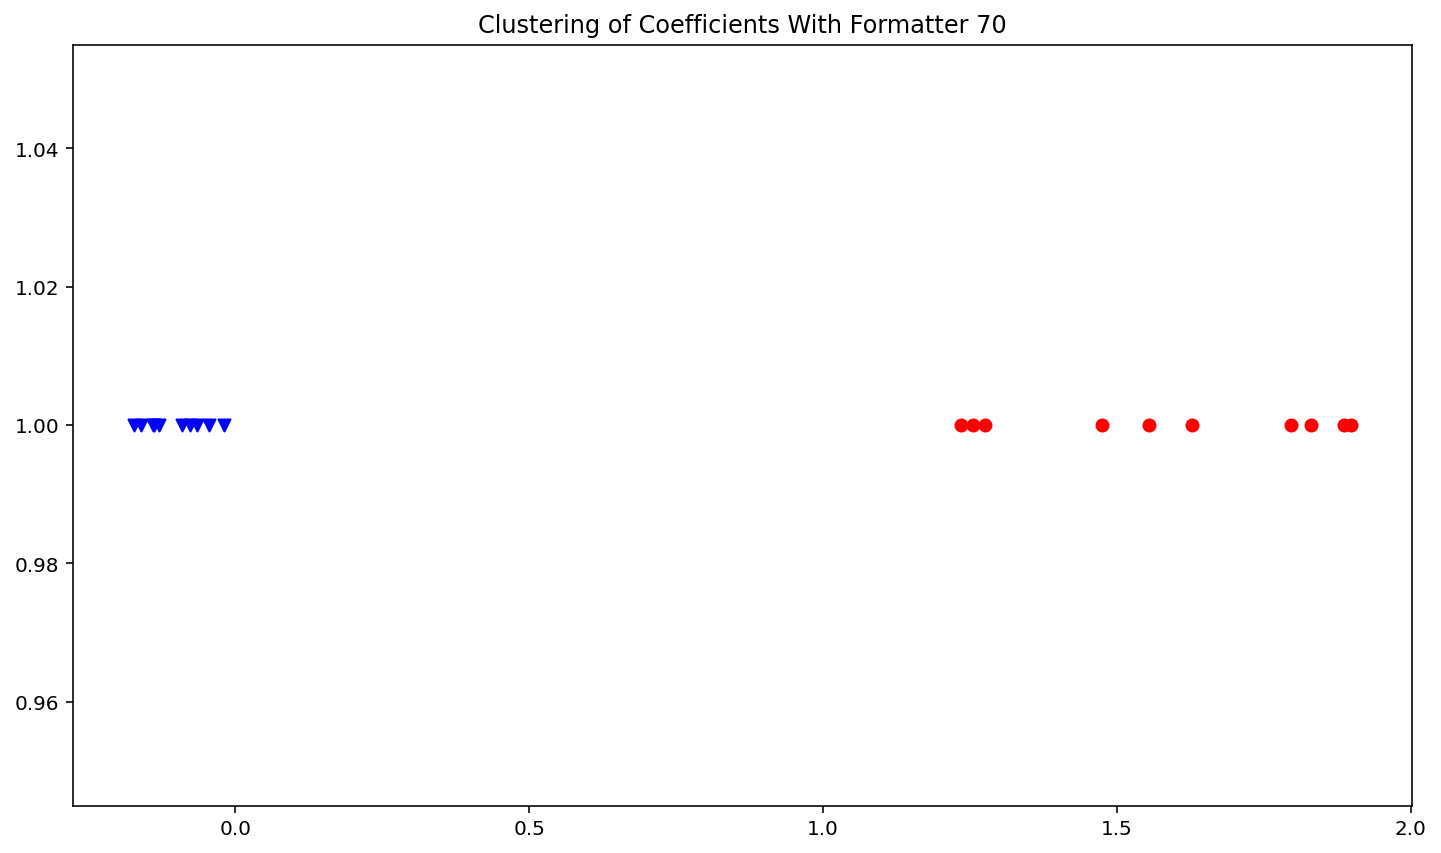

        Name  Label
0    City701      1
1    City702      1
2    City703      1
3    City704      1
4    City705      1
5    City706      1
6    City707      1
7    City708      1
8    City709      1
9   City7010      1
10   Home701      0
11   Home702      0
12   Home703      0
13   Home704      0
14   Home705      0
15   Home706      0
16   Home707      0
17   Home708      0
18   Home709      0
19  Home7010      0


In [131]:
load(70, 10)
clusterPoints(1)

#### I will also be exploring the use of a Support Vector Machine classiciation model for these univariate graphs.

#### The labeled dataset is created below

In [132]:
def createLabeledUnivariateDF(dataset):
    
    labeledDF = pd.DataFrame(columns = ['coef', 'class'])

    classification = []
    coefs = []

    for data in dataset:
        if 'City' in data:
            classification.append(0)
        else:
            classification.append(1)
        coefs.append(dataset.get(data).getCoefs(1))

    labeledDF = pd.DataFrame(columns = ['coef', 'class'])
    labeledDF['coef'] = coefs
    labeledDF['class'] = classification

    return labeledDF


#### I will be training my model on 70% of the data and testing on the remaining 30%, randomly allocated.

In [133]:
labeledDF = createLabeledUnivariateDF(dataList)

x_train, x_test, y_train, y_test = train_test_split(labeledDF['coef'], labeledDF['class'], test_size = 0.3)

#### I will be experimenting with SVM models with degree from 0 to 4.

#### This method prints the results of using our SVM model. It counts up the number of coefficients that were correctly categorised and produces a percentage accuracy.

In [134]:
def testResults():
    
    global x_test, svclassifier
    
    y_predicted = svclassifier.predict(np.asanyarray(x_test).reshape(-1,1))

    results = pd.DataFrame()
    results['predicted'] = list(y_predicted)
    
    results['actual'] = list(y_test)

    print(results)

    totalCorrect = 0
    for i in range(len(results)):
        if (results.iloc[i][0] == results.iloc[i][1]):
            totalCorrect = totalCorrect+1

    percentage = round((totalCorrect/len(results))*100)

    print("\n %s correct" % (str(percentage) + "%"))


 
 Degree 0
   predicted  actual
0          0       1
1          0       1
2          0       1
3          0       1
4          0       0
5          0       0

 33% correct


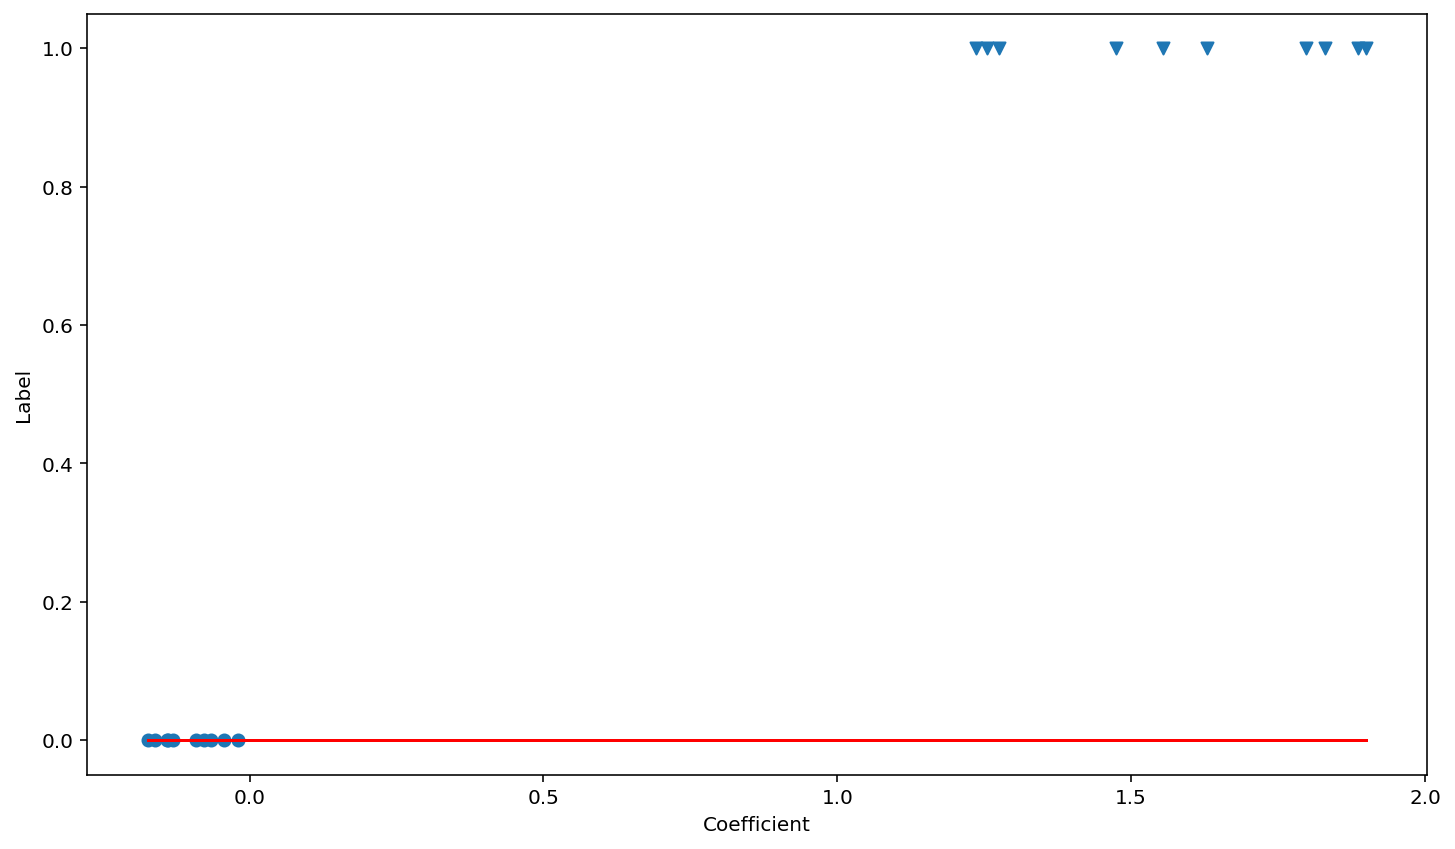


 
 Degree 1
   predicted  actual
0          1       1
1          1       1
2          1       1
3          1       1
4          0       0
5          0       0

 100% correct


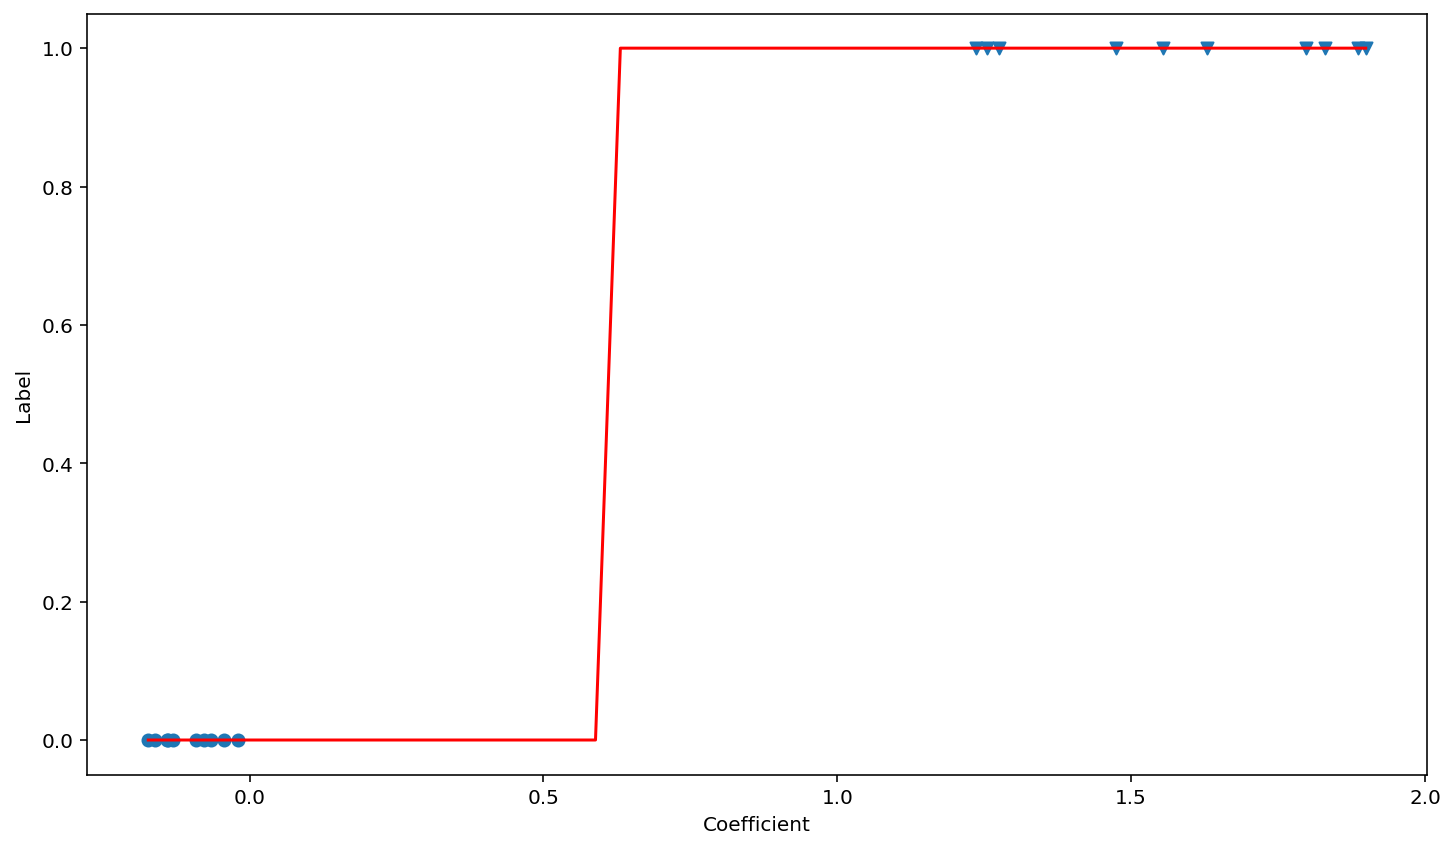


 
 Degree 2
   predicted  actual
0          1       1
1          1       1
2          1       1
3          1       1
4          0       0
5          0       0

 100% correct


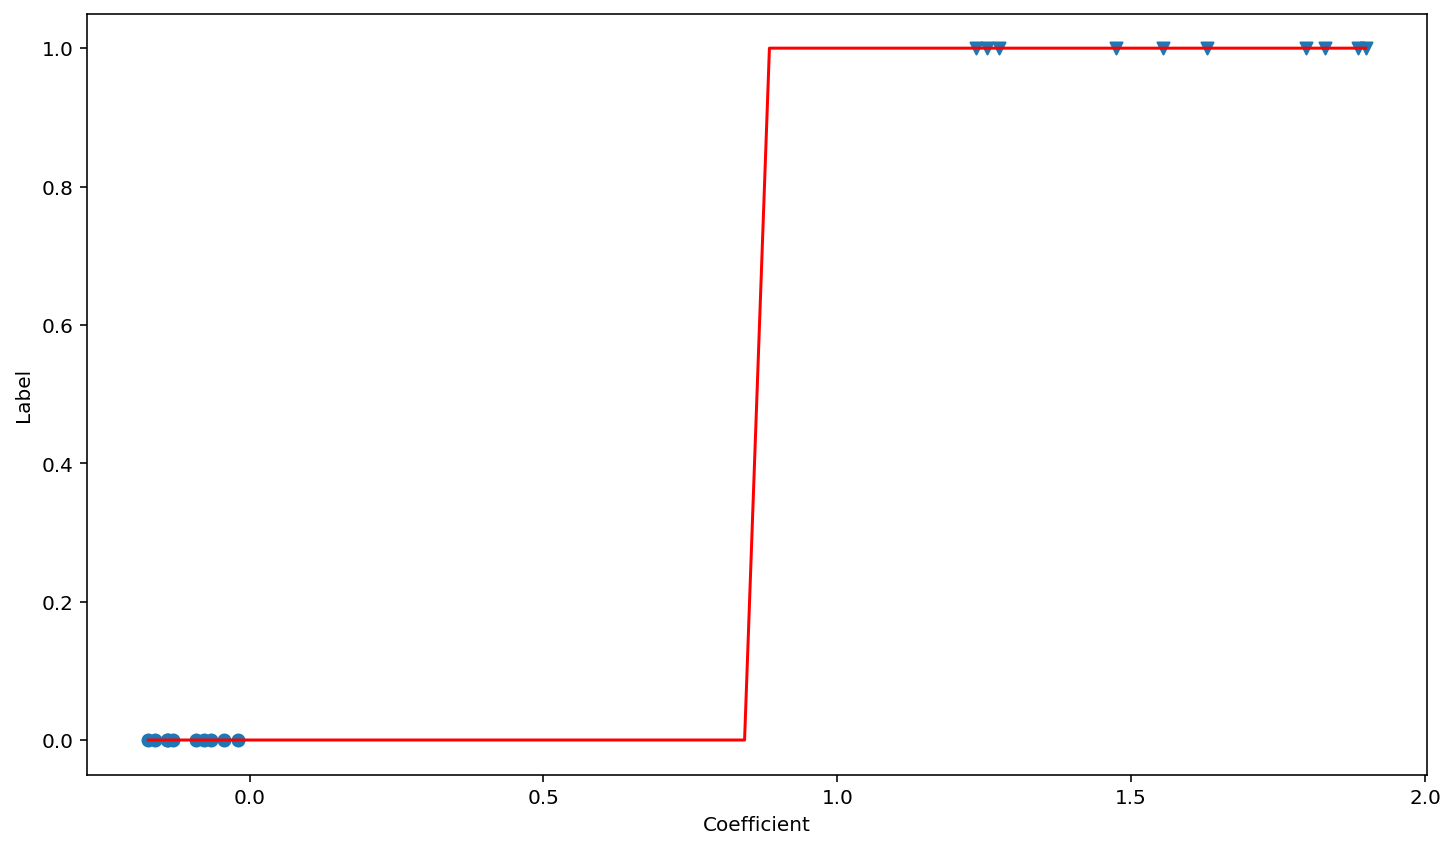


 
 Degree 3
   predicted  actual
0          1       1
1          1       1
2          1       1
3          1       1
4          0       0
5          0       0

 100% correct


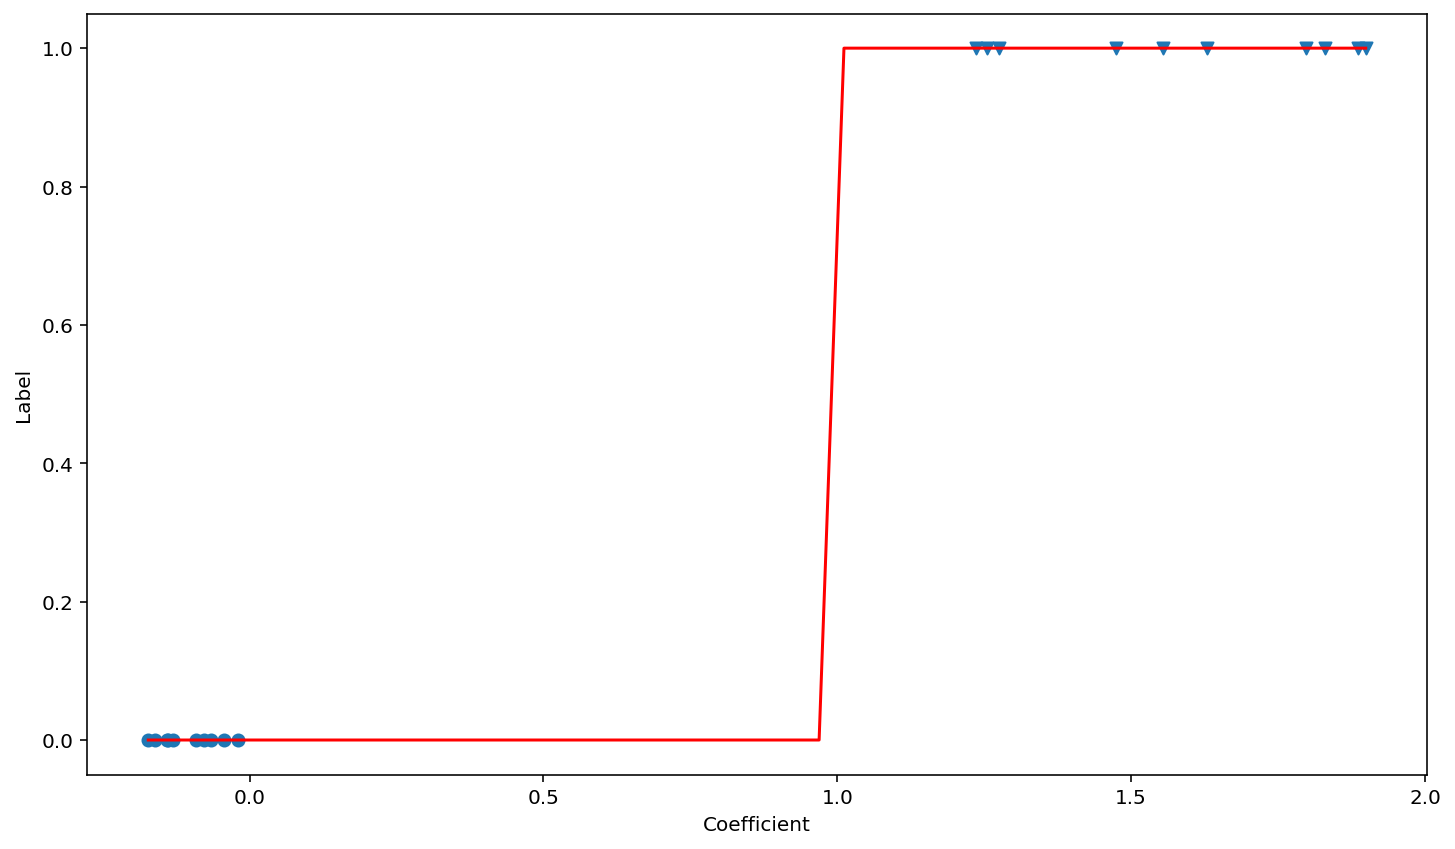


 
 Degree 4
   predicted  actual
0          1       1
1          1       1
2          1       1
3          1       1
4          0       0
5          0       0

 100% correct


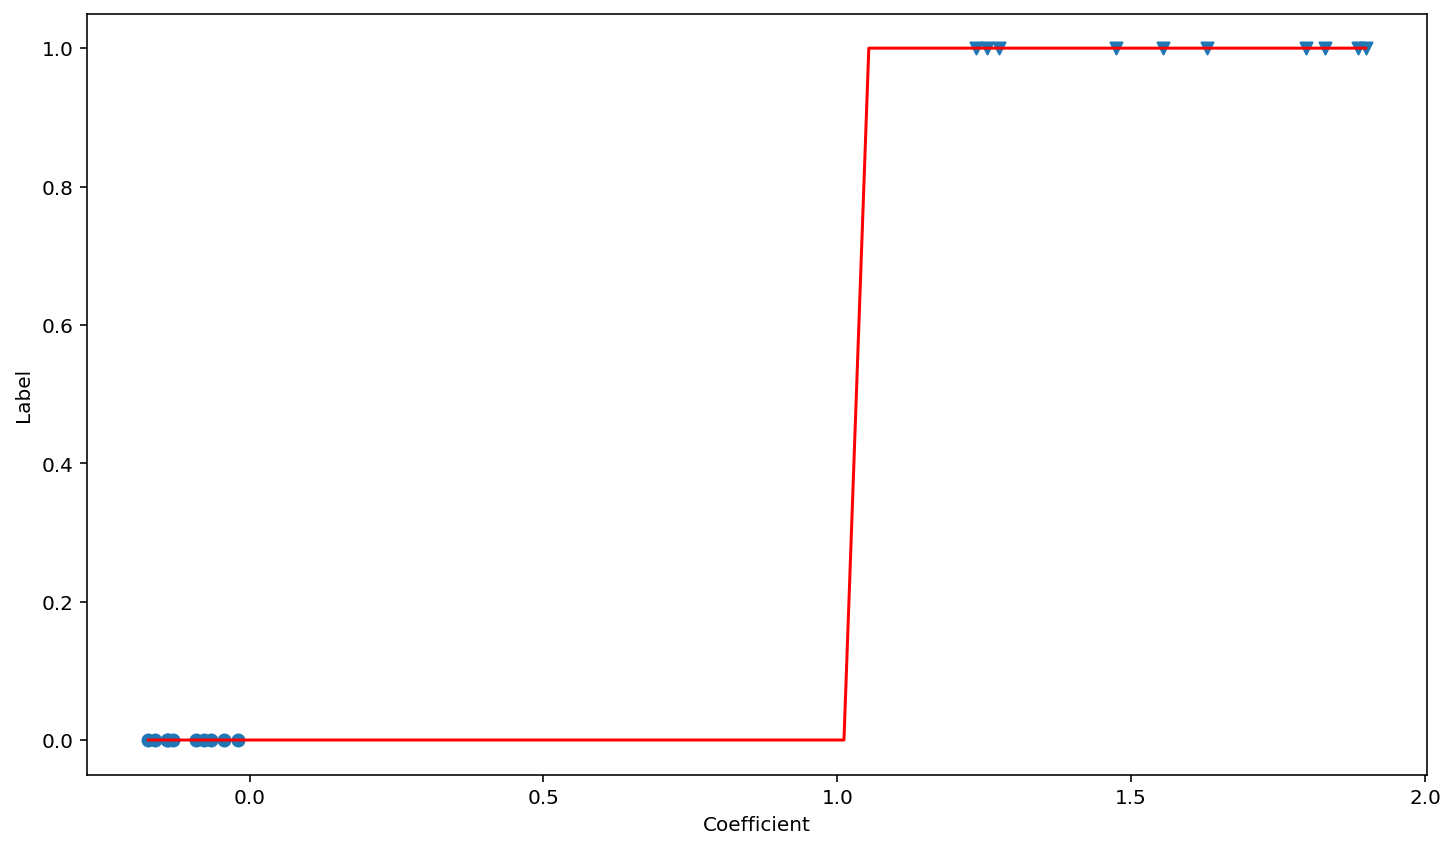

In [135]:
# Do we need this SVM section? We could just skip to degree 2 coef svm since we can see from the above that one coef doesn't work very well

for i in range(5):
    
    svclassifier = SVC(kernel='poly', degree = i, gamma = 'auto')
    svclassifier.fit(np.asanyarray(x_train).reshape(-1,1), y_train)

    y_pred = svclassifier.predict(np.asanyarray(x_test).reshape(-1,1))

    x = np.linspace(min(min(list(x_train)), min(list(x_test))), max(max(list(x_train)), max(list(x_test))))

    y = svclassifier.predict(np.asanyarray(x).reshape(-1,1))

    print("\n \n Degree %d" % i)
    
    testResults()
    
    markers = []
    
    for cl in list(labeledDF['class']):
        if cl == 0:
            markers.append('o')
        else:
            markers.append('v')
    
    plt.xlabel('Coefficient')
    plt.ylabel('Label')
    
    for i in range(len(markers)):
        plt.scatter(labeledDF['coef'][i], labeledDF['class'][i], marker=markers[i], color='tab:blue')
    
    plt.plot(x,y, 'r')
    plt.show()

#### With no significant improvement in results above degree 1, this appears to be the best model with which to verify my results.

#### From here I will look into classification with more than one coefficient to see if this will give me a more accurate graph showing the separation between my devices.

Loaded 1 City70
Loaded 1 Home70




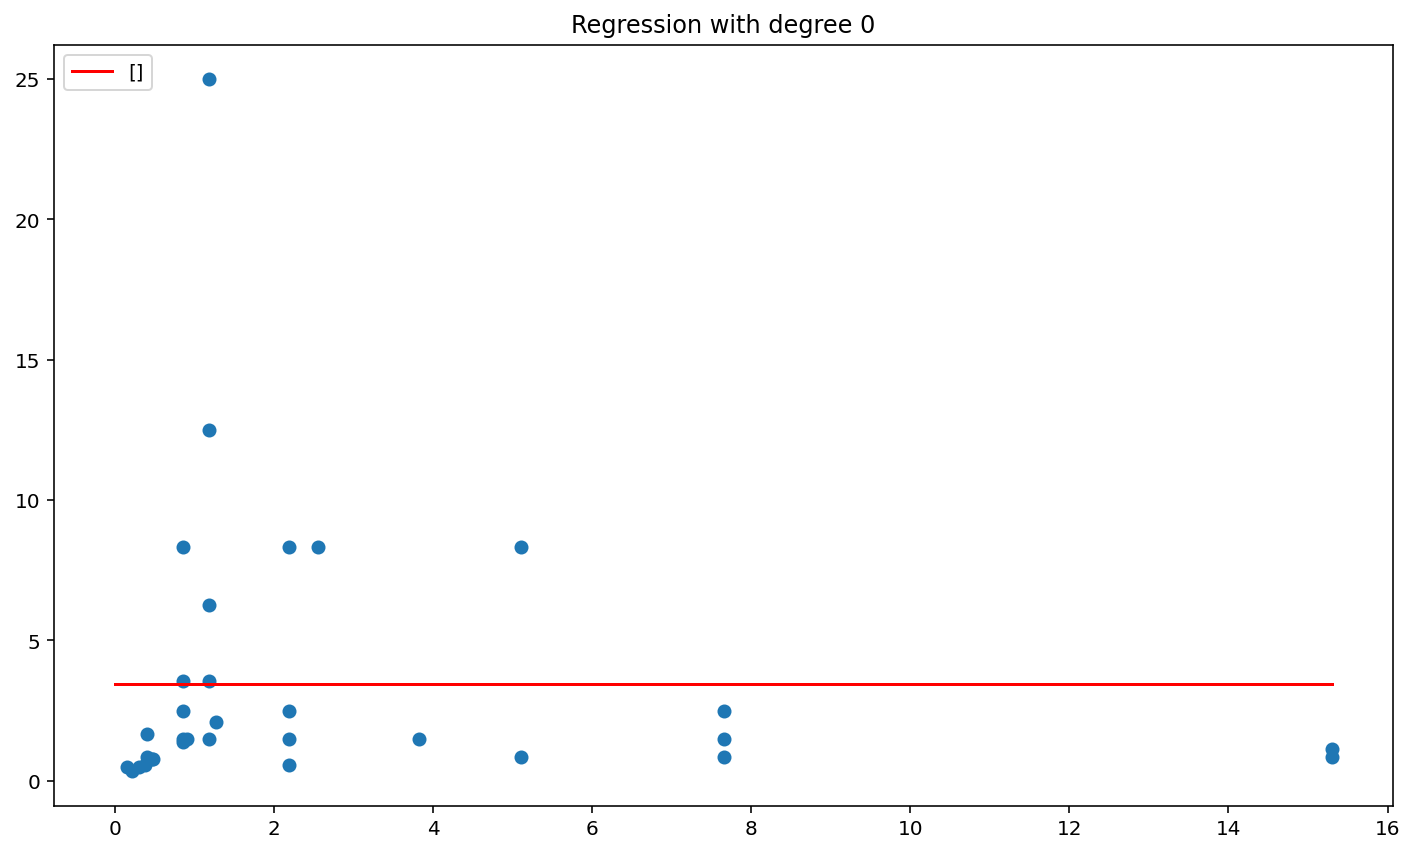

Coefficient: []


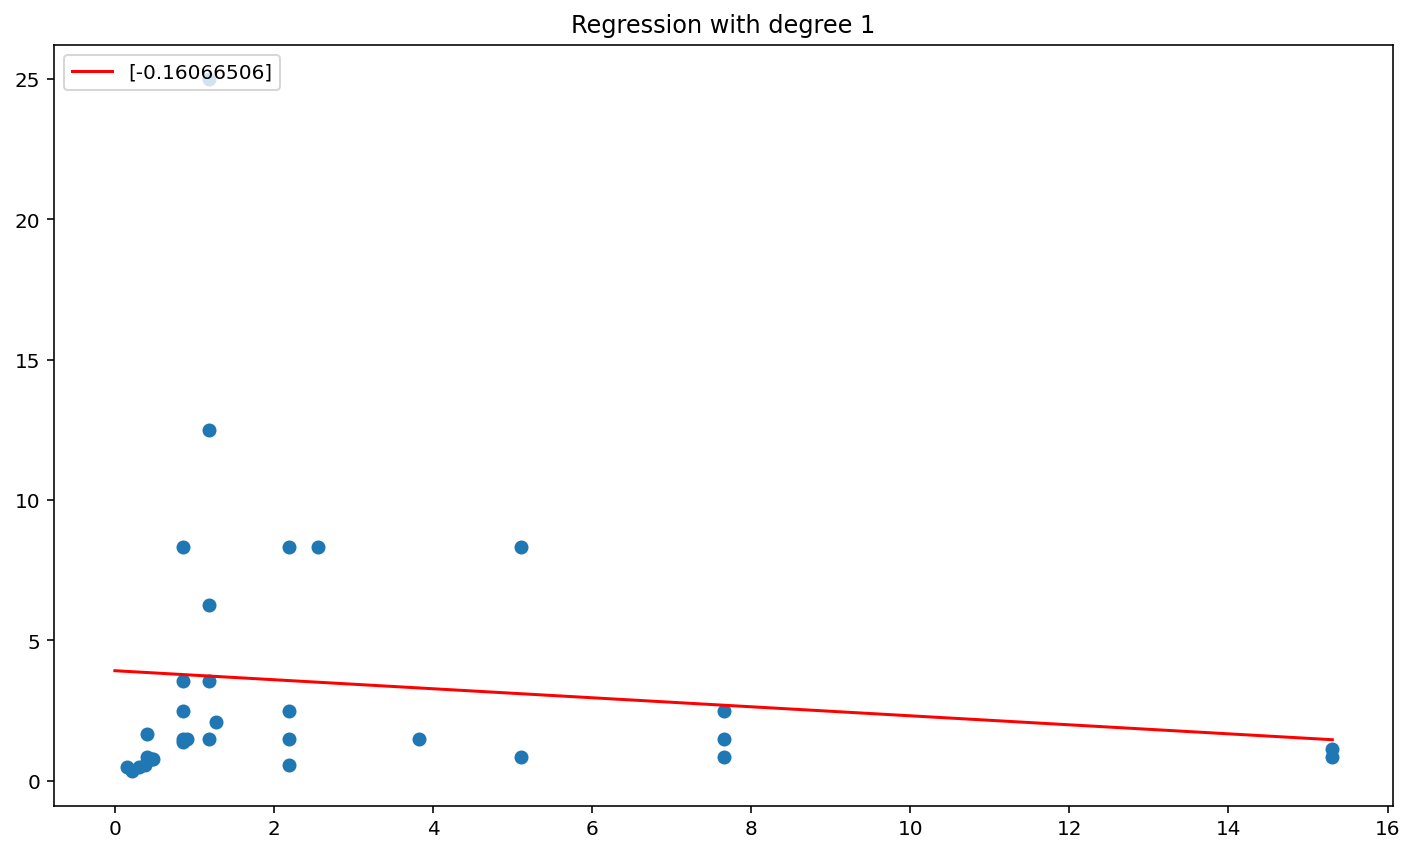

Coefficient: [-0.16066506]


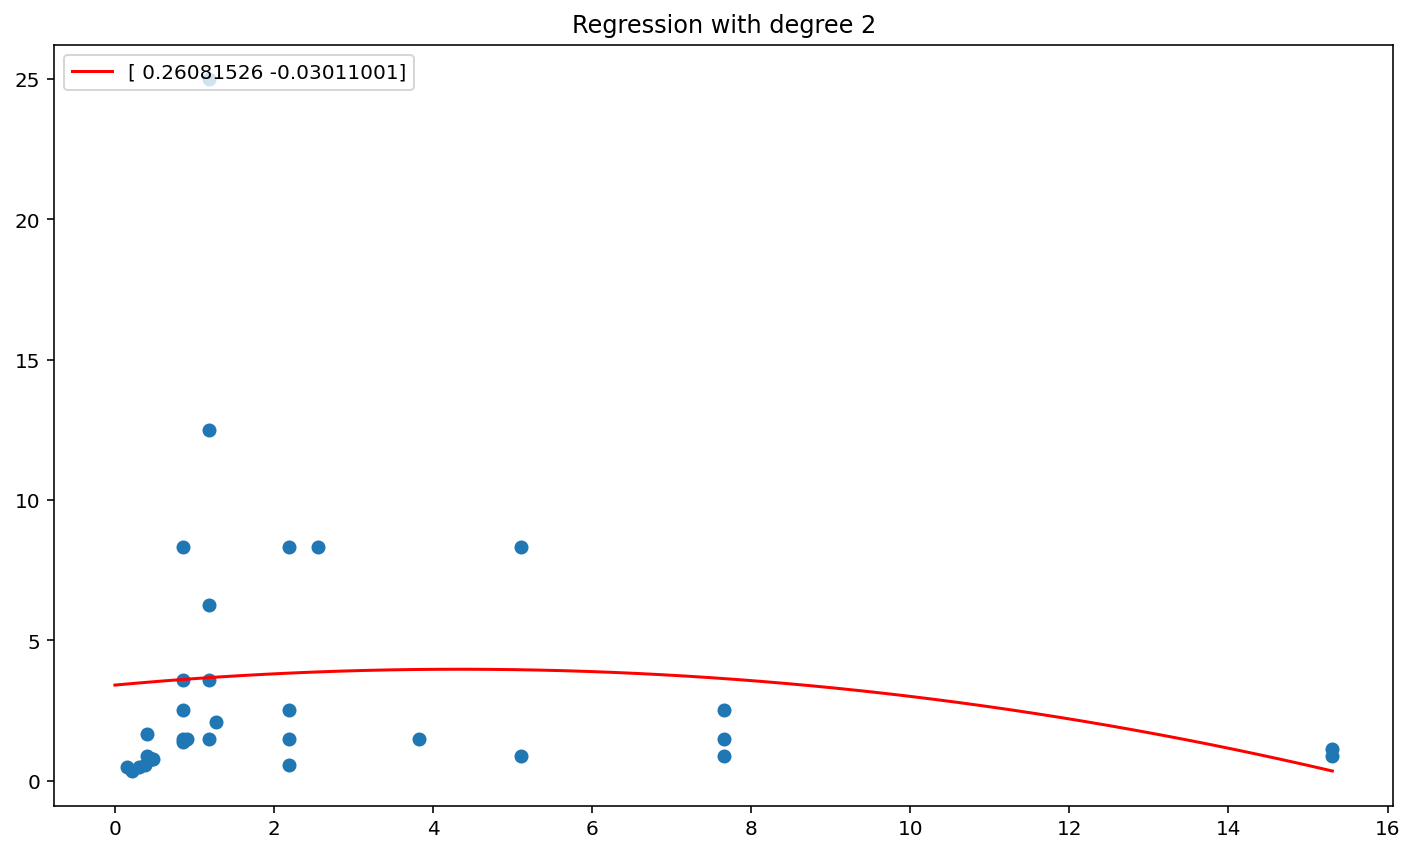

Coefficients: [ 0.26081526 -0.03011001]


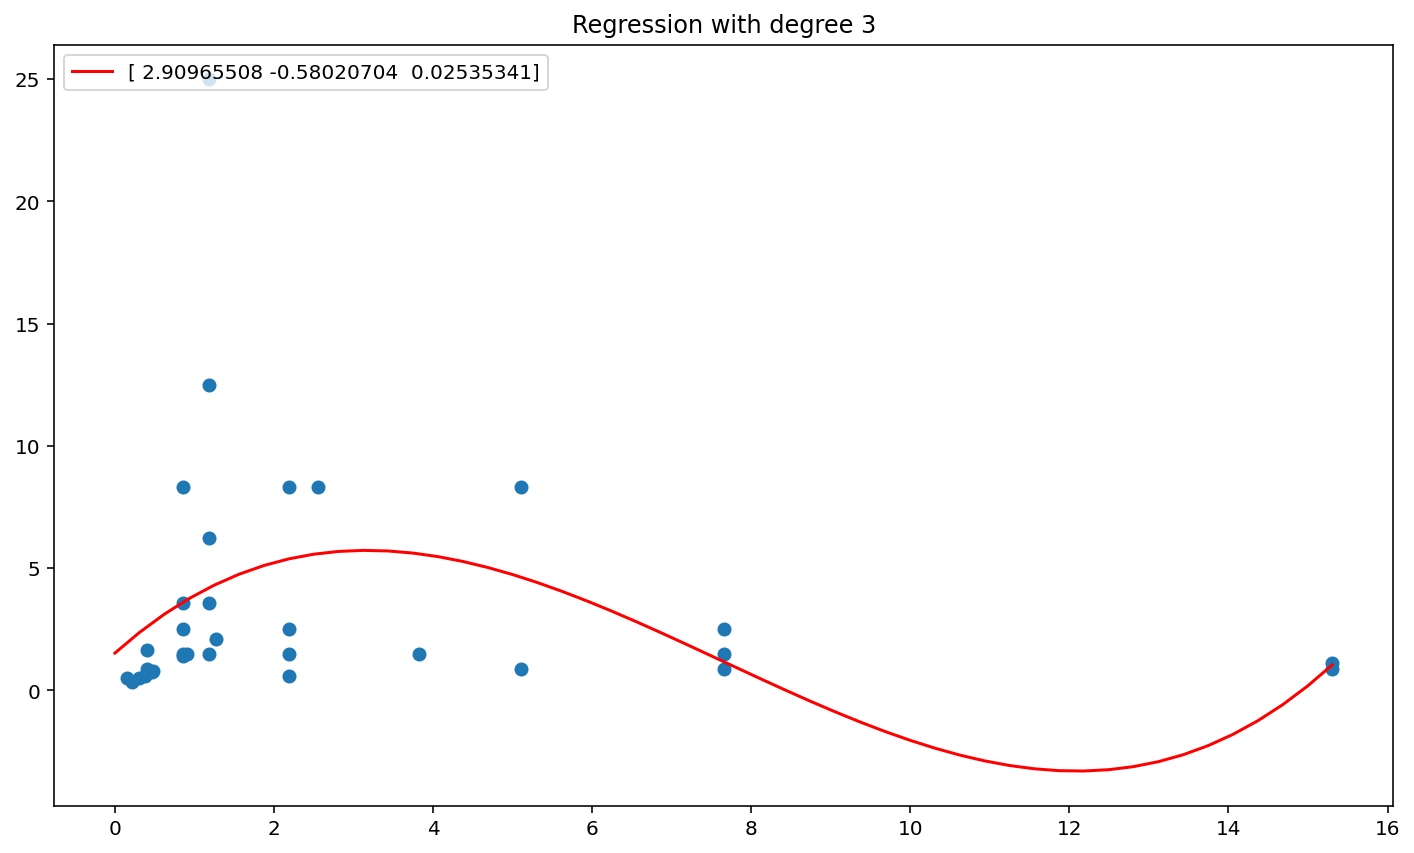

Coefficients: [ 2.90965508 -0.58020704  0.02535341]


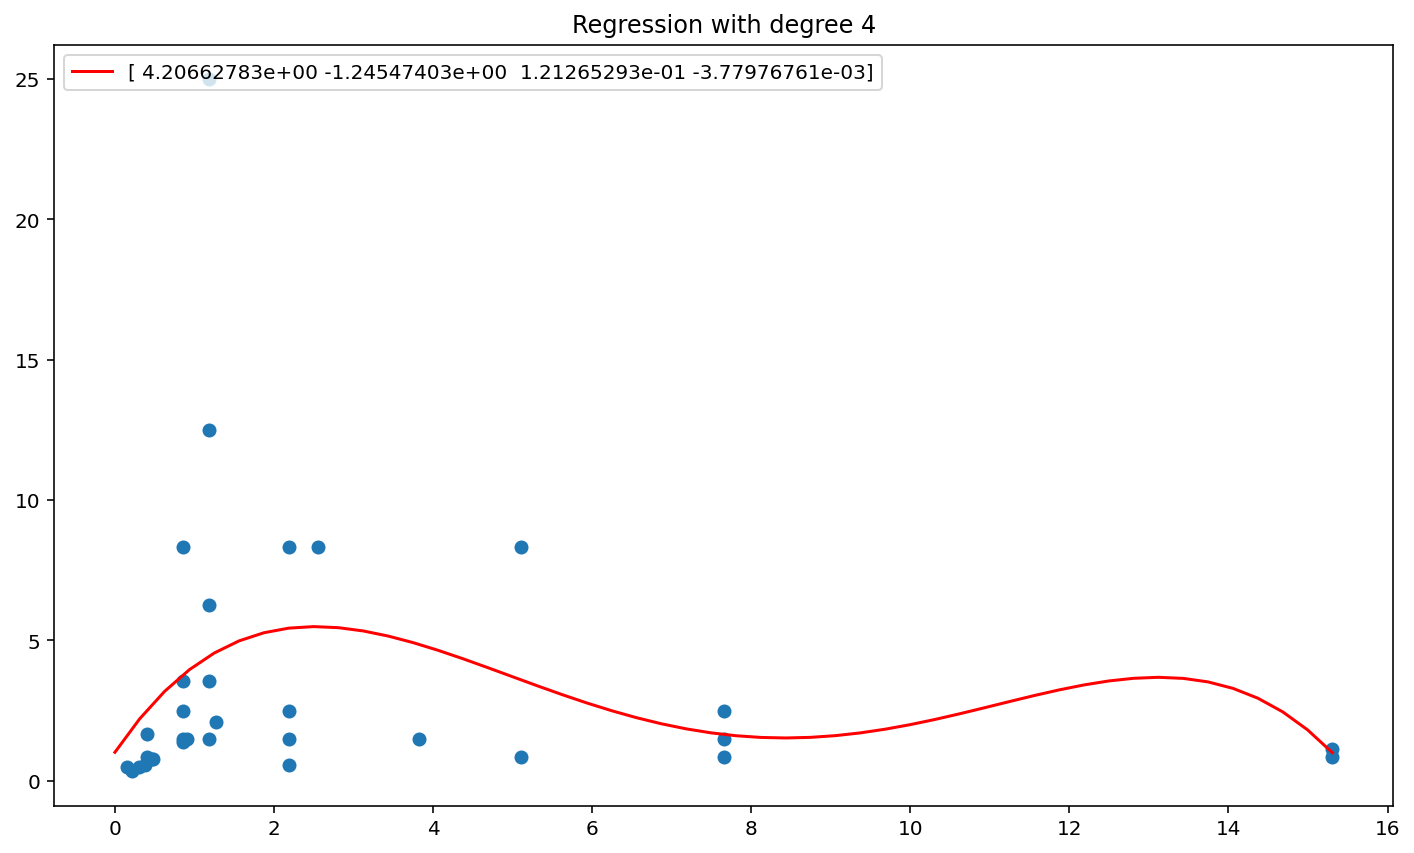

Coefficients: [ 4.20662783e+00 -1.24547403e+00  1.21265293e-01 -3.77976761e-03]


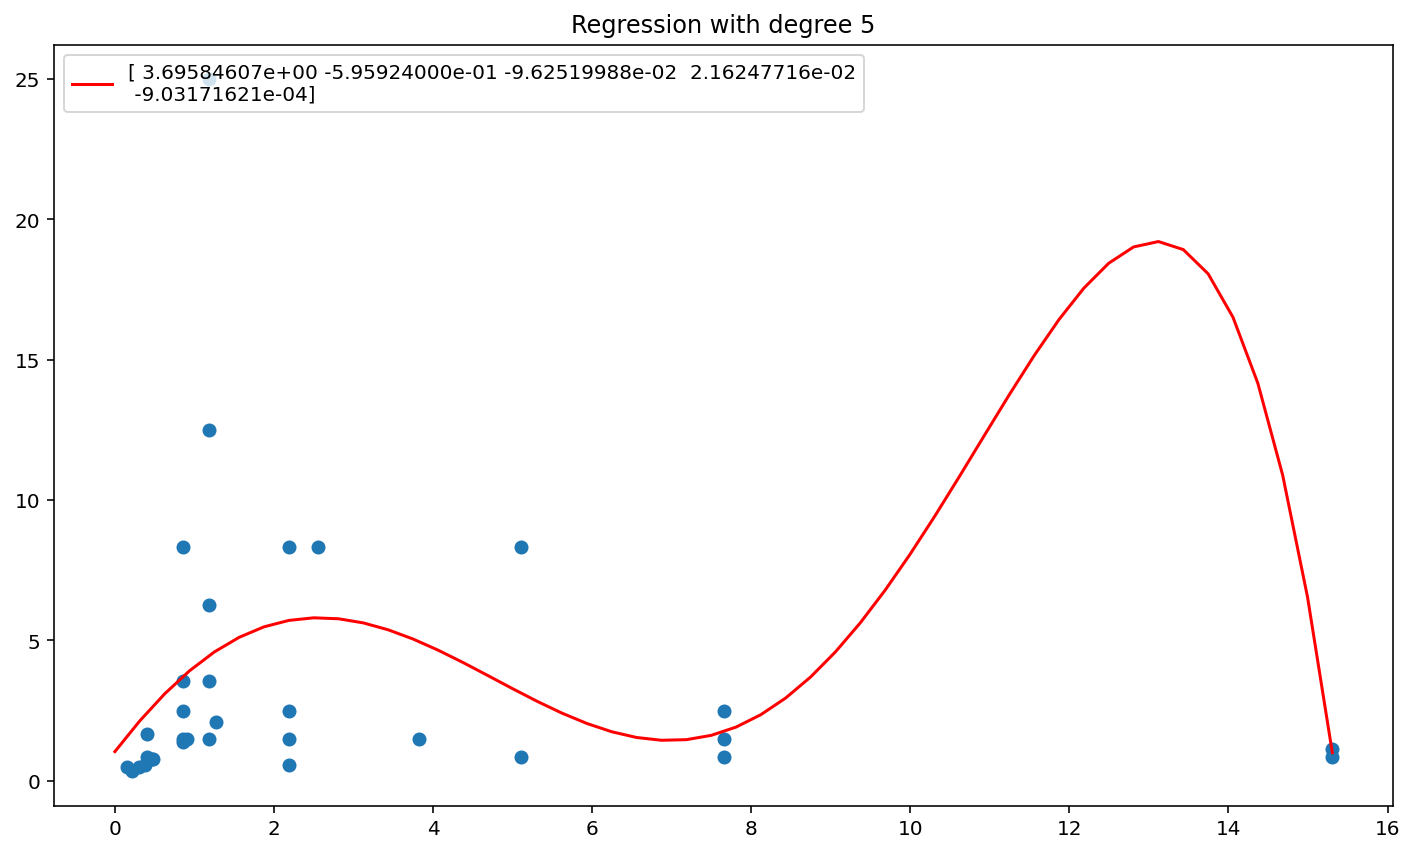

Coefficients: [ 3.69584607e+00 -5.95924000e-01 -9.62519988e-02  2.16247716e-02
 -9.03171621e-04]


In [136]:
load(70,1)

for i in range(6):
    printCombinedGraph(dataList.get('City701'), degree=i)

#### From the abve test we can see that overfitting starts to affect our results from degree 3 onwards, and as such regression with degree 2 was chosen to represent each dataset.

#### Each dataset is loaded in, and polynomial regression is applied to it to give us two coefficients. All coefficient points are then plotted on the same graph, and then classified.

#### Below are clustering graphs using one and two coefficients respectively so that we may see the advantages of using two coefficients.

Loaded 3 City50


Loaded 3 Home50


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


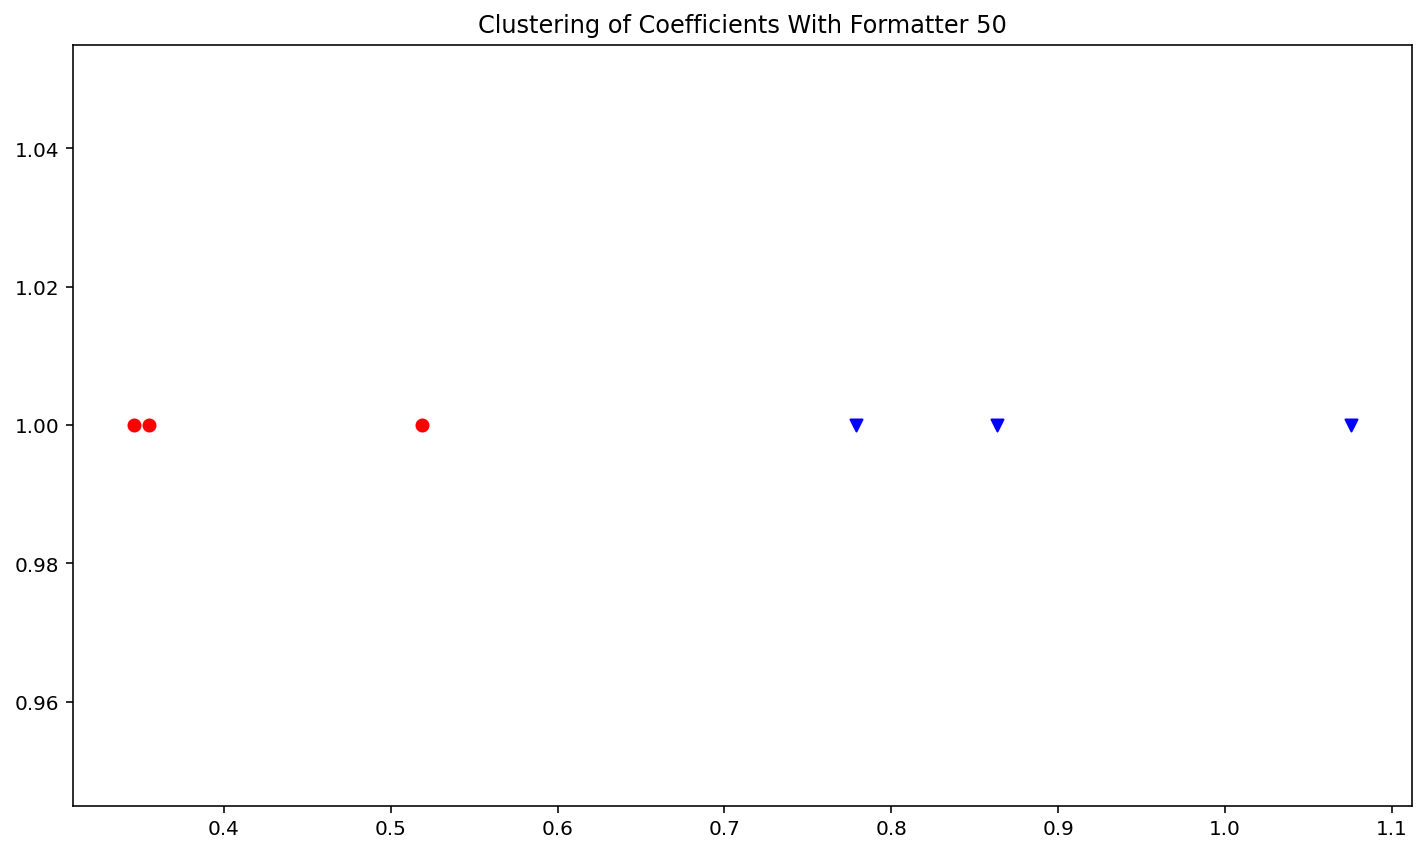

      Name  Label
0  City501      1
1  City502      1
2  City503      1
3  Home501      0
4  Home502      0
5  Home503      0
{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


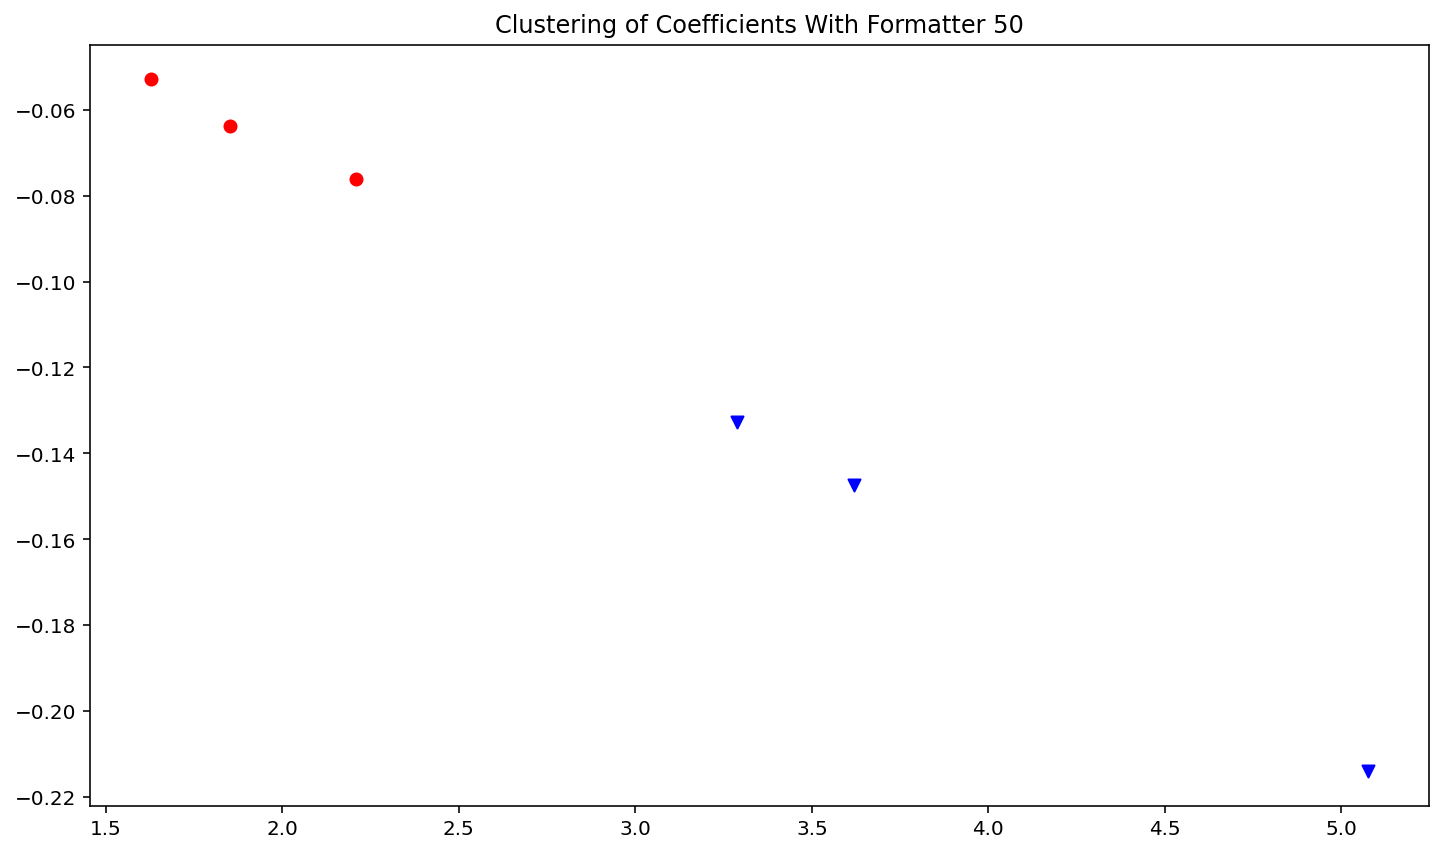

      Name  Label
0  City501      1
1  City502      1
2  City503      1
3  Home501      0
4  Home502      0
5  Home503      0


In [137]:
load(50, 3)
clusterPoints(1)
clusterPoints(2)

Loaded 3 City60
Loaded 3 Home60




{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


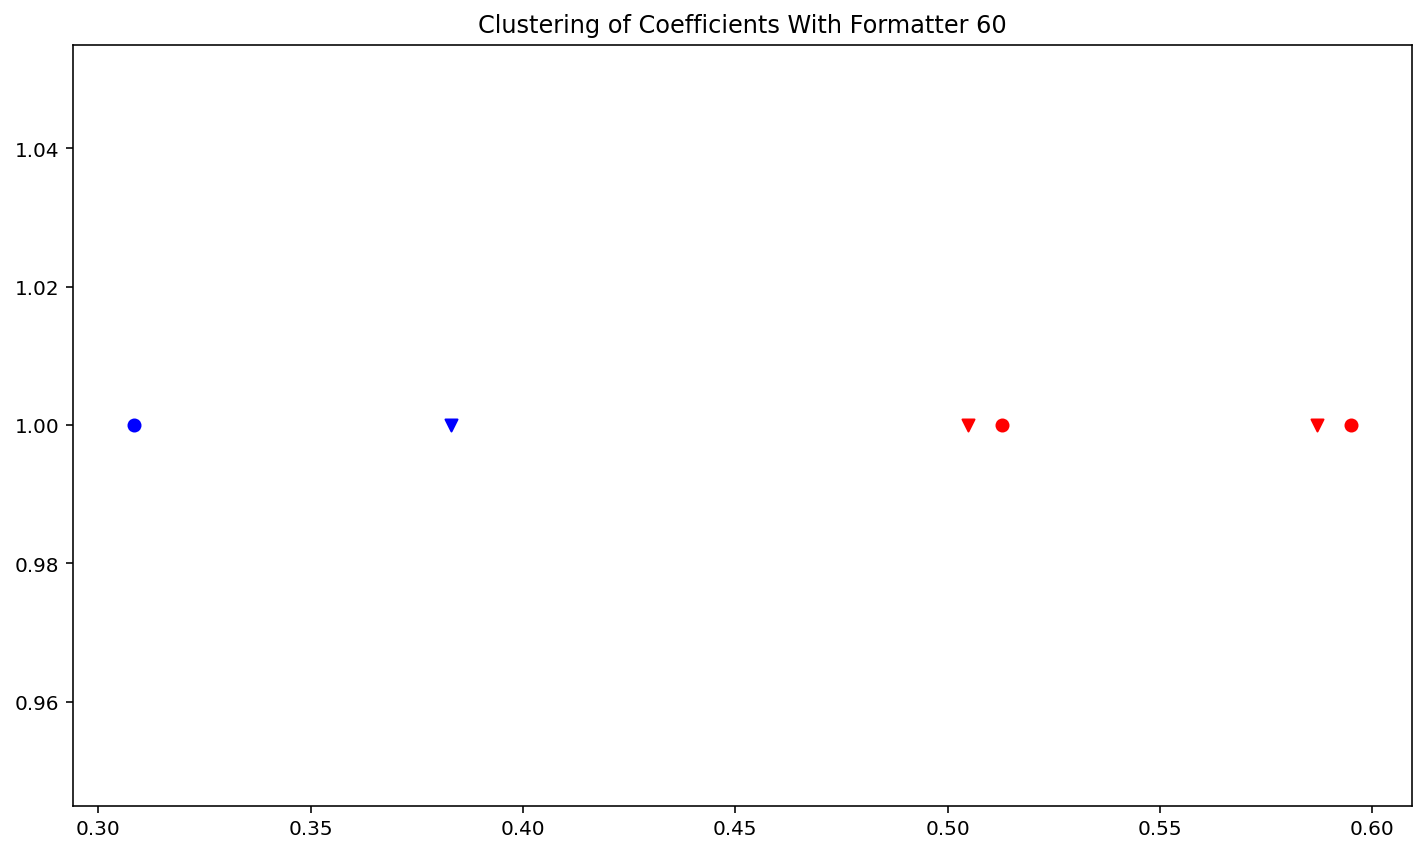

      Name  Label
0  City601      0
1  City602      0
2  City603      1
3  Home601      1
4  Home602      0
5  Home603      0
{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


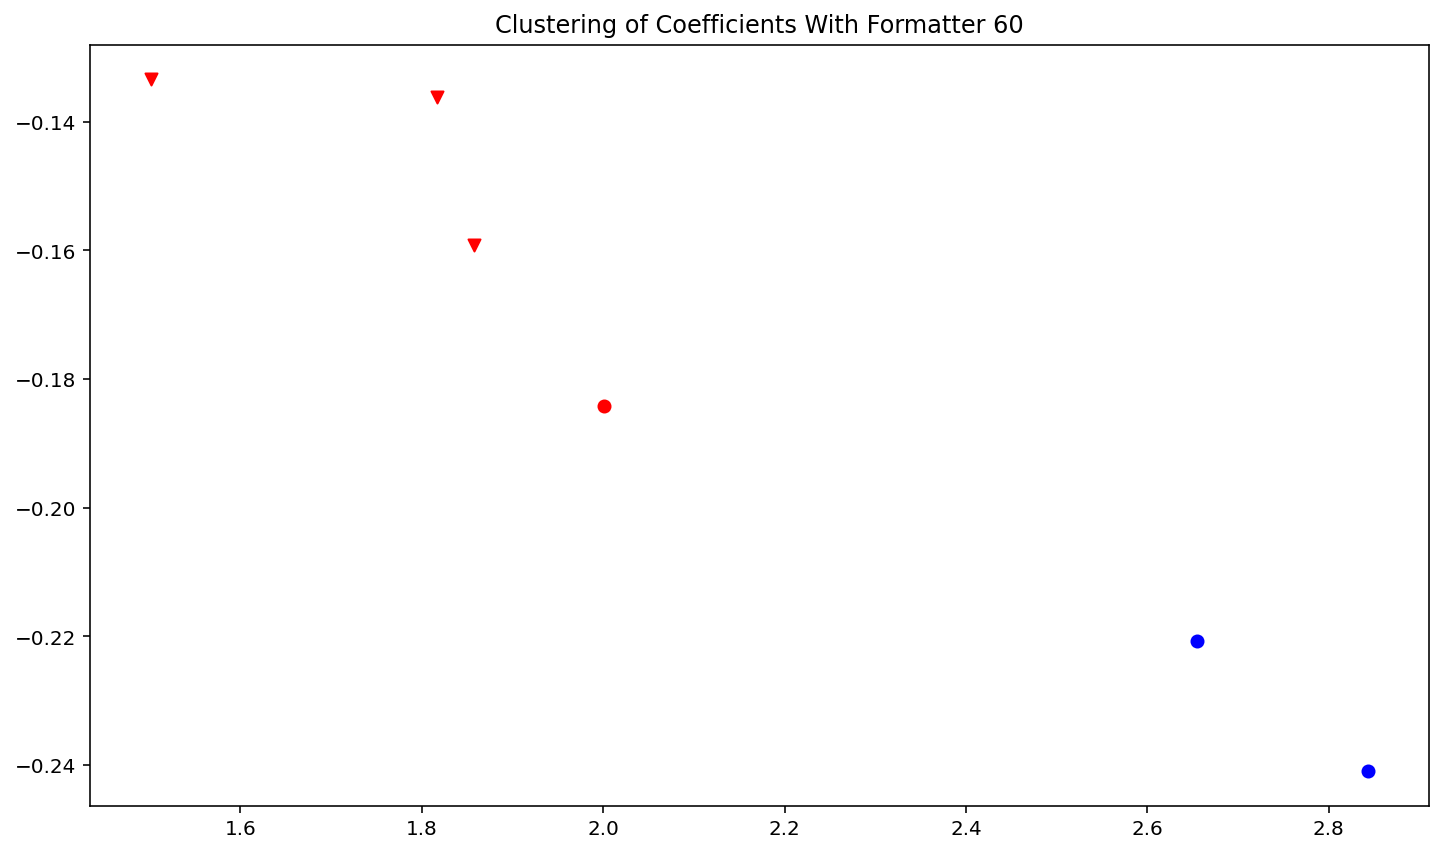

      Name  Label
0  City601      0
1  City602      0
2  City603      0
3  Home601      0
4  Home602      1
5  Home603      1


In [138]:
load(60, 3)
clusterPoints(1)
clusterPoints(2)

Loaded 3 City70
Loaded 3 Home70


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


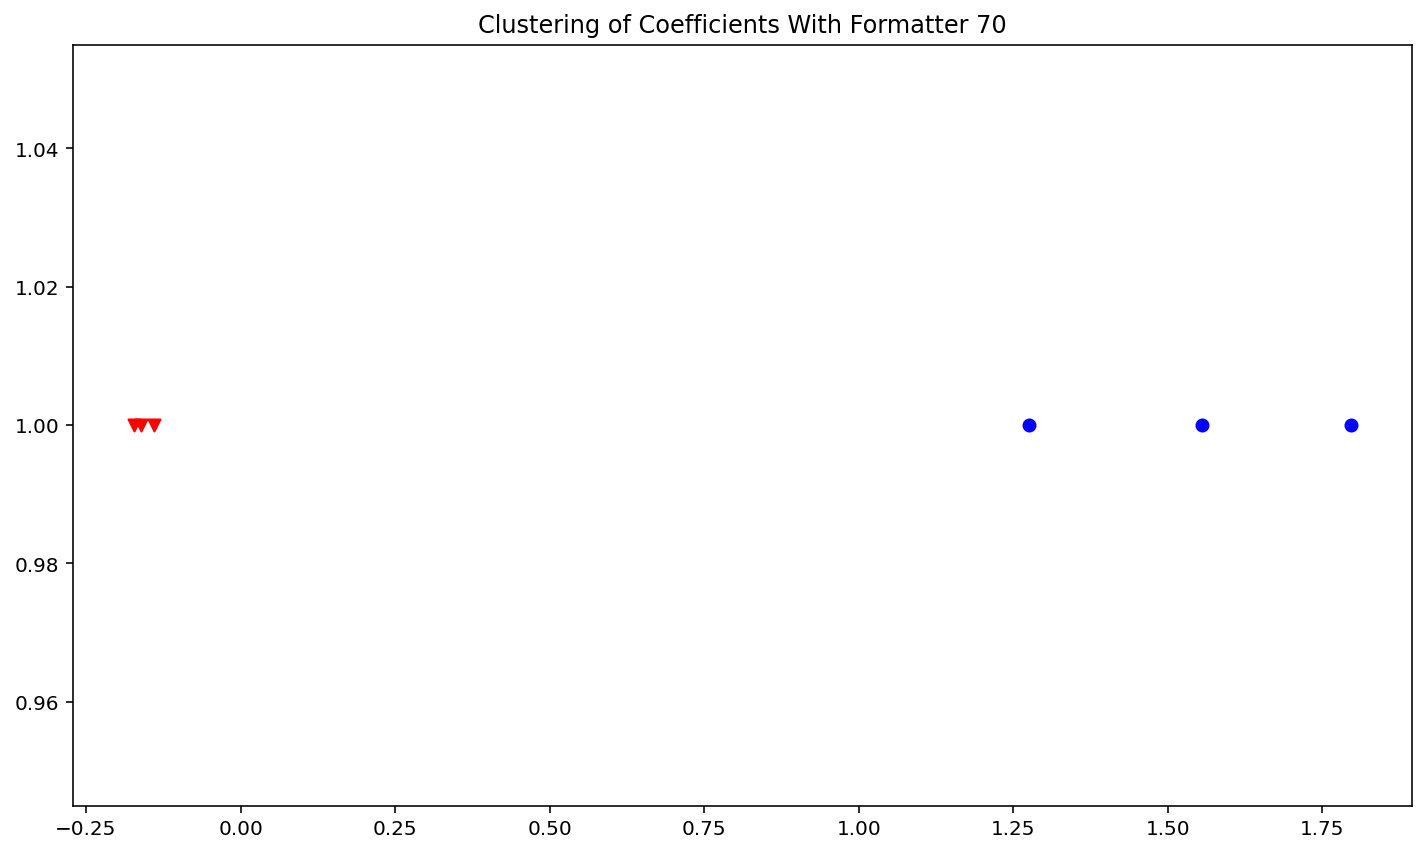

      Name  Label
0  City701      0
1  City702      0
2  City703      0
3  Home701      1
4  Home702      1
5  Home703      1
{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


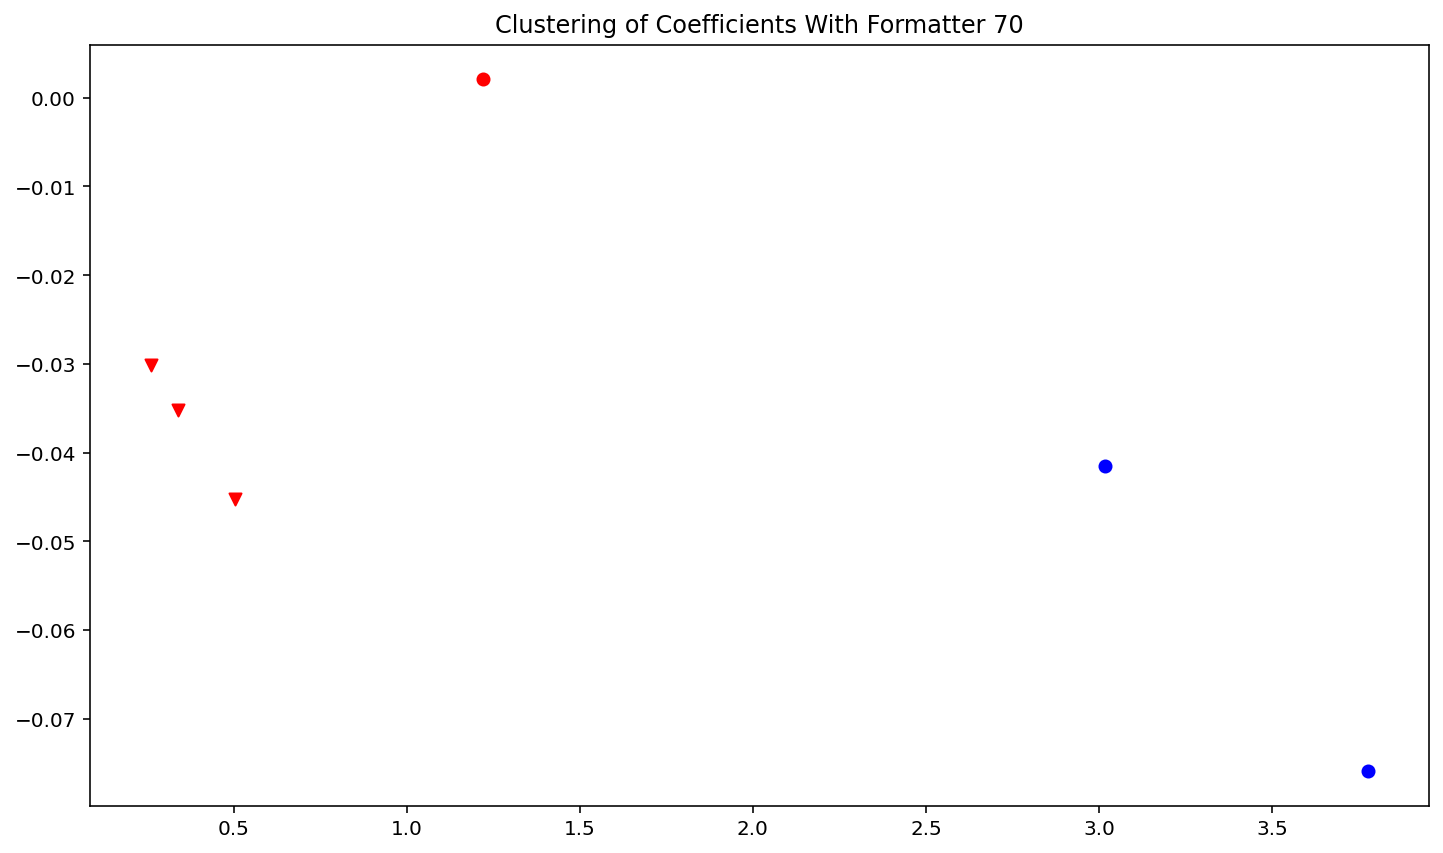

      Name  Label
0  City701      0
1  City702      0
2  City703      0
3  Home701      1
4  Home702      1
5  Home703      0


In [139]:
load(70, 3)
clusterPoints(1)
clusterPoints(2)

Loaded 3 City80
Loaded 3 Home80


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


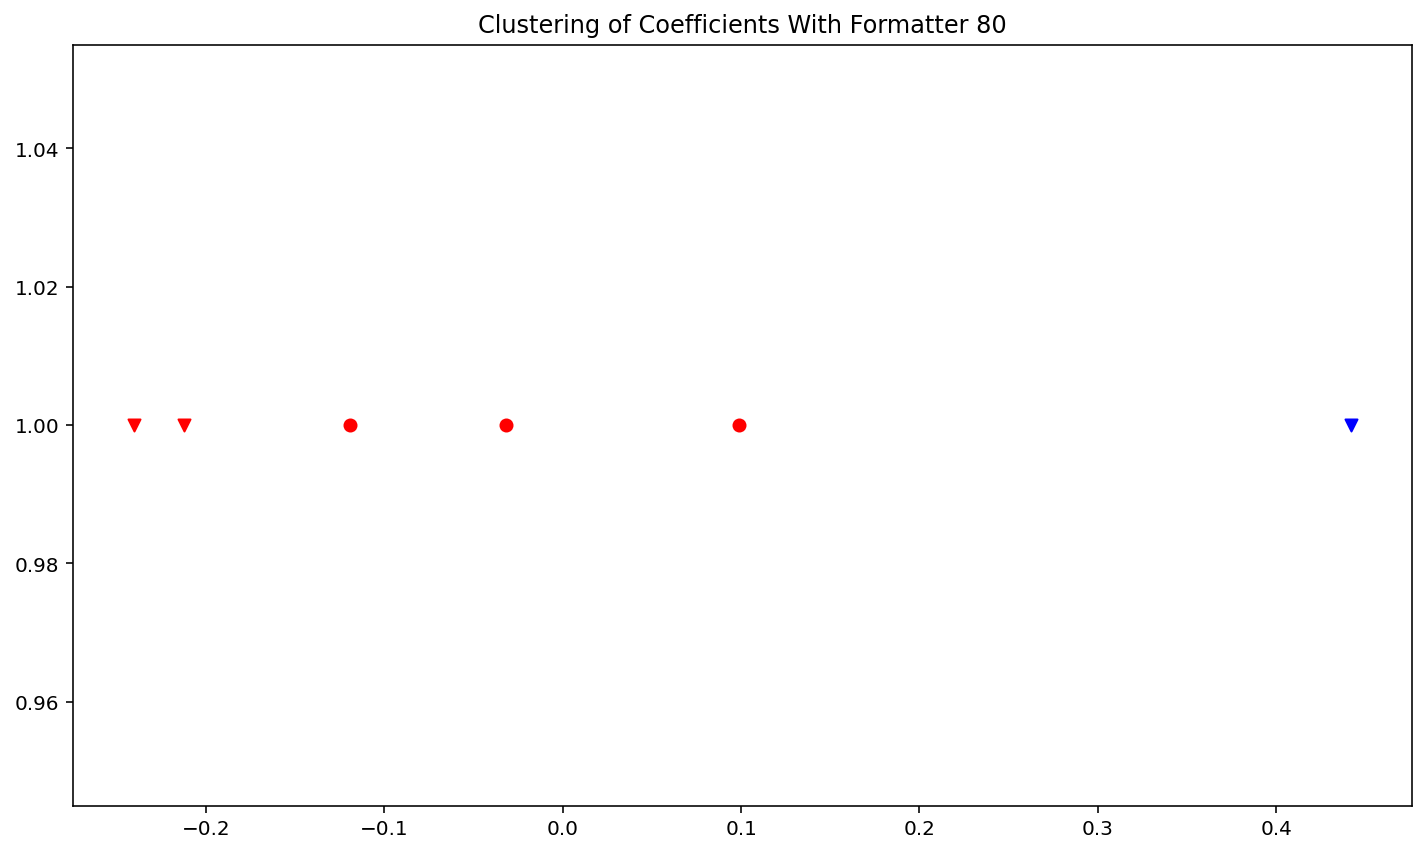

      Name  Label
0  City801      0
1  City802      0
2  City803      1
3  Home801      0
4  Home802      0
5  Home803      0
{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


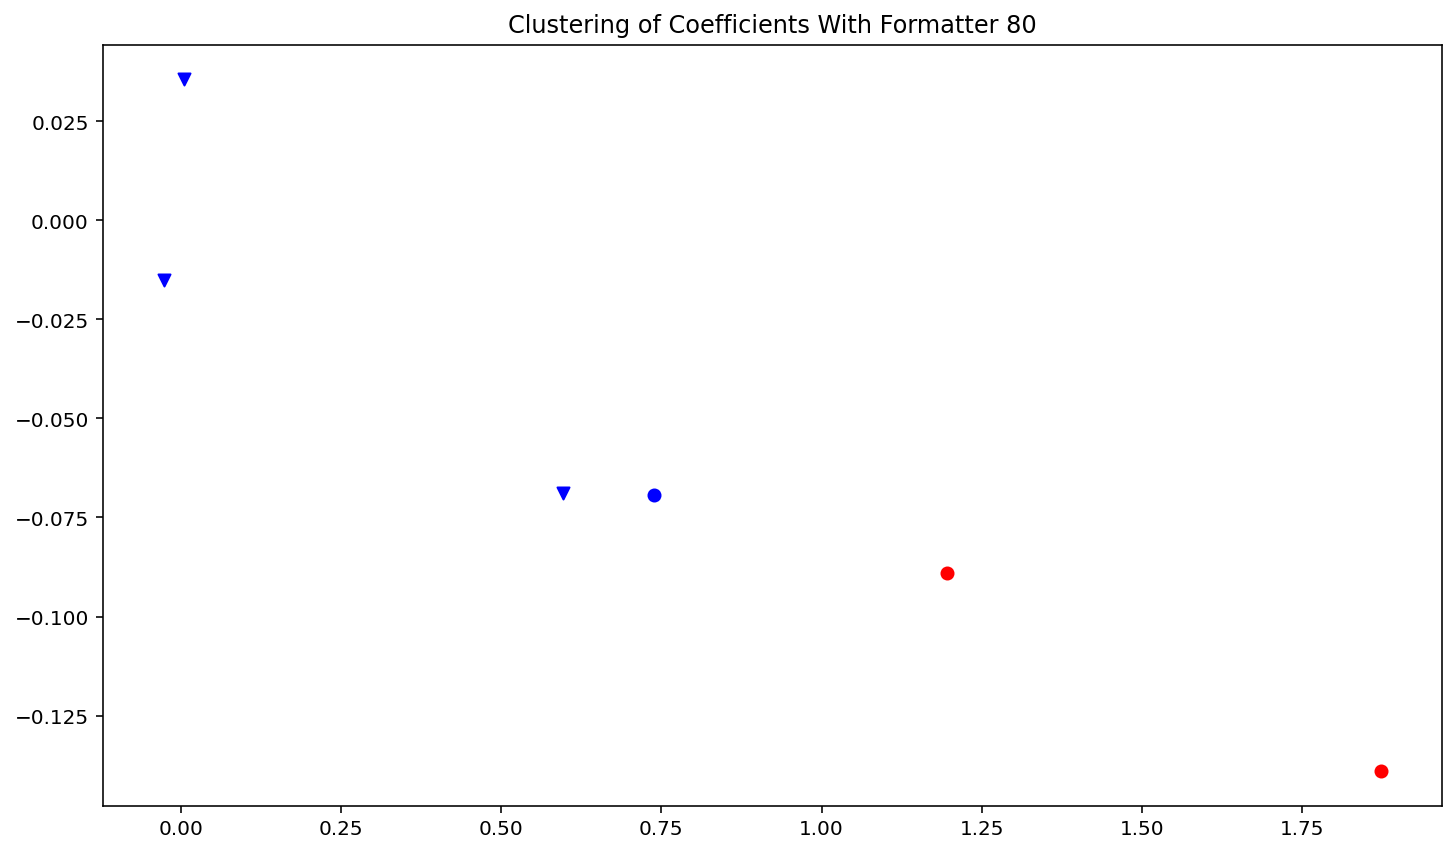

      Name  Label
0  City801      1
1  City802      1
2  City803      1
3  Home801      0
4  Home802      1
5  Home803      0


In [140]:
load(80, 3)
clusterPoints(1)
clusterPoints(2)

#### The graphs above show that the advantages of using two coefficients become apparent when using the 70% formatter only. Below, the same test is run using all of the data for the 70% formatter.

Loaded 10 City70


Loaded 10 Home70


{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


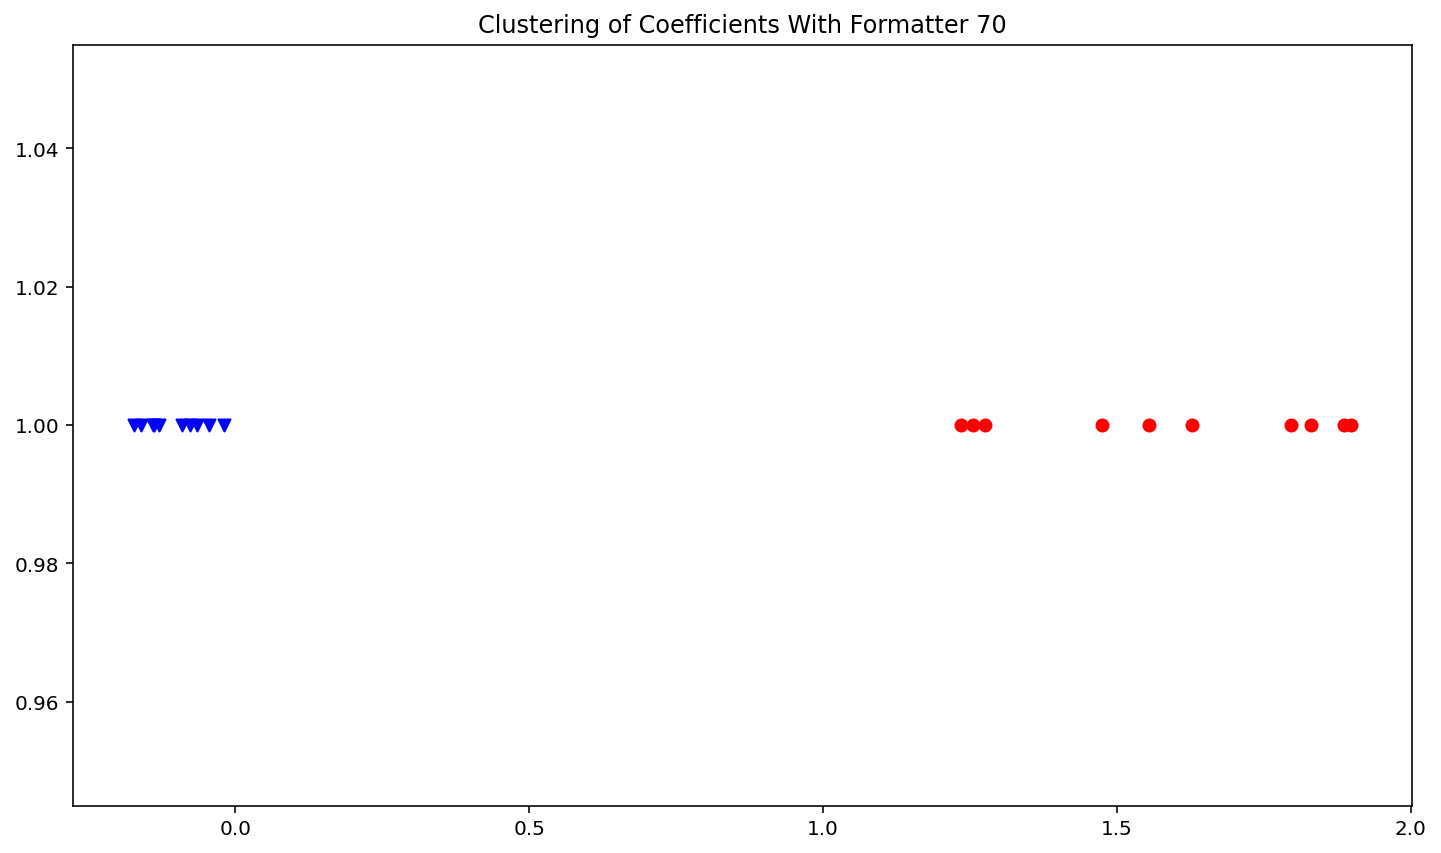

        Name  Label
0    City701      1
1    City702      1
2    City703      1
3    City704      1
4    City705      1
5    City706      1
6    City707      1
7    City708      1
8    City709      1
9   City7010      1
10   Home701      0
11   Home702      0
12   Home703      0
13   Home704      0
14   Home705      0
15   Home706      0
16   Home707      0
17   Home708      0
18   Home709      0
19  Home7010      0
{'algorithm': 'auto', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 10, 'n_jobs': None, 'precompute_distances': 'auto', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


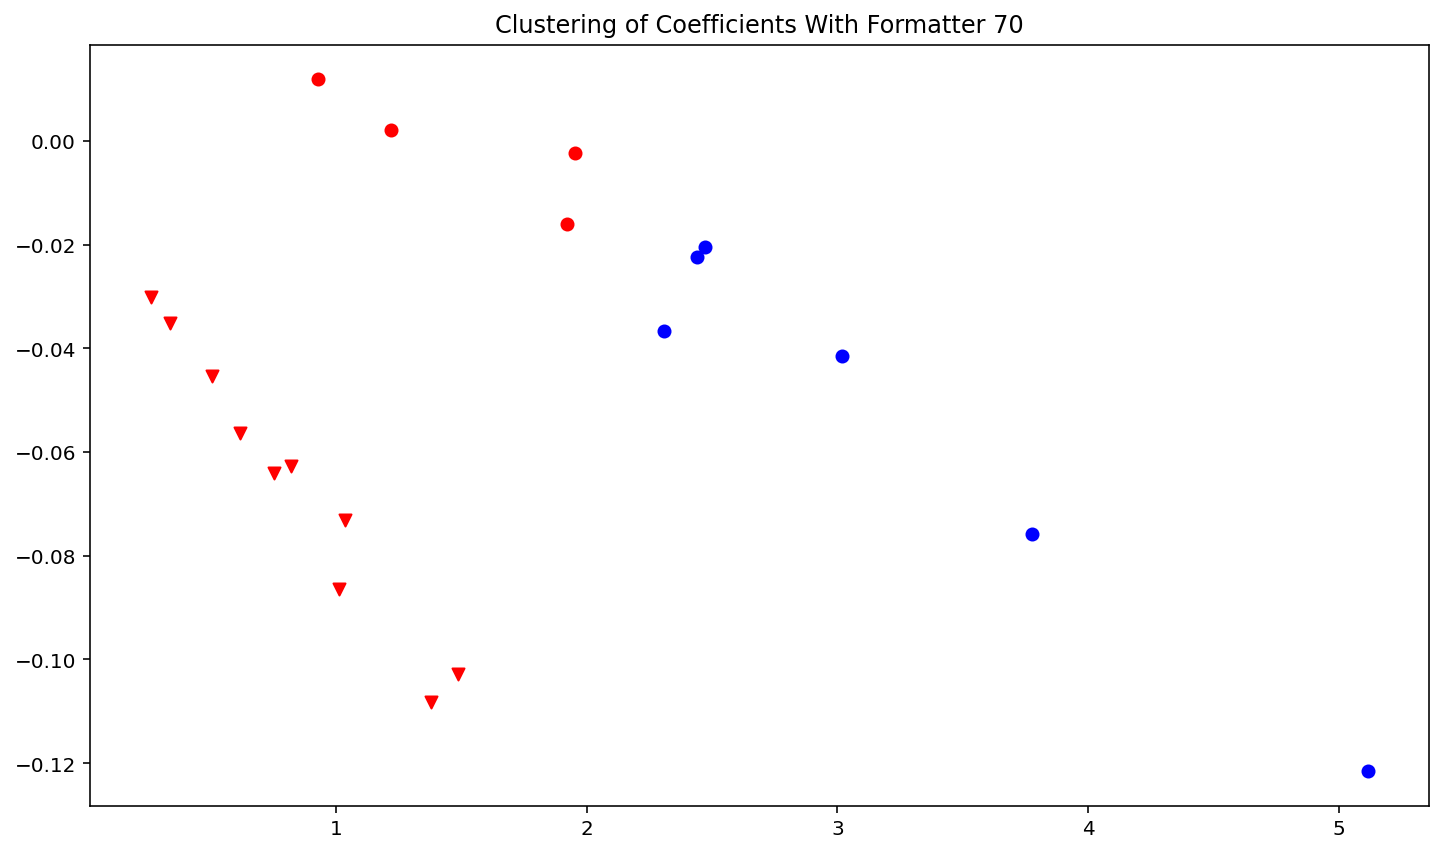

        Name  Label
0    City701      0
1    City702      0
2    City703      0
3    City704      0
4    City705      0
5    City706      0
6    City707      0
7    City708      0
8    City709      0
9   City7010      0
10   Home701      1
11   Home702      1
12   Home703      0
13   Home704      0
14   Home705      1
15   Home706      0
16   Home707      1
17   Home708      1
18   Home709      1
19  Home7010      0


In [141]:
load(70, 10)
clusterPoints(1)
clusterPoints(2)

#### Here we have two clear sets of data points for the devices.

#### This method creates a labeled dataframe using the coefficients and the device they came from. This labeled data is then used to train the Support Vector Machine.

In [142]:
def createLabeledDF(dataset):
    
    labeledDF = pd.DataFrame(columns = ['coef1', 'coef2', 'class'])

    classification = []
    coef1 = []
    coef2 = []
    
    for data in dataset:
        if 'City' in data:
            classification.append(0)
        else:
            classification.append(1)
        coef1.append(dataset.get(data).getCoefs(2)[0])
        coef2.append(dataset.get(data).getCoefs(2)[1])
    
    labeledDF['coef1'] = coef1
    labeledDF['coef2'] = coef2
    labeledDF['class'] = classification
    
    return labeledDF

#### Below I will be testing out the best classification algorithm to use on the dataset. The four algorithms being:
Naive Bayes, Random Forest, Logistic Regression, Support Vector Machine

Scores on test set:
Parameters: 
priors None
var_smoothing 1e-09
Naive Bayes : 1.00


Parameters: 
bootstrap True
ccp_alpha 0.0
class_weight None
criterion gini
max_depth 2
max_features auto
max_leaf_nodes None
max_samples None
min_impurity_decrease 0.0
min_impurity_split None
min_samples_leaf 1
min_samples_split 2
min_weight_fraction_leaf 0.0
n_estimators 100
n_jobs None
oob_score False
random_state 0
verbose 0
warm_start False


Random Forest : 1.00


Parameters: 
C 1.0
class_weight None
dual False
fit_intercept True
intercept_scaling 1
l1_ratio None
max_iter 100
multi_class multinomial
n_jobs None
penalty l2
random_state 0
solver lbfgs
tol 0.0001
verbose 0
warm_start False
Logistic Regression : 0.83


Parameters: 
C 10000000000.0
break_ties False
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 1
gamma auto
kernel poly
max_iter -1
probability False
random_state None
shrinking True
tol 0.001
verbose False
[-1.03279148 -1.04468101 -1.04150614 -1.14961593 -1.29717222 -0.99976419
 -1.13486447 -0.99974582 -1.29097779 -0.94134335  2.79650091  3.08171188
  1.19061904  0.99951843  1.86179281  2.17406547  2.40756377  3.95411617
  2.50003208  1.78875483]
Hinge Loss: 0.002981410911703841


Support Vector Machine : 1.00




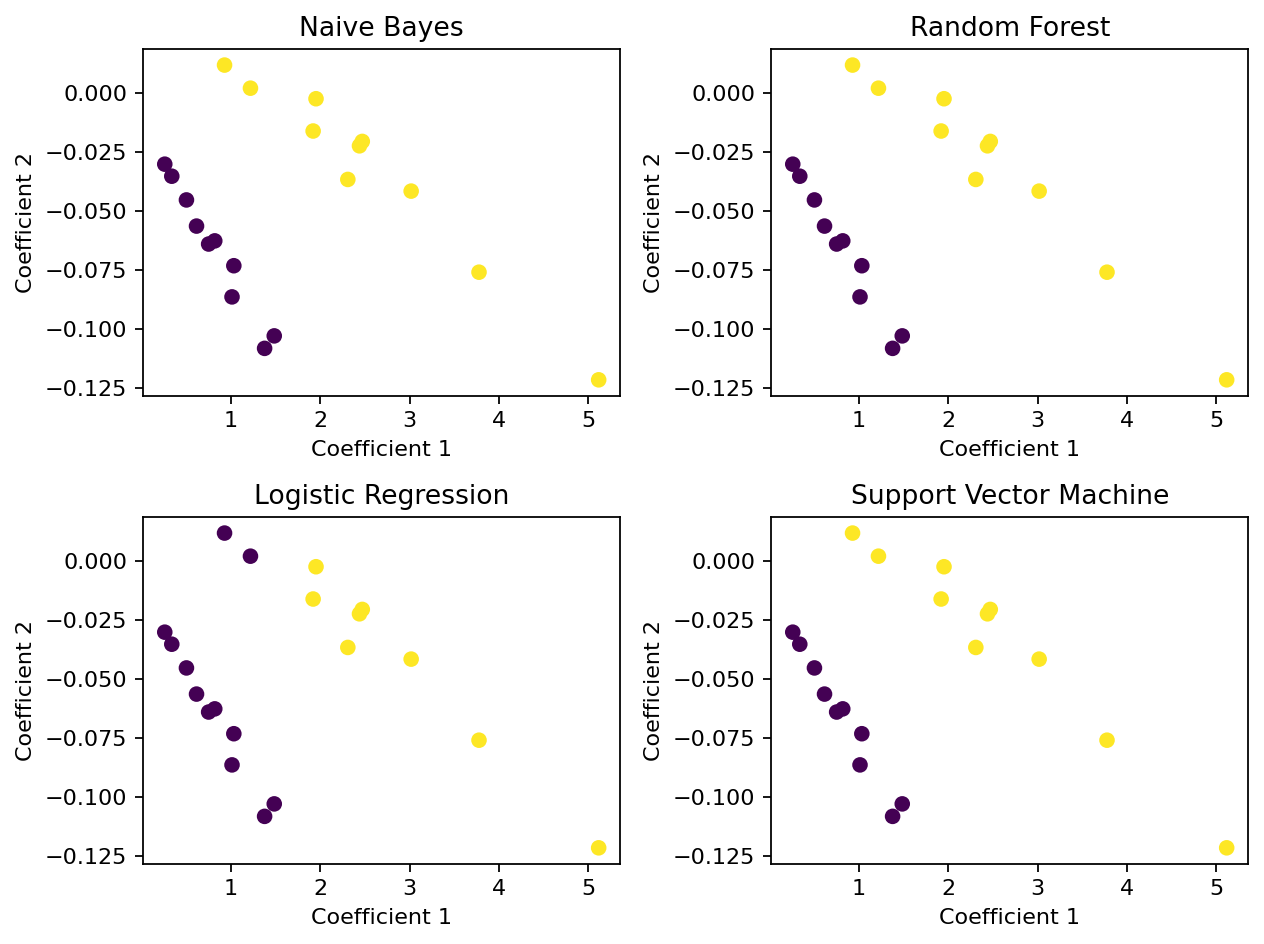

In [143]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

classifiers = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
    "Logistic Regression": LogisticRegression(random_state=0,
                           solver='lbfgs',
                           multi_class='multinomial'),
    "Support Vector Machine": SVC(kernel='poly', C=1E10, degree=1, gamma='auto')
}

data = createLabeledDF(dataList)

x_train, x_test, y_train, y_test = train_test_split(data[['coef1', 'coef2']],
                                                    data['class'],
                                                    test_size=0.3,
                                                    stratify=data['class'])

print("Scores on test set:")

for name in classifiers:

    print("Parameters: ")

    clf = classifiers.get(name)

    params = clf.get_params()
    for key in params:
        print(key + " " + str(params.get(key)))

    clf.fit(x_train, y_train)

    y_pred = clf.predict(data[['coef1', 'coef2']])

    if (name == "Support Vector Machine"):
        #Decision function: How far away each point is from the hyperplane
        decision = clf.decision_function(data[['coef1', 'coef2']])
        print(decision)
        print("Hinge Loss: " +
              str(metrics.hinge_loss(data['class'], decision)))


    plt.subplot(
        len(classifiers) / 2, 2,
        list(classifiers.keys()).index(name) + 1)
    plt.scatter(data['coef1'], data['coef2'], c=y_pred)
    plt.xlabel("Coefficient 1")
    plt.ylabel("Coefficient 2")
    plt.title(name)

    print("%s : %.2f" % (name, clf.score(x_test, y_test)))

    print("\n")

plt.tight_layout()
plt.show()

#### Based on the results and the accuracy of the classiers above, I chose to persue the Support Vector Machine as the classifier for this project.

#### The below method plots the decision boundary for the SVM model, which helps us to visualise the effects that different degrees have on our data.

In [144]:
# Full credit for the following method to Jake VanderPlas
# https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

def plotDecisionBoundary(model, ax=None, plot_support=True):
    
    if ax is None:

        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

#### This method prints a graph showing the generated SVM model for a given dataset and degree. It also outputs the results of testing beneath.

In [145]:
def svm(dataset, degree):
    
    data = createLabeledDF(dataList)
    
    x_train, x_test, y_train, y_test = train_test_split(data[['coef1', 'coef2']], data['class'], test_size=0.30, stratify=data['class'])
    
    model = SVC(kernel='poly', C=1E10, degree=degree, gamma='auto')

    model.fit(x_train, y_train)
    
    y_pred = model.predict(data[['coef1', 'coef2']])
    
    colourMap = {0 : 'deepskyblue', 1 : 'b', 2 : 'g'}
    colour = [colourMap[i] for i in y_pred]
    
    plt.scatter(data['coef1'], data['coef2'], c=colour)
    
    df = pd.DataFrame(model.support_vectors_)
    
    plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c='g')
    
    plotDecisionBoundary(model)
    
    plt.title("Degree: " + str(degree))
    plt.show()
    
    print("Percentage of test set correctly classified: %s \n" % (str(int(model.score(x_test, y_test)*100)) + "%"))

Loaded 10 City70


Loaded 10 Home70



Degree: 1


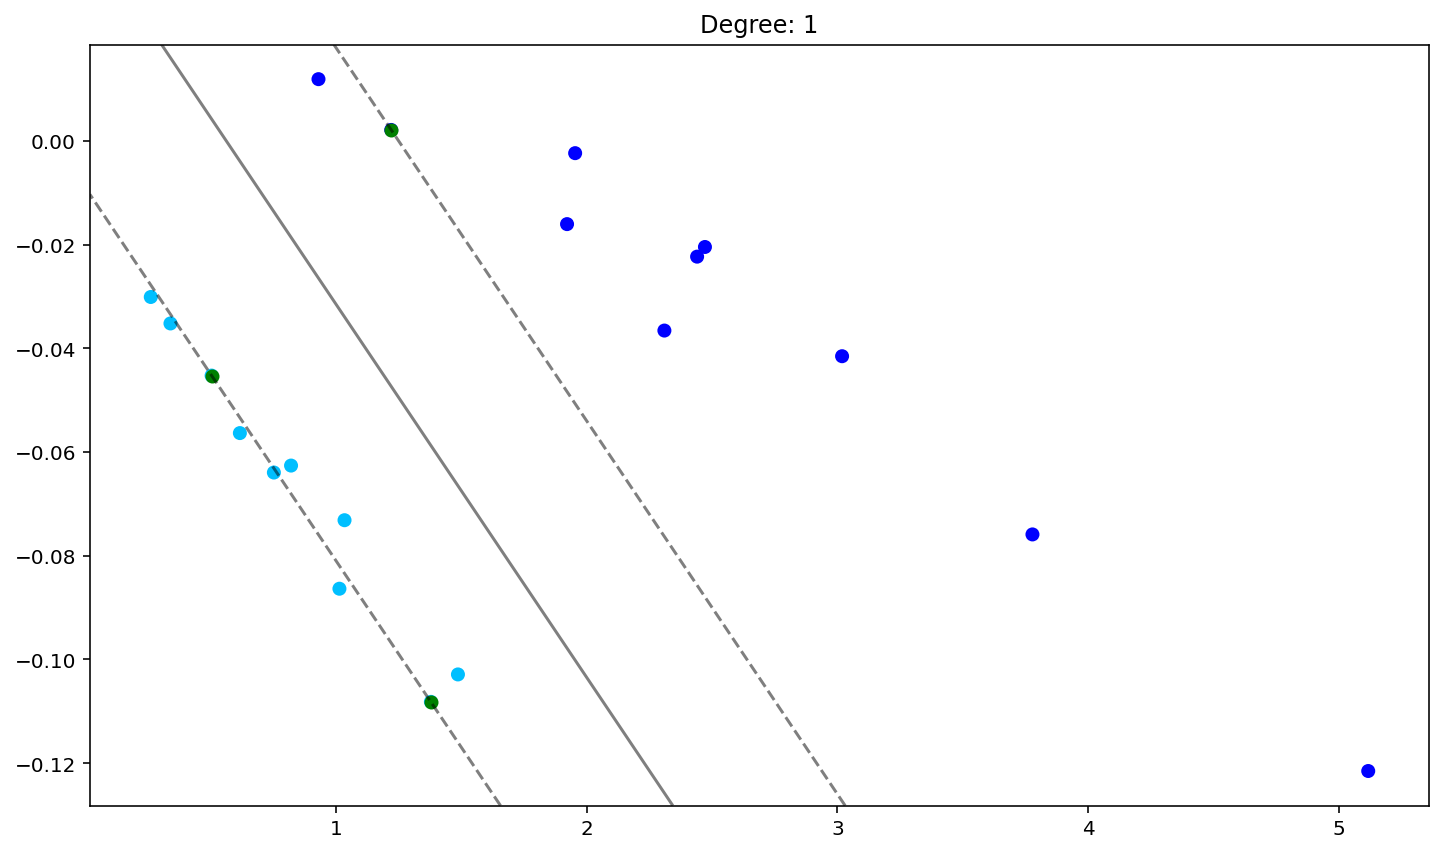

Percentage of test set correctly classified: 100% 


Degree: 2


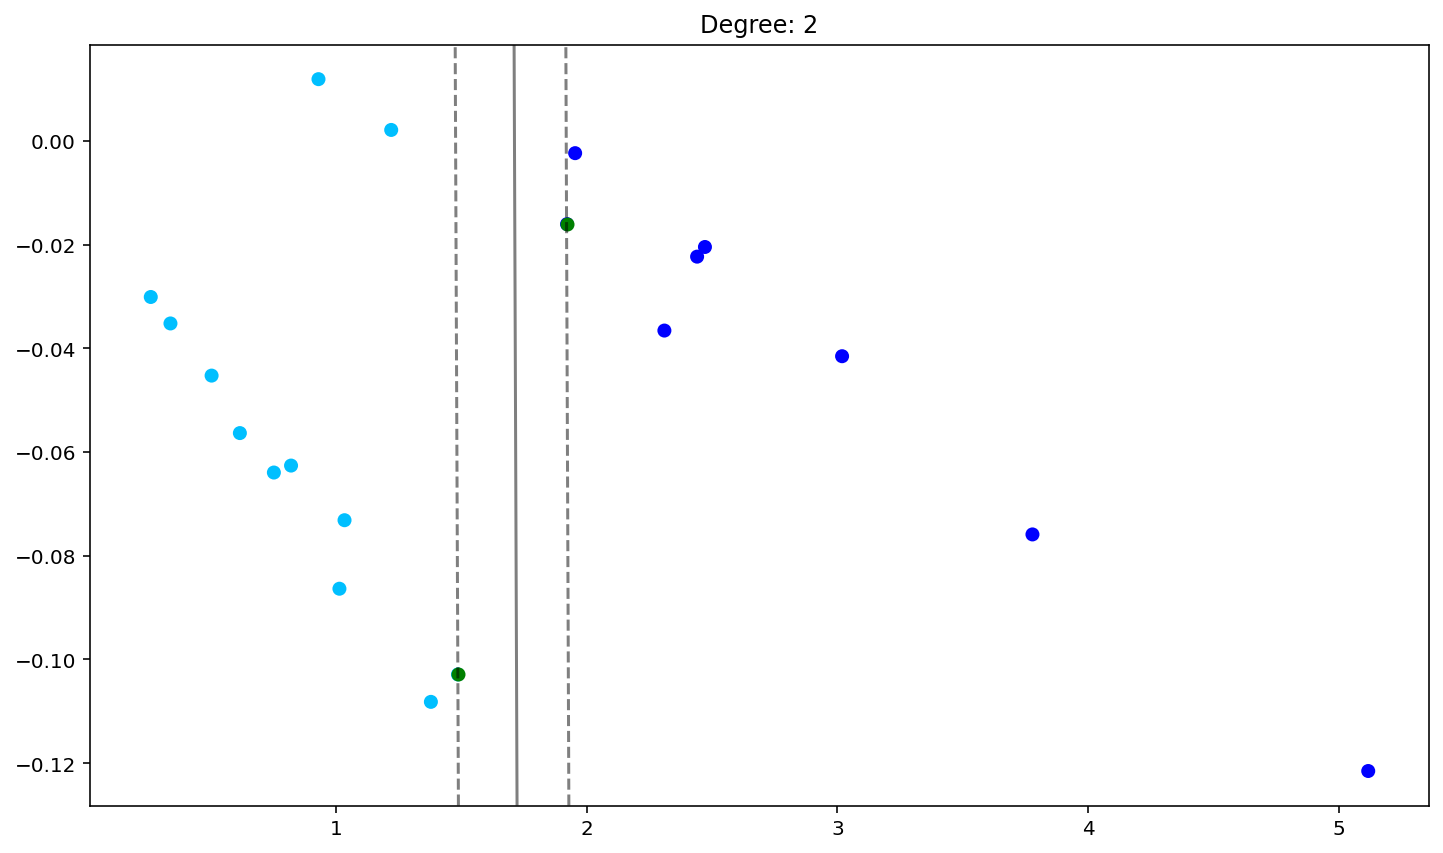

Percentage of test set correctly classified: 66% 


Degree: 3


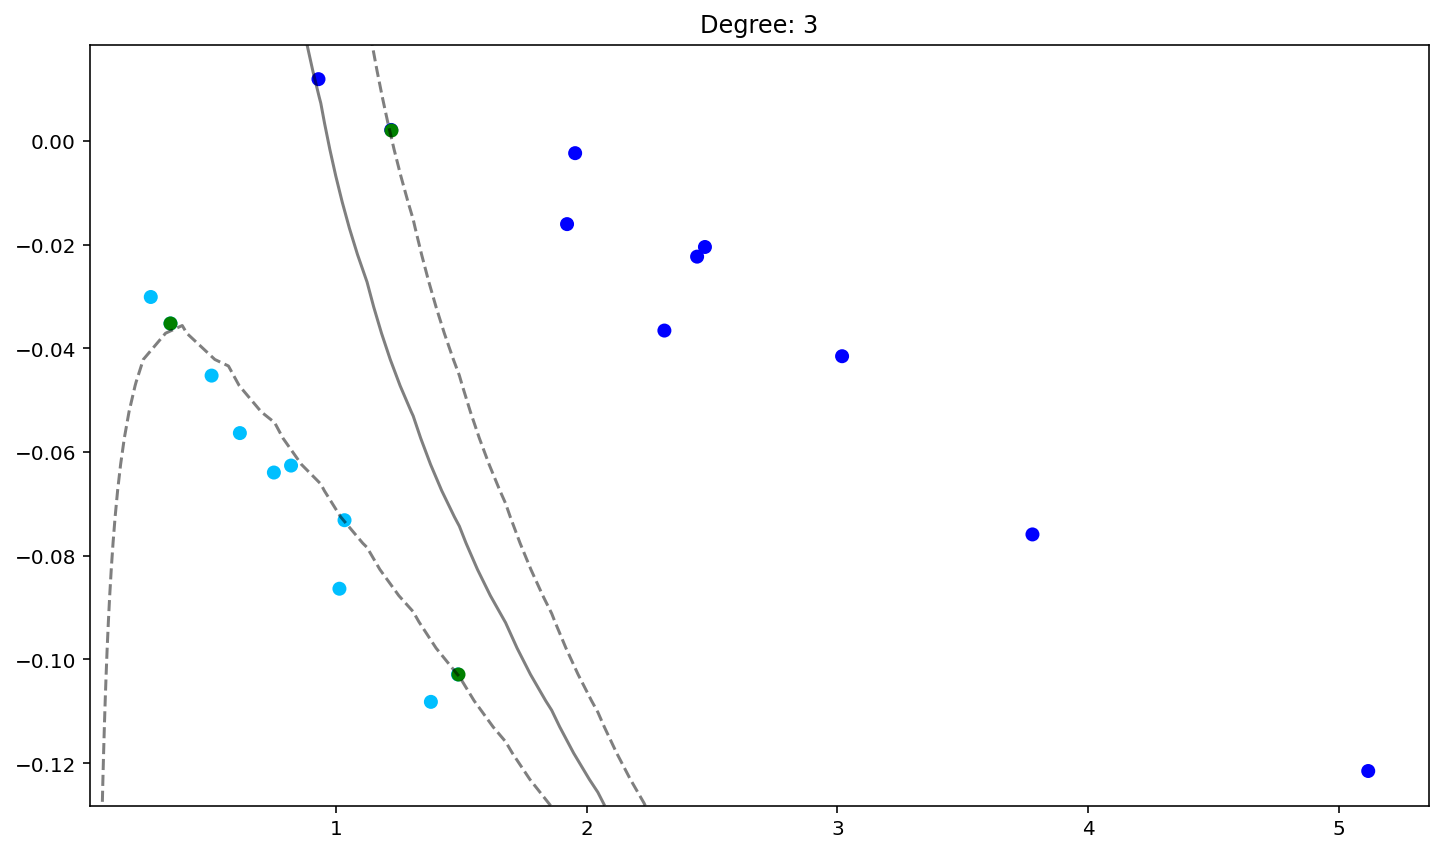

Percentage of test set correctly classified: 100% 


Degree: 4


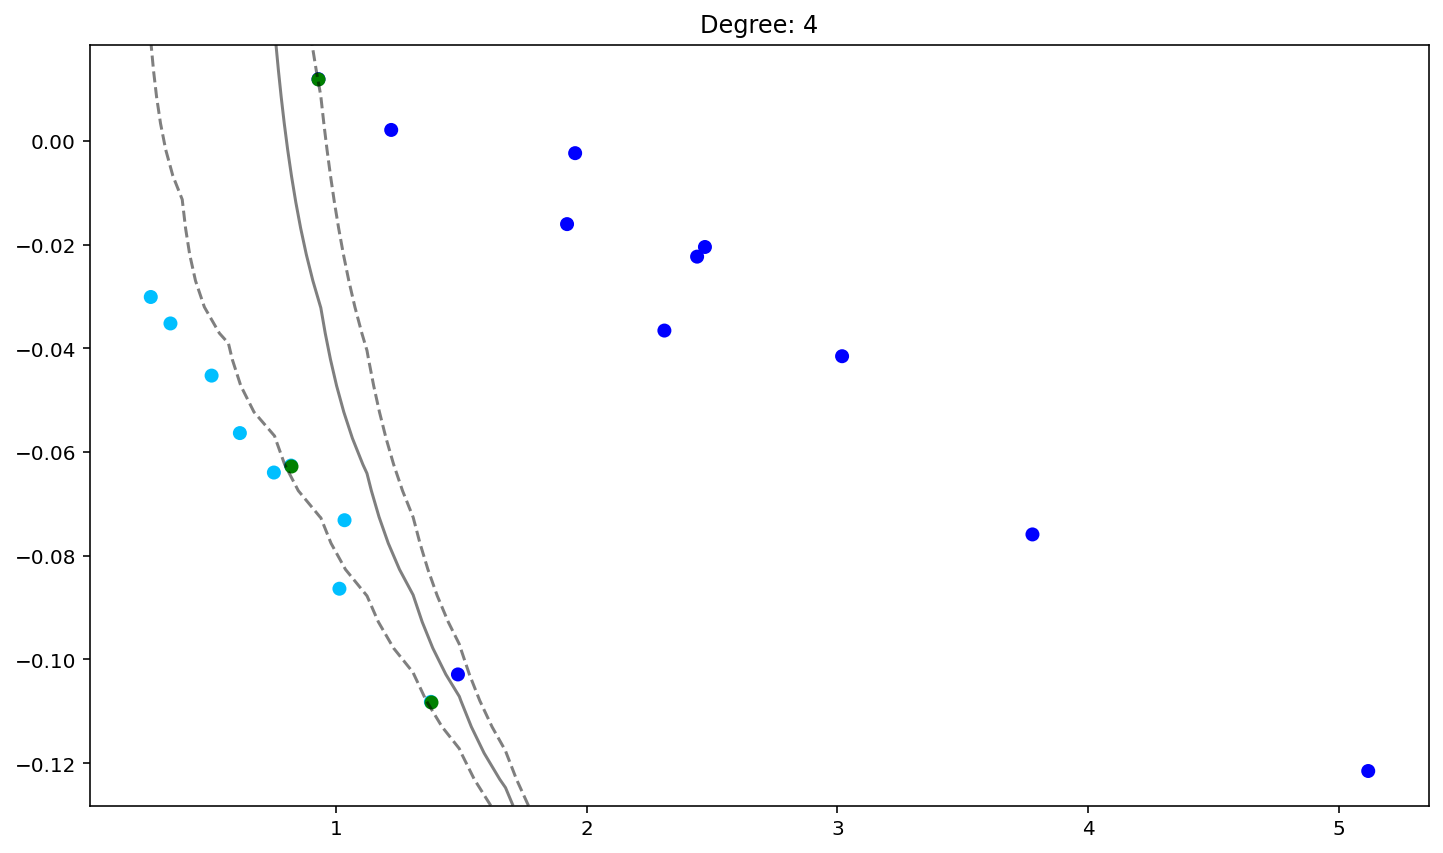

Percentage of test set correctly classified: 83% 


Degree: 5


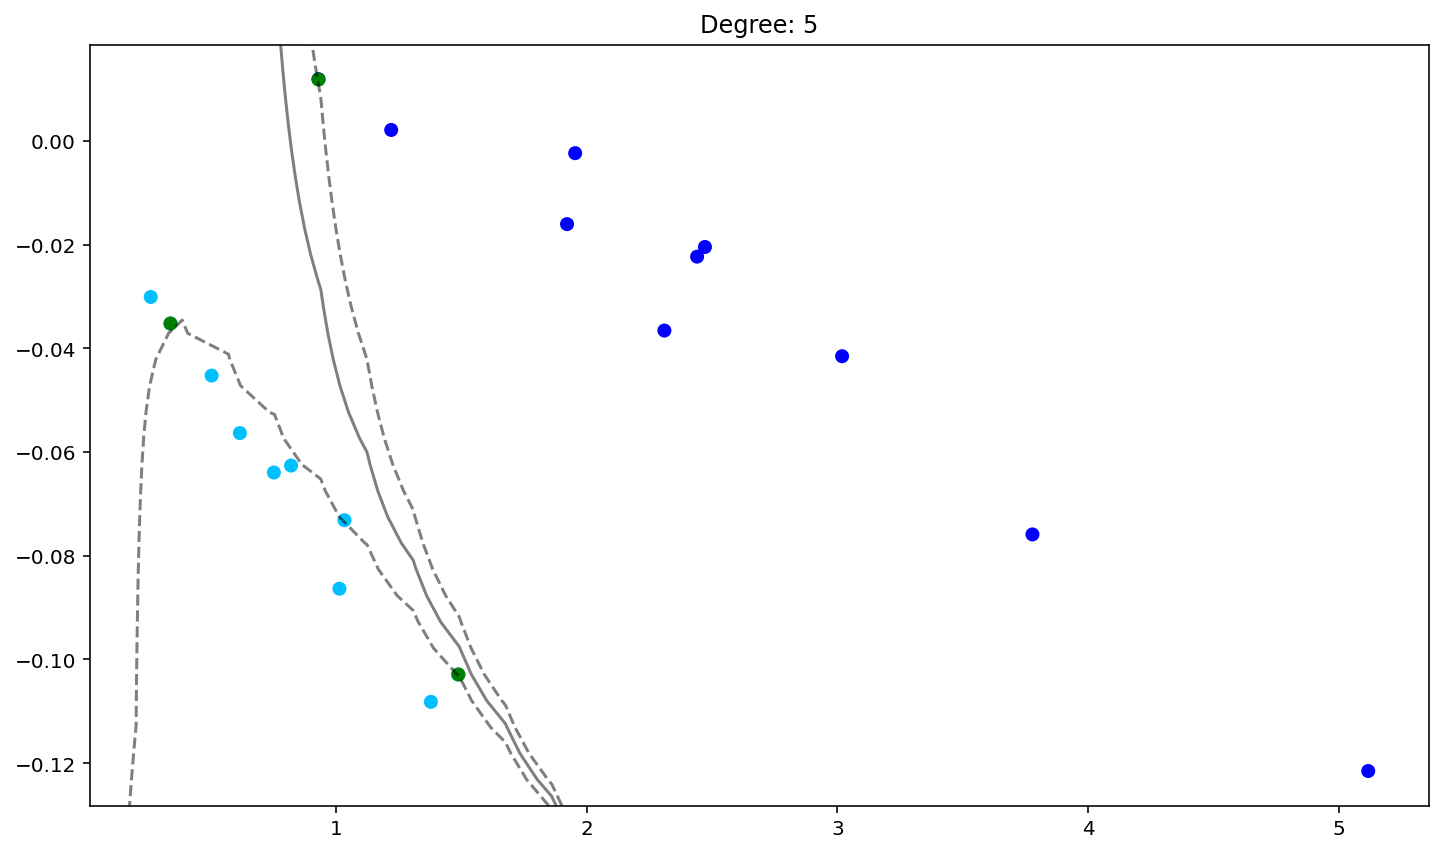

Percentage of test set correctly classified: 100% 



In [146]:
load(70, 10)

for i in range(0, 5):
    print("\nDegree: %d" % (i+1))
    svm(dataList, i+1)

#### From degree 2 onwards we can see overfitting affecting our results.

#### A degree of 1 creates an accurate decision boundary for our data